In [1]:
%matplotlib inline
import random
import _dynet
import sys 
import numpy as np
sys.argv.append('--dynet-devices')
sys.argv.append('GPU:0')

dyparams = _dynet.DynetParams()

# Fetch the command line arguments (optional)
dyparams.from_args()

# Set some parameters manualy (see the command line arguments documentation)
dyparams.set_mem(2048*5)
dyparams.set_random_seed(666)
# Initialize with the given parameters
dyparams.init() # or init_from_params(dyparams)

import dynet as dy

In [2]:
import pickle
data_file = 'elmo_embedded_training_data_merged_130k_0_1.pkl'
embedded_data = pickle.load(open(data_file,'rb'))


In [3]:
vocab = set()
type_vocab = set()
for thread in embedded_data:
    thread = thread[0]
    for message,type,output in thread:
        type_vocab |= set(type)
        vocab |= set(output)

In [4]:
to_remove = set()
safe = ['$&']
for v in vocab:
    if '[[' not in v and v not in safe:
        to_remove.add(v)
vocab -= to_remove

vocab |= set(['<START>','!','<UNK>','True','False'])
o2i = {o:i for i,o in enumerate(sorted(vocab))}
i2o = {i:o for i,o in enumerate(sorted(vocab))}
type_o2i = {o:i for i,o in enumerate(sorted(type_vocab))}
type_i2o = {i:o for i,o in enumerate(sorted(type_vocab))}

In [5]:
print(list(sorted(['$_','$&'])))

['$&', '$_']


In [6]:
def find_all_in(sub,full):
    return [i for i,s in enumerate(full) if s==sub]
all_data = []
copy_data = []
for thread in embedded_data:
    thread_gen = []
    thread_gc = []
    thread_cop = []
    text_thread = thread[0]
    for message,type,output in text_thread:
        gc = []
        gen = []
        cop = []
        
        for t in output:
            t = t.replace('\\n','\n')
            ts = t.split('\n\n')
            t = []
            for t_ in ts:
                t += t_.split('\n')
            ts = t
            for t in ts:
                if t == '':
                    continue
                if t in o2i:
                    gc.append(0)
                    gen.append(o2i[t])
                    cop.append([-1])
                elif t not in message:
                    gc.append(0)
                    gen.append(o2i['<UNK>'])
                    cop.append([-1])                    
                else:
                    gc.append(1)                    
                    gen.append(0)
                    cop.append(find_all_in(t,message))
                    #cop.append(message.index(t))
        runs = []
        in_run = False
        prev = -1
        for i,c in enumerate(cop):
            if len(c) > 1 or c[0] != -1:
                if in_run:
                    pass
                else:
                    in_run = True
                    prev = i
                    
            else:
                if in_run:
                    runs.append((prev,i-1))
                    in_run = False
        
        if in_run:
            runs.append((prev,i))
            in_run = False
        actual_cop = [0]*len(cop)
        #This now goes and finds the longest run that is consistent for copying
        for start,end in runs:            
            if start == end:
                actual_cop[start] = cop[start][0]
            else:
                potential_starts = cop[start]
                for r in range(start,end+1):
                    offset = r-start
                    good = []
                    for c in cop[r]:
                        if c-offset in potential_starts:
                            good.append(c-offset)
                    potential_starts = good
                if (len(potential_starts) == 0):
                    for i in range(start,end+1):
                        actual_cop[i] = cop[i][0]
                else:
                    copy_start = potential_starts[0]
                    for i,r in enumerate(range(start,end+1)):
                        actual_cop[r] = copy_start+i
        cop = actual_cop
        thread_gen.append(gen)
        thread_gc.append(gc)
        thread_cop.append(cop)
    all_data.append(list(zip([m[0] for m in thread[0]],[m[1] for m in thread[0]],[m[2] for m in thread[0]], thread[1],thread_gen,thread_gc,thread_cop)))

$log(p_m * p_{tok})$ =

In [7]:
import sys
def is_number(s):
    try:
        float(s)
        return float(s)
    except ValueError:
        return 0.0

class CopyNetwork:
    def __init__(self, enc_layers, dec_layers, type_embeddings_size,embeddings_size, 
                 enc_state_size, dec_state_size,output_embedding_size, vocab_size, dropout = 0.1, 
                predict_mode = True,mode_softmax = True, multiply_mode = False, joint_loss = True,hard_mode=True):
        self.model = dy.Model()
        self.type_embeddings = self.model.add_lookup_parameters((len(type_o2i), type_embeddings_size))
        self.output_embeddings = self.model.add_lookup_parameters((vocab_size, output_embedding_size))
       
        # the rnns
        #1 for type + 1 for history + obv
        self.ENC_RNN_F = dy.LSTMBuilder(enc_layers, 2+type_embeddings_size+embeddings_size, enc_state_size/2, self.model)
        self.ENC_RNN_F.set_dropout(dropout)
        self.ENC_RNN_B = dy.LSTMBuilder(enc_layers, 2+type_embeddings_size+embeddings_size, enc_state_size/2, self.model)
        self.ENC_RNN_B.set_dropout(dropout)
        
        self.DEC_RNN = dy.LSTMBuilder(dec_layers, enc_state_size+output_embedding_size+2, dec_state_size, self.model)
        self.DEC_RNN.set_dropout(dropout)
        
        # attention weights
        self.attention_w1 = self.model.add_parameters((enc_state_size, enc_state_size))
        self.attention_w2 = self.model.add_parameters((enc_state_size, dec_state_size))
        self.attention_v = self.model.add_parameters((1, enc_state_size))

        
        self.copy_w1 = self.model.add_parameters((enc_state_size, enc_state_size))
        self.copy_w2 = self.model.add_parameters((enc_state_size, dec_state_size))
        self.copy_v = self.model.add_parameters((1, enc_state_size))

        # project the rnn output to a vector of VOCAB_SIZE length
        self.mode_w = self.model.add_parameters((2, dec_state_size))
        self.mode_b = self.model.add_parameters((2))
        
        # project the rnn output to a vector of VOCAB_SIZE length
        self.output_w = self.model.add_parameters((vocab_size, dec_state_size))
        self.output_b = self.model.add_parameters((vocab_size))
        
        self.enc_state_size = enc_state_size
        self.type_embeddings_size = type_embeddings_size
        self.embeddings_size = embeddings_size
        self.output_embedding_size = output_embedding_size
        self.predict_mode = predict_mode
        self.mode_softmax = mode_softmax
        self.multiply_mode = multiply_mode
        self.joint_loss = joint_loss
        self.hard_mode=hard_mode
    def _run_rnn(self, init_state, input_vecs):
        s = init_state

        states = s.add_inputs(input_vecs)
        rnn_outputs = [s.output() for s in states]
        return rnn_outputs
    def _encode_string(self, embedded_string,RNN):
        initial_state = RNN.initial_state()

        # run_rnn returns all the hidden state of all the slices of the RNN
        hidden_states = self._run_rnn(initial_state, embedded_string)

        return hidden_states
    
    def _attend(self, input_vectors, state, w1, w2,v ):
        attention_weights = []

        w2dt = w2 * state.h()[-1]
        for input_vector in input_vectors:
            
            attention_weight = v * dy.tanh(w1 * input_vector + w2dt)
            attention_weights.append(attention_weight)
        pre_softmax = dy.concatenate(attention_weights)
        attention_weights = dy.softmax(dy.concatenate(attention_weights))

        output_vectors = dy.esum(
            [vector * attention_weight for vector, attention_weight in zip(input_vectors, attention_weights)])
        return output_vectors, attention_weights, pre_softmax
   
    def _embed(self,pos,pos_embed):
        return [pos_embed[p] for p in pos]
    
    def get_probs(self, w, b, rnn):
        return w*rnn+b
    
    def get_loss(self, history_string,input_string,type_string,embedded_string,output_modes, output_generate, output_copy,
                 dropout=0.1,teacher_forcing_=lambda : True,copy_loss_modifier=1.0):
        
        embedded_string = embedded_string
                
        dropouted = []
        dropped = []
        numbered = []
        type_dropped = []
        history_dropped = []
        input_dropped = []
        for i,(s,t,e,h) in enumerate(zip(input_string,type_string,embedded_string,history_string)):
            if random.random()>dropout or i in output_copy or t != '$BODY':
                dropouted.append(dy.inputTensor(e))
                numbered.append(is_number(s))
                input_dropped.append(s)
                type_dropped.append(t)
                history_dropped.append(h)
            else:
                dropped.append(i)
        dropped_copy = []
        for d in output_copy:
            if d != 0:
                neg = 0
                for d_i in dropped:
                    if d_i < d:
                        neg -= 1
                d += neg
            dropped_copy.append(d)
        output_copy = dropped_copy    
        embedded_string = dropouted
        
        
        
        embedded_string = [dy.concatenate([dy.inputTensor(np.array([n])),
                                           dy.inputTensor(np.array([h])),
                                           e,
                                           self.type_embeddings[type_o2i[t]]]) for n,h,e,t in zip(numbered,
                                                                                                history_dropped,
                                                                                                embedded_string,
                                                                                                type_dropped)]
        encoded_string_f = self._encode_string(embedded_string,self.ENC_RNN_F)
        encoded_string_b = self._encode_string(list(reversed(embedded_string)),self.ENC_RNN_B)
        encoded_string = [dy.concatenate([f,b]) for f,b in zip(encoded_string_f,reversed(encoded_string_b))]
        copy_string = [e for e,h in zip(encoded_string,history_dropped) if h == 0]
        
        mode_probs = []
        gen_probs = []
        copy_probs = []
        
        losses = []
        generate = random.random() < 0.01
        output = []
        
        prev_mode = 0
        prev_tok = o2i['<START>']
        rnn_state = self.DEC_RNN.initial_state().add_input(
                dy.vecInput(self.enc_state_size+self.output_embedding_size+2)
            )
        teacher_forcing = True
        correct = 0
        total = len(output_modes)
        for mode,gen,copy in zip(output_modes,output_generate,output_copy):
            attended_encoding,_,_ = self._attend(encoded_string, rnn_state, 
                                                       self.attention_w1, self.attention_w2,self.attention_v)
            _,p_copy,raw_copy = self._attend(copy_string, rnn_state, 
                                                       self.copy_w1, self.copy_w2,self.copy_v)
            
            mode_vec = np.zeros(2)
            mode_vec[prev_mode] = 1
            rnn_input = dy.concatenate([attended_encoding,
                                        self.output_embeddings[prev_tok],
                                        dy.inputTensor(mode_vec)
                                       ])
            
            
            rnn_state = rnn_state.add_input(rnn_input)
            
            p_mode = self.get_probs(self.mode_w,self.mode_b,rnn_state.output())
            
            p_gen = self.get_probs(self.output_w,self.output_b,rnn_state.output())
            
            if teacher_forcing:
                prev_mode = mode
                prev_tok = gen
            else:
                prev_mode = p_mode.value()
                prev_mode = prev_mode.index(max(prev_mode))
                prev_tok = p_gen.value()
                prev_tok = prev_tok.index(max(prev_tok))
            
                
            if self.predict_mode:
                if not self.hard_mode:
                    if self.multiply_mode:
                        truth = copy
                        if mode == 0:
                            truth = gen+len(copy_string)
                        if self.mode_softmax:
                            p_mode = dy.softmax(p_mode)
                        all_probs = dy.concatenate([raw_copy*p_mode[1],p_gen*p_mode[0]])
                    else:
                        raise(Exception('If Using a Soft mode, you need to multiply'))
                else:     
                    if self.multiply_mode:
                        if self.mode_softmax:
                            p_mode = dy.softmax(p_mode)
                        if  mode == 0:
                            all_probs = p_gen*p_mode[0]
                            truth = gen
                        else:
                            all_probs = raw_copy*p_mode[1]
                            truth = copy       
                    else:
                        if  mode == 0:
                            all_probs = p_gen
                            truth = gen
                        else:
                            all_probs = raw_copy
                            truth = copy                    
            else:
                truth = copy
                if mode == 0:
                    truth = gen+len(copy_string)
                all_probs  = dy.concatenate([raw_copy,p_gen])
            
            if self.joint_loss:
                mode_err = dy.pickneglogsoftmax(p_mode, mode) 
                losses.append(mode_err) 
            losses.append(dy.pickneglogsoftmax(all_probs,truth))            
            if np.argmax(all_probs.value()) == truth:
                correct += 1.0
            if generate and verbose:
                if predict_mode:
                    p_mode = p_mode.value()
                    p_copy = p_copy.value()
                    p_gen = p_gen.value()
                    if p_mode[0] > p_mode[1]:
                        output.append(i2o[p_gen.index(max(p_gen))])
                    else:
                        output.append(input_dropped[p_copy.index(max(p_copy))])
                else:
                    p_copy = p_copy.value()
                    p_gen = p_gen.value()
                    index = np.argmax(all_probs.value())
                    #print(mode,copy,gen,truth,index,all_probs.value(),p_copy,p_gen)
                    if index < len(copy_string):
                        output.append(input_dropped[index])
                    else:
                        output.append(i2o[index-len(copy_string)])
                        
        if verbose and generate:
            print('IN:',' '.join(input_string))
            print('IN DROPPED',' '.join(input_dropped))
            print('OUT:',' '.join(output))
            sys.stdout.flush()
        return losses,correct,total
    

In [8]:
copy_network = CopyNetwork(3, 3,8, 1024, 1024, 1024, len(o2i),len(o2i),dropout = 0.35, 
                predict_mode = True,mode_softmax = False, multiply_mode = False, joint_loss = True,hard_mode=True)
lr = 0.01
trainer = dy.AdamTrainer(copy_network.model,alpha = lr)
random.shuffle(all_data)
split = int(len(all_data)*0.7)
all_data_training = all_data[:split]
all_data_eval = all_data[split:]


EPOCH 0


1.821610833936262
1.760610642575129
1.7010933344911883
1.6845988274088772
1.625117231837499
1.5924121130612356
1.560827287917445
1.5413395735615227
1.5079398727932267
1.4881782446416256
1.45575585720007
1.436249980131202
1.4225904875322413
1.4017958113102291
1.379821935684974
1.3699077806547668
1.351952340708256
1.3314208719541476
1.3230659505813354
1.3148571727620373
1.3023431551877687
1.2991067181191835
1.2929826217956966
1.289243615818918
1.283912474598218
1.27534901151885
1.2720191984151719
1.2639622598216012
1.2577686718244943
1.2520891820629036
1.2406551488890174
1.233737366482641
1.2338888433808781
1.2289881375348992
1.2216504162329345
1.2152241854876513
1.2122964558561025
1.2116883332195172
1.2074530113274298
1.2047922477037207
1.2006130861081015
1.1948327674983448
1.186878687386289
1.1868925405486237
1.185904004245935
1.1835452481126079
1.1739502532091415
1.1694421928762906
1.1569293901741797
1.1490203535167303
1.1387824015995827
1.134772613571827
1.122649337938997
1.109861172

0.3638606822121856
0.3635560640234014
0.36299740169536937
0.3627547920862621
0.3620184827056214
0.3616791674730336
0.3611259706108729
0.3613792859467262
0.3608394643125978
0.3603823751095253
0.360165691911777
0.35984115941939965
0.35945174201316854
0.35898931964335
0.35841597146801935
0.3582608886914011
0.3579924306091317
0.35764035345772577
0.3571890816407268
0.356750636347421
0.35645702130009127
0.3569892949712844
0.35649935046479797
0.3559297506143619
0.35551599775911186
0.35501586165889765
0.3548722574099336
0.35467894894417734
0.35462206581899874
0.3542218134385746
0.3537643067993573
0.3534971486948044
0.3532756028087676
0.35288030226352796
0.35269808617554554
0.352284027410822
0.3517754162655556
0.3513839443270327
0.3509083260507171
0.3508029729618023
0.3505267827745171
0.3501567248525354
0.3499871613978825
0.3494853103614131
0.34978159438821677
0.34947698863157617
0.3490358027810096
0.348813871450159
0.3485198646044597
0.34813177443015214
0.34768181939757864
0.3472246501477619
0

0.2778558182865687
0.2777601684781552
0.27759452027583453
0.2774750839939573
0.27740261662285487
0.2772828733696371
0.2771673781291223
0.2769763373536696
0.27674444247170954
0.27675435717177843
0.27662813414311593
0.27649092707701084
0.2763732570294423
0.27626283284026637
0.2760516756145589
0.2759329567752976
0.2758341757591303
0.2757367312004811
0.2755416442429439
0.2754273109512763
0.27535971374664187
0.2751805964058635
0.2749924661180505
0.2750968919690937
0.2749757694649395
0.27479207848757226
0.27462429744229433
0.2745444600722172
0.2744620055808644
0.27445267779403676
0.2743043008947091
0.27416489364932584
0.27408864718507864
0.27420095282465623
0.2740656274195447
0.27391033733340436
0.27376692614739934
0.27361320064923117
0.2734887516305871
0.27337851928119217
0.2732270824164802
0.2730789618002762
0.2729036744959193
0.27274332184761213
0.2725840072724299
0.2724097139803053
0.27223337423803246
0.27215877069009553
0.2720862417822396
0.2720269777814727
0.27193240524098056
0.2718797

0.2443357375513092
0.24423580826445107
0.24416014968363534
0.24416897648761432
0.2440914776927199
0.24401608428820018
0.24398377588144193
0.24392625230182446
0.2438512886928321
0.24374345374885026
0.2436437212203922
0.24357137231213286
0.2435251598984697
0.24349662082249565
0.24345888556529424
0.2434339828360737
0.24333808148818817
0.24327793307068757
0.24325425034189524
0.24321776473636514
0.24312053214721133
0.24307538585106336
0.24302293878483391
0.2429525906009051
0.2428992578976003
0.242859113920428
0.2428288685474245
0.24275718155887963
0.2427093597062137
0.24262753696328593
0.24257596452043786
0.24248154556890034
0.2424230555808861
0.2423426444721421
0.2423065819550718
0.24225673299402498
0.24221018303717834
0.24212447672714674
0.24203681472280061
0.24197469707254887
0.241942702650012
0.2418849371897812
0.24179656402659605
0.24174036835007184
0.24168063836968154
0.2416276568028803
0.24153326879008546
0.24147949382228626
0.24136740195164264
0.2413381580899538
0.24129581138098607


0.2251571200130234
0.22513091827489
0.22515496002618948
0.22517999983853706
0.22512088552664603
0.22510233023256998
0.22506290263711404
0.22503274761964612
0.22497753140870663
0.2249122728136708
0.22488796131804004
0.22485081624239228
0.22482223805992554
0.22476461165528205
0.22471186516147265
0.22468329314023772
0.22466354407818273
0.2246325424174951
0.22457560997919054
0.22451436662283272
0.22448193223044763
0.22446539299199827
0.2244292952781751
0.2243969993283789
0.22433081481728007
0.22428824300797925
0.2242512753631087
0.22429740602598855
0.22424786974197494
0.2242195480263988
0.2241551856107385
0.2241208007168591
0.22406378764798993
0.22400550838541566
0.22393936822975508
0.2238901856429277
0.22387143466299708
0.22386571999528806
0.22380309270868268
0.22375152918587746
0.2237376139189422
0.22372546438803348
0.22366975408286605
0.22366723986474413
0.22362022514998525
0.2236212421025919
0.22358665942886355
0.22353106109816825
0.22354530027065994
0.22348960612482058
0.2234312894727

0.21269180066793755
0.2126477281616919
0.21261337739476488
0.21259843107384213
0.21256510352143632
0.21255256092176464
0.21253914411383906
0.21252137644950891
0.21250247811535022
0.21256420693264794
0.21253307125096588
0.2125039752786657
0.21246197129501915
0.2124550611180629
0.21242815180246938
0.2124204258653892
0.21238766352224908
0.2123534224558221
0.2123217399603131
0.21230760810689528
0.21225322156109924
0.21223118456859075
0.21219479365196942
0.21218356340538488
0.21216482945395618
0.2121414735737554
0.21212824309372147
0.2121201615314481
0.21214563087344618
0.2121241633374313
0.21208316275237732
0.21206309994890055
0.21204631323228293
0.21200769103163952
0.21201424105915495
0.21197460197242043
0.21193575032095271
0.21191066353004226
0.21186130727931712
0.21180878191764343
0.21179827505749838
0.21177261707710676
0.21174393328518917
0.21172556306383825
0.2117318167233356
0.21171126671498988
0.21171490120493022
0.21167521167611414
0.2116390918731868
0.21160868914882675
0.211569317

0.20563115445005184
0.20561223224650718
0.2055982527609093
0.2055952177744366
0.20558589388383655
0.20557812339750536
0.205542757504184
0.2055351124027908
0.20553560455453557
0.20552206886781504
0.20550372831231137
0.20548721861942804
0.2054593321949433
0.2054430020593433
0.2054068492584005
0.20537571091769335
0.20535621294129686
0.2053384130918452
0.2053237014041791
0.2053477530488637
0.20533821575301547
0.2053104769025817
0.20531523927276257
0.20529804566406243
0.20530397204388945
0.20526820849227811
0.205229665126854
0.20523502330707297
0.20520392964401318
0.2052154767686791
0.20520026192862065
0.20518807628596628
0.20517312420328598
0.2051740190618854
0.20513871411517146
0.2051202445872917
0.2050996248977351
0.2051000710133689
0.20506481557287565
0.20505276451715462
0.20508854894563602
0.20505575300427864
0.20504099551335508
0.20501574782260903
0.2049974829430949
0.204993737393261
0.2049640811704108
0.20493326004840784
0.20489672083550217
0.20489328032610157
0.2048583026788524
0.20

0.19901201552805367
0.19901279780991146
0.19898476455731967
0.19897665632747533
0.19896202059346546
0.198939095736548
0.19892979666607552
0.19892717934142176
0.1989149288587408
0.19889578916738737
0.19888643324946248
0.1988670308788541
0.19883322127903286
0.19882454887612627
0.19881035677297698
0.1987855435968695
0.19878363934512702
0.19877753998041361
0.19875495523109343
0.19875911865646476
0.19874865759411914
0.19873658301569763
0.19875535720707202
0.19873373421712093
0.19870435291519775
0.19867852418857898
0.19865016169840108
0.19869974722530284
0.19869394420448042
0.19867204996333
0.19864195855781058
0.19865071453136965
0.198647779397213
0.1986356507277344
0.19863455318025278
0.1986653006688935
0.19864554708152976
0.1986243992167299
0.19859478401898933
0.19857962124872183
0.1985559000665227
0.1985301244675215
0.19852262097303555
0.19849267978870141
0.1984783256802592
0.19845984659763857
0.1984532942879214
0.1984455248210823
0.1984254135808124
0.19842079417096758
0.19840745909178076

0.19469009155334974
0.19467959694460787
0.1946685697995349
0.19465836884860904
0.1946630372062353
0.19465225432162836
0.1946836391572547
0.19467595335447643
0.1946765088393963
0.19466194836061468
0.19464368850461275
0.19461831565477355
0.19459485930813128
0.19459132812897215
0.19460045934970832
0.19459875172712085
0.19460485083403323
0.1945983144020042
0.1945794811779982
0.19458452777577986
0.19456568404747732
0.19456923150134564
0.19458768279585273
0.19457921043751109
0.19457720221408834
0.19456566112194368
0.19458120314728783
0.19456205304814722
0.19454589895101757
0.19452589996563344
0.19450766614237824
0.19451851271788254
0.19450305649903
0.19448477645960954
0.1944795259698929
0.19446649087785095
0.19447280008350967
0.19447285736390352
0.19445679814526076
0.1944385061852268
0.19443057780975226
0.19442165857956756
0.1944052392875087
0.19441391552813816
0.19441476824931528
0.1943983137342944
0.19440089898428056
0.19439434649453427
0.19438349734784985
0.1943905462367486
0.194385348829

0.1915325254065272
0.1915209255466909
0.19150768723413514
0.1915019975670399
0.19148407279736204
0.1914935021510197
0.19147949298659525
0.19146266370672424
0.19147966678902295
0.19145907115379177
0.1914417895873256
0.19142374285472336
0.19141498730912682
0.19139324990925544
0.19137905389156207
0.1913712157378042
0.1913732544625335
0.1913584094732074
0.19134840397242697
0.19133143455416007
0.19134151511052955
0.19133102672845786
0.1913188899630891
0.19132998252827807
0.19132295351431275
0.1913136473908865
0.19131499314316855
0.19131095914915283
0.19130792743237884
0.19129555791470731
0.19130037078856793
0.19131086511926546
0.19129956428110698
0.19128031934042034
0.19125816990835198
0.19125111726797328
0.1912399282450855
0.1912235230122927
0.19121383720875862
0.19121156593006886
0.19119897847574707
0.19119243259421972
0.19119435593193365
0.19117831491861478
0.19116681528690954
0.19116491182012754
0.19115698863169311
0.19114518666257743
0.19114630592658668
0.19114749524258642
0.1911300384

0.18875177238510907
0.18874585650295808
0.18877415849487064
0.18877293885307248
0.18878037627099173
0.18877860297973248
0.18877339524818668
0.1887824621411016
0.18877219520336044
0.18876399171763245
0.18875897575129877
0.18875943063471604
0.18874586954911504
0.18873467019248102
0.18872210754254629
0.18871322658461587
0.18870672033094385
0.1886946622790866
0.188691617914236
0.18867358678060445
0.18867931661337004
0.18866313806695922
0.18866140587833827
0.18866926425557343
0.18865880983841735
0.18865775361770862
0.18865832351124273
0.18865256470821418
0.18864811687117924
0.18865407938077283
0.1886364887289215
0.1886273338606955
0.1886276281159495
0.18862788935303912
0.18861496894031246
0.1886207047386256
0.18861270720776194
0.18859686979373189
0.18858525693782296
0.1885756572655913
0.1885668334356381
0.18855245664166534
0.18855170098684593
0.18853954112758375
0.18853686758402308
0.18853133232447944
0.18852287585034527
0.18851426699907356
0.1885052782863772
0.1884880988481274
0.1884710030

0.18636948312676782
0.1863558558653904
0.18637093488276482
0.18635501584530295
0.1863568299828744
0.18634397054956223
0.18633683809953402
0.18634251460668838
0.1863331972948896
0.18632265498703962
0.18632260229705894
0.18631003733151957
0.1862986742472168
0.18628845841041788
0.18628423758673088
0.18627893124348993
0.18627311384980982
0.18627731937200467
0.18626128996136115
0.18625517315472614
0.18624414913554926
0.18623800013195124
0.18623642452919348
0.1862345132605178
0.18622548223234733
0.1862170665467787
0.18621790127185792
0.1862143281537791
0.18621256182885337
0.18621740804195752
0.18620787523461957
0.18620233324268834
0.18619597318587408
0.18619684619274388
0.1861848144985499
0.18617733005725798
0.1861640326290677
0.1861607946430009
0.18615376568301512
0.18615524674522693
0.18615094511782038
0.18614365120028908
0.18612884752670927
0.18612363305758126
0.18612782571439548
0.18612504701075583
0.18611101557773366
0.18610132963716494
0.18609371262619429
0.1860894393759314
0.186078804

0.18420702651503557
0.1841967776695588
0.1841898496558369
0.18418663382909717
0.18437657067812957
0.18436489962174377
0.18436216941791692
0.18436021338147515
0.18435185954928296
0.18435522851113628
0.18435536774536623
0.18435119735018618
0.1843432613106828
0.18433907403371327
0.18434090944026366
0.18433869828086738
0.18433718535684782
0.1843297934432499
0.18432066276558312
0.18432065843221201
0.18431660612161507
0.1843061531479769
0.18429572247572762
0.18429190607376864
0.18427842763107152
0.1842709377919952
0.18425594241482507
0.18424629929159722
0.1842376059012138
0.18422688037519913
0.18421899392155427
0.1842150436263796
0.18422435115726962
0.18421520717242426
0.18421149420329344
0.18420061652677783
0.18419389123157895
0.18418551763271396
0.1841750396361954
0.18417045684255534
0.18417625597719317
0.18416497476096194
0.1841517928350686
0.18414718869564414
0.18414070375027786
0.1841319683640914
0.1841249632903723
0.18412004653835082
0.18411155048801672
0.1841236695128384
0.18413642423

Accuracy =  0.9148944136588288
BEST:  0.162810981539361
TRAINING:  0.1835433964275481
EVAL:  0.162810981539361


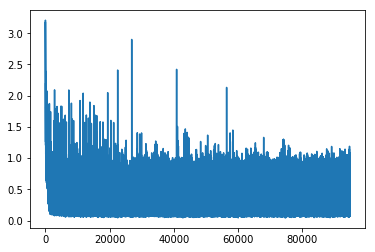

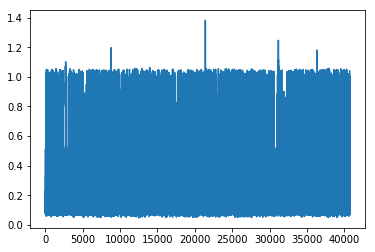

decaying  0.00048499999999999997
EPOCH 1


0.13568378952166577
0.13626747888124788
0.14849289764668674
0.14563467179493067
0.15281500437487028
0.1522465830032138
0.1515031567638505
0.15554410020535
0.15450608133345298
0.15337039813492337
0.15148782691656537
0.15405954562486854
0.1551241876301082
0.15474307824122702
0.15647048723133267
0.15696783044026827
0.15842020519636096
0.15635019104569142
0.15609548446686325
0.15596868920284443
0.15496952681650691
0.15395888016274514
0.15345518661412502
0.15415112790520405
0.15372227315963746
0.15766170441521724
0.15680827122706678
0.1565322690806287
0.15632802951973615
0.15616570576883024
0.15598669844301952
0.15550605318006167
0.1545981441667326
0.15549905996752703
0.15450382833532225
0.15864496692441127
0.15814087607521718
0.15795813259450073
0.15725726026293665
0.15711026058210728
0.15778302066546235
0.1588220807389711
0.15871760768379203
0.15815068353313205
0.15820930946009065
0.15872681047122078
0.15873337154947342
0.15847351271089485
0.15880754903784228
0.15841196089230086
0.1582285

0.1599119598464732
0.15983270082384257
0.15989709335040342
0.15993315735561256
0.15982170407851523
0.15981112727656335
0.15983057209116974
0.1598117904930549
0.15975064731768676
0.15980349977135355
0.15978113121810691
0.15987084885525985
0.1597680305149754
0.1597436934792445
0.15971237170138897
0.1596926396899503
0.15966768674395568
0.1596330578391942
0.15961273978218712
0.15958976167066485
0.15953259428021152
0.1595102835241504
0.15946972433425383
0.15941015767289063
0.1597092021871261
0.1596796265995926
0.15970110826291106
0.15966231117452187
0.15965334092260638
0.15963116719843665
0.15959355203258632
0.15953707336041548
0.15948198391856666
0.15944000820160056
0.15953344969104952
0.15947011239006675
0.15940759118645734
0.15938162488195354
0.1592938841970489
0.15969773943255028
0.15974821414471133
0.15967793175809633
0.15970629823073604
0.1596537576220183
0.15962637939385912
0.1595891154014235
0.15973639401423462
0.1597032329704943
0.15963336493406943
0.1595701978448018
0.159569921816

0.16077934721834664
0.16075028460731303
0.16076344612065796
0.16080137806052772
0.16086055236285618
0.16086948601562173
0.16085758679011525
0.16083855038686137
0.16081138986780044
0.16081946040158993
0.16079855043226537
0.160791600543041
0.16084924014199212
0.16081198632771257
0.16076779967592034
0.16080554615895798
0.1607908228969903
0.16078211961661987
0.16076296298448794
0.16074187939178722
0.160716593373405
0.16069626516607757
0.16066572189629666
0.1606350105743351
0.16058949507127634
0.16055472643707389
0.16054998605146698
0.16050183514530747
0.16045915734374802
0.16052144943674698
0.160487110047808
0.16047043167121178
0.16043117475523483
0.1604178941616422
0.1604841965864692
0.1615490042045313
0.16156032096917253
0.16154425971643882
0.16152831598739517
0.1615842803339198
0.16162560659266859
0.1615747382657505
0.16155945785585574
0.16157521431156321
0.1615698434929776
0.16156649928717234
0.16154882779618115
0.16160171386656436
0.16156470002185522
0.16152852097493736
0.161510600612

0.16068916174315012
0.16069947024626285
0.1606707474774604
0.16065975675044292
0.16067781639334605
0.16064549799462882
0.16062616350399253
0.1606284751095292
0.16060243801122
0.16056987455246677
0.16055891832991695
0.16052884160140854
0.1605162161918578
0.16051202866412065
0.16050734637262554
0.16048397306768597
0.16048431765370358
0.1605004060002307
0.1604821791200147
0.1604907178318014
0.16047939734708033
0.16050889828447773
0.16049594827828284
0.16049445804124524
0.1604823675852743
0.1605024462050069
0.16048274064885562
0.16046948131492011
0.16044260926080586
0.16048020244974723
0.16049601121546012
0.16048036872786745
0.16045343664560716
0.16049365170232552
0.1604672255972654
0.1604904196854717
0.16047210439232792
0.16045980722656777
0.16047329939949911
0.16049129379792582
0.16046531618290258
0.16047018350083178
0.16046612776241162
0.16043512224414058
0.16042617194862793
0.16041800417792487
0.16041385411334616
0.1603946655532809
0.16038275002399302
0.16039770156908384
0.160379116388

0.16009307940559994
0.16007080559840006
0.16010610424848576
0.16012121422560058
0.16010187735547593
0.16008771988735726
0.16006763536457466
0.16005772475600988
0.16004224162540254
0.16006138836594497
0.16004102992846675
0.1600195348865532
0.16001087564844088
0.15999137415025214
0.16001080270124016
0.15999392999600906
0.15998422392996
0.15999774500866382
0.1600302004898373
0.16005745951428355
0.16003917726417424
0.1600215369657168
0.1600528265994495
0.1600537455008593
0.1600503583889236
0.16012879822383444
0.16013117298048102
0.160125007297792
0.1601403515858151
0.160130334898506
0.16010755088710824
0.16009938325524306
0.16008128245888834
0.1600729236381159
0.16005065317506495
0.16003042201495898
0.16002225553615568
0.1600080510205256
0.15998722654219336
0.15996810501740497
0.1599482465199049
0.15992658973397839
0.15990832088490733
0.15989248730811123
0.1599247986792435
0.15990210663296664
0.1599151274090322
0.15989724767683067
0.1599433356745361
0.15993872143672572
0.15991838549398957


0.16027628043050327
0.16026921405688158
0.16025176685110187
0.16025119638481317
0.16027066223309522
0.16030226828214367
0.160406266650354
0.16039470671905856
0.16042035573734256
0.16045616508074217
0.16046416256651347
0.16047469575108186
0.16046402605505886
0.1604879103129122
0.1605084068872645
0.1605038036017582
0.16049558773278222
0.16051388987524606
0.1604994433690702
0.1604915520725597
0.16047854621822255
0.16047070950481002
0.16047416258341926
0.16046111296295
0.16047174485856364
0.16045863996622803
0.16044462399336568
0.1604511741589064
0.16044404324774317
0.16083086642013172
0.1608361597518749
0.16082105550019543
0.16084162628122448
0.1608228475341022
0.16080294390603242
0.16082585510011588
0.16081224376160363
0.16084243085109862
0.16083015239959172
0.16085475878323813
0.160860626114618
0.1608538729182522
0.16089253249209923
0.16087973132113761
0.1608881450679574
0.1608734661924033
0.16087657395280855
0.1608678910425041
0.1608535952993694
0.16087310819732828
0.1608749432022704
0

0.16059919787771584
0.16060229981163865
0.16059135340214342
0.16058176498810875
0.1605896577646107
0.1605868761768382
0.16057252762348073
0.16057869714878703
0.16056201691617977
0.160564082993577
0.16055894444461077
0.16055397437570368
0.1605403254603518
0.16053514368227265
0.16052758914685206
0.16052455055392248
0.16053196155530605
0.16054924711057753
0.16054594477652112
0.16054461865855832
0.16056983292236612
0.16059555850272048
0.16060036650027606
0.16059558494101556
0.16058930024416346
0.16060644133440066
0.1605940775556715
0.160582830946573
0.16058675985143672
0.16057279360509846
0.160559301326173
0.1605482338759614
0.1605466515970648
0.1605329619407009
0.16051996603895607
0.16052310786318644
0.16051005129042445
0.1605392193036888
0.16052377251150207
0.16051752156941387
0.16052600493051683
0.16053724451483184
0.16053076339906955
0.16051723401085413
0.1605103989697737
0.16051852868334232
0.1605257546781559
0.16050673075557198
0.16049940994639486
0.16048984161105434
0.16048367425077

0.16089175645722584
0.16090977753799662
0.16090208289079
0.16089371834781904
0.16088405787674837
0.16088539912760494
0.16087236726383683
0.16087039824029803
0.16087048591344139
0.16087924304865098
0.16086979926837536
0.1608684497963912
0.16086484534331713
0.16087404745960918
0.16087396184179933
0.16087158154846548
0.16088732406673212
0.16088998980220043
0.16090153267509064
0.16090863799177088
0.1609087417736162
0.16089860920492807
0.1608872829136196
0.16087953793131277
0.1608703736586478
0.16087344240579723
0.1608666409993868
0.16086708843913963
0.16088093087933608
0.16087273282071696
0.1608582828401543
0.1608399204394386
0.16083661750319925
0.1608335923205216
0.16084109815699751
0.1608294376205222
0.16081801315480276
0.1608111837316965
0.16080726516495938
0.16082083889382295
0.16082557247753465
0.16081928968671005
0.16086625784867997
0.16085735178769722
0.16084664639265406
0.16084003885955478
0.16083795510367546
0.1608530137168906
0.16085001594131965
0.16083591323059288
0.160827689472

0.16054379496614568
0.1605555515670938
0.16054610174443504
0.1605498270423226
0.16054540082753127
0.16053590072189286
0.1605474576336394
0.16053588039557296
0.16052486473547992
0.16051295920807848
0.16050314081595887
0.16050455204507802
0.16049149238072274
0.16048762397650335
0.16047437399593567
0.16047524349680034
0.16046212048578926
0.16045584975426824
0.1604493760536378
0.16045830330193575
0.16044276805314012
0.16045843124136067
0.16044593328194118
0.1604375606876622
0.16043616987188333
0.16045005663947526
0.160446403215363
0.1604394440673242
0.16044138724710202
0.1604526799344869
0.16044667652887604
0.16045164842372556
0.16044150721390743
0.16044997160546962
0.16047212568850566
0.16046813981681946
0.16046590956660492
0.16048326050558692
0.16048190841979545
0.16047479720674246
0.16049839567372173
0.16049153253017248
0.1604982341292334
0.16049160456926456
0.1604831317736096
0.1604922097104971
0.1605287577711627
0.16053796767831627
0.16053153288887675
0.16052299712960627
0.16051940192

0.16041535310576166
0.16041480802428645
0.16046562202245415
0.16048233938454845
0.16048700475569058
0.16048623884573202
0.16048459671101528
0.16048003272298372
0.16047620944669422
0.16046736661550645
0.16046590854745924
0.16045981194574277
0.1604707246598474
0.16047152204307744
0.1604699703713178
0.16046636294493602
0.16046408662058145
0.16047076703493657
0.16047844709934772
0.16047325210605043
0.1604726619831009
0.1604859217770289
0.16047568633524362
0.16046930255925776
0.1604784635992275
0.160469356302582
0.16047580043714807
0.1604659123255193
0.16045725997563842
0.16045442728804024
0.16044942000028495
0.16044170994310802
0.16043302713185703
0.16042621495233192
0.1604231094507802
0.1604222306935907
0.16041670807408
0.16040489502583502
0.16039285259211836
0.16038341099712233
0.16037707281454328
0.16037338937087925
0.16036469717998766
0.16036989812211136
0.160366369731835
0.1603546534072951
0.16036724580382827
0.1603593593035373
0.1603475950902377
0.16036093717539887
0.1606106120309509

0.16035461612594945
0.16034484299242577
0.1603359459517033
0.16032955552961872
0.16033444886767226
0.1603232154016162
0.16031378985233805
0.16030576215751902
0.16030378057802977
0.16029500201598637
0.16028395784734337
0.16029585638476523
0.16029263573884933
0.16029395644404082
0.16031761469237066
0.16031566865621308
0.16032733414094802
0.16033071619919595
0.1603235659712646
0.16031904069618602
0.16031662128552576
0.16032512153865436
0.16031719807643566
0.16033048830581698
0.1603258167006539
0.16032171073560147
0.16031159136307815
0.16031162700704124
0.16029960089758666
0.16028644182374824
0.16030080997111967
0.16031325177735165
0.16030054212365516
0.1602919646680803
0.16028763454804823
0.16029766741220636
0.1602887713943684
0.16029536815885762
0.16028368888279917
0.1602926147642728
0.16030212560959525
0.16031044032466205
0.1603300950725611
0.16032254168989601
0.16031797029810976
0.16032435576591525
0.1603207187545308
0.1603299961566203
0.16035604487164393
0.16035350592252318
0.16035614

0.16022551993007844
0.16021557641669507
0.1602101319855258
0.16020324661966587
0.1601953529114628
0.1601857295749435
0.16017944014028088
0.1601771264646276
0.16017518104294987
0.16017232636151896
0.16015988297350187
0.1601495060459329
0.16014594134448182
0.16015433695057105
0.1601478456214965
0.16014562217379114
0.16013849820696005
0.16014140715538938
0.1601287487088644
0.16014451677727715
0.1601342251844769
0.16012695292136253
0.1601162872350137
0.16011574824129782
0.16011614147650524
0.16011676379785408
0.16012509097144714
0.16011123325676946
0.1600988902945111
0.16009222197789924
0.16008744279654283
0.1600755354490815
0.16006757140760386
0.1600659907694088
0.16005392423987286
0.16005660756876683
0.16006475657729743
0.16005808566599777
0.16005922794647945
0.16005719590791714
0.1600534685535667
0.16007048916118172
0.1600662034199623
0.16007141821807647
0.16006515270053104
0.16005614025333217
0.16004413488385824
0.16003697873165418
0.16003104317689268
0.1600315022776011
0.1600177497003

0.1585935234210448
0.15858776722945997
0.15857450132346643
0.15856655182010024
0.15856281455793642
0.1585529388635038
0.1585479267215476
0.15853981578530543
0.15852542373042927
0.15852341945407317
0.15852330176875631
0.15852416720231216
0.15850765886635965
0.15849647610924106
0.15849244569930293
0.15848317978416473
0.15846231240486552
0.15845766125429522
0.15846517898729598
0.1584605453713039
0.15847627430537878
0.15846656887660562
0.15846405238207442
0.15846781775457294
0.15845543942823487
0.15845453151991867
0.15844933436641914
0.15843833986765393
0.1584482138964782
0.1584334631575849
0.15843996544415606
0.15842733990047347
0.15841074072531042
0.15840815972330344
0.15840568733433597
0.15839518527599064
0.15837918123673597
0.1583688885864295
0.15835478166453923
0.1583412105462417
0.1583347289276508
0.15832889388073015
0.1583126721278515
0.1583027543786786
0.15830536951808777
0.1582981570968493
0.15830443627190607
0.1583012914471094
0.15830324647381017
0.1583054311537599
0.158310069701

Accuracy =  0.9517373071738805
BEST:  0.12078689606445213
TRAINING:  0.1573347709769602
EVAL:  0.12078689606445213


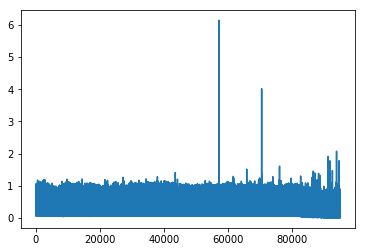

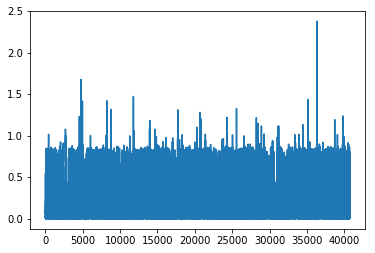

decaying  0.00047044999999999997
EPOCH 2


0.12698249478378495
0.12996923251359077
0.13602098271934088
0.13497911464642523
0.13329549820541003
0.126849266808743
0.12810377687782337
0.12638473847808657
0.13227090931772653
0.13286201947810422
0.13197196680948597
0.13302790286306262
0.1326138753085744
0.13139073010093472
0.12821854266069463
0.12693883495926264
0.1259384951149756
0.1232264120155967
0.12227702175162669
0.12335214016976716
0.12304643682180331
0.12306915682662117
0.12118190289608918
0.1204239213724502
0.12342970281341917
0.12401224575537574
0.12398938174710383
0.1254923392368528
0.12456589630449139
0.12573897328688136
0.12623075247362028
0.12528682568300217
0.12608415034120973
0.1266357203686118
0.12663118559306222
0.12639966803482308
0.12750535857474252
0.12711589704258244
0.12710702050931383
0.12761640672943228
0.12676877601738284
0.12630449550277809
0.12601023728359706
0.12535497663814868
0.12633346592565503
0.12593429316192656
0.12508467885579175
0.12509398724516302
0.12681911109011823
0.12743058771533777
0.128074

0.11405067961022665
0.1140497832818773
0.11393241428958584
0.1139050082037218
0.11382847916499389
0.11379997102245282
0.11381150787808252
0.11380616268429189
0.11368232977612665
0.11378910298709456
0.11377526683065076
0.11368417425584619
0.11400306096812102
0.11400520872220268
0.11387317439139769
0.11388456305966338
0.11381445767925602
0.1136951279994889
0.11360968163418005
0.1136542648746443
0.11372188903889956
0.1136920554163418
0.11361998400864905
0.11350201301851641
0.11341544865392399
0.11355882114693436
0.1136173561400639
0.11349509992962126
0.11347524915548565
0.11343705105696143
0.1133317313557146
0.11337861225485824
0.11359929329022421
0.11354010820312019
0.11345538505517618
0.11347959511463226
0.113391416278187
0.11343481593499218
0.11328753208691972
0.11323230552108808
0.11315216786752647
0.11316200461174178
0.11308767628068235
0.11304816360040391
0.11318079521081222
0.11339783744240596
0.11349177903996603
0.11402923960440939
0.11398784814404717
0.113864715746672
0.113737323

0.1101224150354937
0.11006318329753552
0.11002582722618423
0.10997505682527958
0.11013628192306116
0.11010008347811893
0.11008367693566415
0.11001286777647909
0.10999569084914083
0.10992313720960384
0.10990825044645328
0.10988073862653734
0.10986896113297799
0.10985571051373094
0.10978602994015668
0.10969600205943561
0.10963717281727643
0.10964690981441708
0.1096262233764882
0.1096673073109566
0.10964638407928069
0.10966486322677402
0.1096441851869252
0.10955876014128647
0.10952307627443852
0.10943361579616055
0.10939195038019733
0.10935092304794655
0.109537193524531
0.10951982747670841
0.10949713983116224
0.10951537268385644
0.10959277929377778
0.10955520788147735
0.1095278747311966
0.10952139748585948
0.10947528762628889
0.10943652573418496
0.1094142335955955
0.1093949191199542
0.10935623302494679
0.10928152029937922
0.10929148938890117
0.10927382176024808
0.10924359688777005
0.10917429043862542
0.1091292043359677
0.10920810678358985
0.1091692781266761
0.10919777638044181
0.109177233

0.10446693163384654
0.1044595788194215
0.10444183057762184
0.10439943436328429
0.10439260382659053
0.10436152556562983
0.10442221681176336
0.10436910629895056
0.10432936136450982
0.10430400844476019
0.10428072308532035
0.10425538844294033
0.10435835915825653
0.10435992433615753
0.10430294524638337
0.10428244586820483
0.10423258683760278
0.10421124983363146
0.1043996475829288
0.10444110173692439
0.10441356672569722
0.10442038030472237
0.10440720242453115
0.10442312507198538
0.10437671561358738
0.10438442281200837
0.10434278875385126
0.10430601712747278
0.10432642477638437
0.1042959108555191
0.10425514092322533
0.10422296434031424
0.104227527329034
0.10425594739377624
0.10421896936513646
0.10418224466250182
0.10413703694547206
0.10409727422426295
0.10414344075395475
0.10411313800366279
0.10407182321380497
0.10411780333569355
0.10410740927921372
0.10416021822855241
0.10425103623647165
0.10423625481584602
0.10416884630998902
0.1041349333972248
0.10408206331494499
0.10405155578781786
0.1040

0.09788996320378303
0.09789146027900297
0.09787532856788053
0.09785855537635596
0.09782043405000906
0.09780639177112498
0.09776505009776222
0.09773101882537996
0.0976863727942609
0.09768302492602213
0.09764861148521128
0.09761727943993206
0.0975816844799095
0.09758156197986478
0.097564424083614
0.0975366226315209
0.09748668922110992
0.09745840673712003
0.09746022589373192
0.09745355884446302
0.09741502317232321
0.09742662440023224
0.09743529689440938
0.09745023935978094
0.09746469554163303
0.09743824306086238
0.09744822845494905
0.09746439473150162
0.09743321014244583
0.09741366278636972
0.09736598071099048
0.09731844347407585
0.09728221707598485
0.09725088980963753
0.0972188590189529
0.0971862135048837
0.09715242964355573
0.0971409239565362
0.09712784670938442
0.0971392905892968
0.09724289403096167
0.09723985560962738
0.09723242215369314
0.09724477599980733
0.09723951545620817
0.09723506692808614
0.09721752993192255
0.0971978230841118
0.09725350014040668
0.09722659693011741
0.09718896

0.09170598109927652
0.09168752391092362
0.09166520633172713
0.09164690016749084
0.09164855695814371
0.09162353739088717
0.09160788566228484
0.09159809590309033
0.09158231834720888
0.09154685359024767
0.09151234848960035
0.0915043263610431
0.09149957226495233
0.09147360174844575
0.09146723114445986
0.09143697539420043
0.09140896534320218
0.09144977515344624
0.09144424966876201
0.09143046050675836
0.09143116116770758
0.09142654127514525
0.09141231236933756
0.0913847624036318
0.09138133448629002
0.09137898302463072
0.09134910449509806
0.0913323552312147
0.09130582723288175
0.09131191464776559
0.09129522271765807
0.09128573803727191
0.09126171236250792
0.09124434910740098
0.09123161406022635
0.09120404259998043
0.09119815355927499
0.09117923435405688
0.09115097228249855
0.09113397785325145
0.09114055962729582
0.09112724832196802
0.09112285938633771
0.09110488183473728
0.09109210024812066
0.09107914086290213
0.09107380939501919
0.09106186462709635
0.09103220558069075
0.09099991584444196
0.0

0.08604523044150739
0.08602984515333385
0.08599854383434123
0.08598103640478366
0.08596618590237803
0.08595908711761556
0.08594622317950748
0.08594781717669753
0.08593753909824965
0.08593568672656354
0.0859688745841628
0.08595153317020672
0.08594971301409188
0.08593699906737903
0.08591858738211199
0.08590463441390007
0.08591670873473223
0.08590818905219544
0.08590008885897829
0.08588004073069083
0.0858722750031206
0.08586699070552013
0.08584538600677473
0.08584741484733327
0.08583942311773105
0.08582879174540585
0.08581188149741797
0.08580329294786705
0.08578328766068403
0.08578122255548717
0.08575600311757209
0.0857495271172543
0.0857193761188481
0.08569634542669996
0.08567825000678725
0.08564588759787611
0.0856263220588595
0.0856185906691708
0.08559295596658655
0.08557343558047337
0.08554615949868219
0.0855268112542431
0.085496855371124
0.0855192576792574
0.08553470638856886
0.0855117936054108
0.08549780987031967
0.08547187424091024
0.08545891191184109
0.08544077788192127
0.085426878

0.08151019717597785
0.0815058428725189
0.08150426277189093
0.08149420088366602
0.0814936728359589
0.08147621227684934
0.08146195330062139
0.0814405324851798
0.08142348799655313
0.08141986387300855
0.0814308271798523
0.08141355237033769
0.0814046853728106
0.08138139747229531
0.08136816135712684
0.0813464509694635
0.0813393229974141
0.0813348131152919
0.0813160382852963
0.08130740582667452
0.08129848131608342
0.0812982500259912
0.08128088012286382
0.08126536240069081
0.08124026757695986
0.08123206530438608
0.08122621355993843
0.08121583655441335
0.08119829458200109
0.08119117847370705
0.081172023357144
0.0811578896151976
0.08113622745993734
0.08112018742881846
0.08110735440147629
0.08109584643980915
0.08107674872815404
0.08107002005811399
0.08107693970803065
0.0810789059976839
0.08105788994550595
0.08103115037009302
0.08102427494360102
0.08101682329410562
0.0809845610337861
0.08105022186567266
0.08104759413527568
0.08102983479175158
0.08100938069254628
0.08102076670487153
0.0810068653803

0.077847538931553
0.07783790500382153
0.07783079103306681
0.07781458430869959
0.07780321023010123
0.07778685565692679
0.07777017695378725
0.07776533165716171
0.07776068132710821
0.07774582451376782
0.07773736605598477
0.07773492338834564
0.07772703011230296
0.07771237545817704
0.07770702309998113
0.07770928142404397
0.07770085991044524
0.07768732325269159
0.07768784171259895
0.07767823922406938
0.07767121164591248
0.07765995884374785
0.07764957759172476
0.07762797583206762
0.07762181895548131
0.07761524230035105
0.07760313363346386
0.07759312507120213
0.07758434922639658
0.07759128029966106
0.07757384319250486
0.07757662482553675
0.07756209574903855
0.07753847926794817
0.07753126639954007
0.07753531537982365
0.07751868379855982
0.07749907662232534
0.07749300122911061
0.07748017127116454
0.07747165970730988
0.07745854392096085
0.07744612945409972
0.07744402917760007
0.07742331326691854
0.07744943807326593
0.07743897814536313
0.07742881868712621
0.07742621776402844
0.07743172291981343
0.

0.07464609349433554
0.07463280948063648
0.07462817594157893
0.07461172801471111
0.0746016607324575
0.07458845037979263
0.07459508457889621
0.07458413855183449
0.07458041222806616
0.07456596801608191
0.0745526707840666
0.07453726064675723
0.07453512685039333
0.07452085183412197
0.07451719632668281
0.07451114735978913
0.0745061725502628
0.07448393808841088
0.07448060197702044
0.07447065560277077
0.07446867044196888
0.0744520269469861
0.07444420747802655
0.07443430907495172
0.07442284594285868
0.07441454478150718
0.0744064105639086
0.0744017799996393
0.0743838993527792
0.07437512346235531
0.074369588279362
0.07436723891762292
0.07434948858684051
0.07434508659805415
0.0743367289129827
0.07432737238006978
0.07431620203937603
0.07430350191221466
0.07430323714086749
0.0742857164191113
0.07427115237646743
0.07425454192697052
0.07426898241419161
0.07426078591400245
0.07424781867761142
0.07423010752067054
0.07423197521958236
0.0742198854572171
0.0742190243828837
0.07420161215783821
0.07420464505

0.07160702837066289
0.0715933699413671
0.07158535157997019
0.07157500613077429
0.0715559548289911
0.07155005731594778
0.07154173665764968
0.0715325422360411
0.07152902111642824
0.07152239315137104
0.0715213987387459
0.07150718673110282
0.07149694689444416
0.07149539019594425
0.07150216964338078
0.07149709490851168
0.07151088645187972
0.07151103995189924
0.07150416751200131
0.07149752862650709
0.07148155678187415
0.07147776028529125
0.07147501552184767
0.07146318244974152
0.07144735854270709
0.07143378710102073
0.07148248134823788
0.07147202489516218
0.07147762429423181
0.07147183156971527
0.07146405729901734
0.07146102037030681
0.0714493324591439
0.07144044471706404
0.07143390666640187
0.07142700487998949
0.07142380343100768
0.07140933353039565
0.07139852155040922
0.07139323264092928
0.07138540637033046
0.07138087977435227
0.0713677209267214
0.07136447884586625
0.07136019392526481
0.07135596878647268
0.0713427210779932
0.07133438211361966
0.07132513059091071
0.0713112610775264
0.071315

0.06918883695148394
0.06918544155219865
0.06918327572224649
0.06917846279997937
0.06917019587797238
0.06917356981740225
0.06917028544155975
0.06915909297353116
0.0691548979200607
0.06914377982337643
0.06913633296398704
0.06912171023549088
0.06910876822118092
0.06909834255887859
0.06909279231613916
0.06908739100044052
0.0690841881892908
0.0690736719595727
0.06905930034499472
0.06905236211499755
0.06905329654435782
0.06903710578156184
0.06901940749151478
0.06901306502158003
0.06900252240837537
0.06899526638614867
0.06898798874694972
0.06897792589577595
0.06898174148874867
0.06897800220740383
0.06898414804606769
0.06897065860121428
0.06896086740751203
0.06895017841327404
0.06894569716408555
0.06892884893558497
0.0689192139504337
0.06890806111805373
0.06889930475504279
0.06888907074693532
0.06888018439107266
0.06888015329859444
0.06886744236013903
0.0688605231024754
0.06885903441746939
0.06886832801517365
0.06886760941610924
0.06885731141012698
0.06884693850609273
0.06884807231687146
0.068

0.0670541389995117
0.06704477102381488
0.06704525698787087
0.06703860548996818
0.06703739534813308
0.0670272314425312
0.06701971730258499
0.06702052834794188
0.06700921348739843
0.06700184379407205
0.06700009974673127
0.06699260470990238
0.06698918755018865
0.06697942926857978
0.06697068324112859
0.06697447835885968
0.0669690821685838
0.06695803610531884
0.06695152423280412
0.06694642070928142
0.06693527065170692
0.06693352162768149
0.06692491524503821
0.0669139342069959
0.06690629195408589
0.06689594847343261
0.06689141058672515
0.06688579514034391
0.06688588093536385
0.06688321454033141
0.06687391887853993
0.0668780861965839
0.06687677375781625
0.06686854402395108
0.066858715137969
0.0668528688298792
0.06685132458048043
0.06685035100261577
0.06684222721853676
0.06683338371200175
0.06682853503740974
0.06682283257004092
0.06682028298861308
0.06681377140670487
0.06681480917190726
0.0668114959696954
0.06682055741237672
0.06681736487846845
0.06681050488605261
0.06680046428796875
0.0667918

Accuracy =  0.9956192901003444
BEST:  0.04078968038037412
TRAINING:  0.06598251072354978
EVAL:  0.04078968038037412


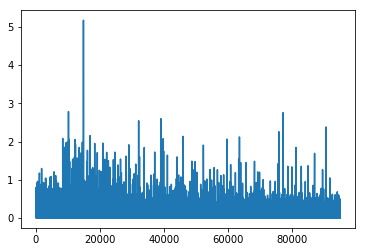

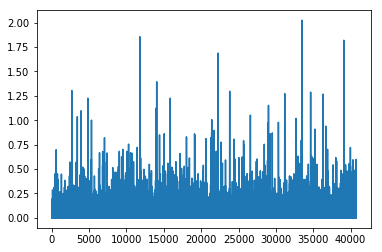

decaying  0.00045633649999999996
EPOCH 3


0.036751706442250544
0.03777863151095611
0.0594417941336664
0.055122164477032234
0.05195303988344281
0.05292493067114796
0.05190417667557258
0.05118608680251974
0.048886766107520255
0.04759671458311742
0.046186743860627724
0.04449670627765721
0.04611470415862557
0.04472605180691639
0.04370382806567193
0.04240558983880288
0.04308504617794593
0.042042500941587485
0.042079910319349344
0.04206167793915063
0.042203821025333224
0.0418347146253838
0.04123137214333243
0.04111809607478985
0.041313328252208584
0.04277308347843581
0.04262696035506647
0.04204755906208408
0.04194160677008249
0.04290875229232103
0.04296684680462593
0.042829539184139113
0.0432350761827269
0.043212656388036605
0.04372882301676785
0.04359685906141776
0.04448467566227744
0.04427360367218831
0.04443167524611044
0.044596202488191114
0.04509522709790548
0.04453982425747692
0.044548553155817155
0.04538037339381025
0.04992872989866353
0.04929956413602251
0.04913044049966745
0.048585253074154434
0.04928859600365583
0.04931144

0.04332454397705142
0.043298075407544226
0.043217711824652984
0.043165883270064875
0.04320626425359894
0.043222025009541226
0.04323071249441675
0.04327277283184623
0.04325649953648586
0.043278832329054995
0.043280492263454054
0.043310576697535054
0.04324333025478395
0.043226799316444395
0.0431777014376948
0.04315589645947859
0.0431508696096102
0.043171932382591156
0.04311271623341194
0.04307366417749491
0.0430769467358695
0.043034536839368726
0.043002257089362304
0.04307466594117714
0.04307267780138731
0.04303531466127791
0.04303053766121093
0.043010870996169875
0.043022400093132775
0.04297428268686693
0.04302896808476183
0.04308201121473013
0.04310004664639851
0.043100423670107246
0.04309264000428873
0.043042069652722524
0.04305360651176993
0.04300385414293981
0.04301607274873413
0.04301106464817308
0.042984513198991145
0.04297241401409405
0.042953393226549036
0.042962461684641254
0.04295662625523126
0.0429495334939823
0.04293756055312363
0.04292884503451512
0.04297043530310484
0.0429

0.04263725190383858
0.042616782267340884
0.04260896197527686
0.042599052437554547
0.042593866410002006
0.04258313990110975
0.04258367854599424
0.04257060374450246
0.042578644723542614
0.04257011090651562
0.042568791330818305
0.04254872883323888
0.042516127784606145
0.04246822331258514
0.04246398612280362
0.042448926674506365
0.04243031762921702
0.0423839341874839
0.04240373704344794
0.04239340922662993
0.04237259504341696
0.042377045289143614
0.042365486148586554
0.042371773220332316
0.0423460206272663
0.04232976122223774
0.04236170906429181
0.042330660099067004
0.0423183501356876
0.042296854498784085
0.0422636033219301
0.04225306248139098
0.042267501956269694
0.04225774444611786
0.042247567777930296
0.04224093769979934
0.04221438821373077
0.04220689654617499
0.04223994674831985
0.04223512931598798
0.042278986987069576
0.0423055905741363
0.042291847121822004
0.0422854761259794
0.04225771596585393
0.042262082224044685
0.042279763571831615
0.04226077352841338
0.04225440612999846
0.042246

0.04198120154199872
0.04197291205425743
0.04195181173362536
0.04194743901072531
0.04194771549828683
0.041934614387723446
0.04195851653273095
0.0419448840874016
0.041929631762555056
0.04192312788581234
0.04191674777026653
0.041945936174397826
0.041934992720814454
0.04192816423973391
0.04191711031409382
0.04192907495888836
0.041916839600248744
0.04189663659771296
0.04189339706429372
0.04190836882956379
0.04190066034221521
0.04188580900355758
0.04187492716686756
0.04198025151831066
0.041961549679488265
0.04196292017439272
0.0419669067659549
0.04194883146531865
0.04195655943132658
0.04196022013861159
0.041950566725109564
0.04191897574586102
0.0419167726898651
0.0419086848348669
0.041905436902367435
0.041882705878726924
0.04187869042698108
0.041874357928984494
0.04190213319700296
0.04189179221643869
0.041896957974541994
0.04190233773993927
0.04188337780201028
0.04187875873406971
0.041872287786659225
0.04186397324964238
0.041836410850270185
0.04182954043246632
0.04183299333965456
0.041843662

0.041786288356017776
0.041793445935900626
0.04179812868166032
0.04178694800340335
0.04177489976750366
0.0417703466077132
0.04176026859043695
0.041755996072466633
0.041745570756084614
0.04175041682144027
0.041744712896356916
0.04174245012646401
0.041786232083147044
0.04178002300912631
0.04178922751093048
0.041789131720481605
0.04180552709853372
0.041813803654090445
0.04179462826559923
0.041805475105774016
0.04179587696791799
0.04178390095497197
0.04177166299178025
0.041772002580483934
0.041764965416131436
0.04175732542804144
0.04175273588717809
0.041748290523460664
0.041752492534063705
0.04174180752401463
0.04173037114283494
0.04176151079210624
0.041740330968841395
0.041736001437865204
0.041731740765690244
0.04173864954150036
0.04173989989833281
0.04179347627313443
0.04178560867954512
0.0417707538108085
0.04183514858410833
0.041843809594923655
0.04184144649598472
0.041833603589066286
0.04183881202540621
0.04183659586955879
0.04184349465825487
0.0418438183753407
0.041830821698258636
0.04

0.041879227274593735
0.0418716923025266
0.041901335664665244
0.041897828638258604
0.04188804120513795
0.04188286544198883
0.04187854384273864
0.041883452060145675
0.041875511498564555
0.04186202202162199
0.04185213871331885
0.041857269506155904
0.04185263535198085
0.041848796349049026
0.041842327268768915
0.04184348201765464
0.04185179917263935
0.041864076469255676
0.041853367093352536
0.04185625449479419
0.04186159603122242
0.04185969445731025
0.04185076074472635
0.04185122823803445
0.04184462846534662
0.041836497609158585
0.041869696137542385
0.04186603712880572
0.041876564995386584
0.041864135936979886
0.04185781315315244
0.04189078562421055
0.04189665128655679
0.041890227733233025
0.04188823295495809
0.04188551916196367
0.04190082121209336
0.04188983531451294
0.041890152626165064
0.04189677959562046
0.041910273667841655
0.04191018649230647
0.041911797361971856
0.041912271916251825
0.04191581572094593
0.04191178521440137
0.041902400964991204
0.04191681024061511
0.04190987599535643
0

0.04165704176211227
0.041648806733095796
0.04166211785114765
0.04169207071922679
0.04168227421227469
0.0417420129256592
0.04174147607766695
0.04176014077025252
0.0417579892882342
0.04175660688222533
0.04176434664458717
0.041763968180664565
0.04176967999514901
0.04176931234251033
0.04176872691885877
0.0417663428881271
0.041766801534591565
0.041762654410061405
0.04175936353230938
0.041757814350689315
0.04174456121211818
0.04175439124874566
0.04174972657484162
0.04176027387774581
0.0417616692408599
0.04176165600663775
0.04175613983008118
0.04175099482189147
0.041746015554301914
0.04176478014986944
0.041764199887946406
0.04176413718779524
0.04176290204824815
0.04176414003458018
0.041763760500128144
0.04176205418339435
0.041765392797833326
0.04175631722942609
0.04175713503750474
0.041753659272200136
0.04175855243311522
0.041752783079578706
0.04174420440461672
0.04174505857264964
0.041764830630183915
0.041764419072568226
0.04176102329861112
0.04175374383630194
0.04175007724097418
0.041752535

0.04147699089425004
0.04147825724270396
0.04147577759762046
0.041481047782028664
0.041477337307628044
0.041478569231200024
0.04147743407921514
0.04147402503459995
0.04147977884182338
0.0414825081037764
0.04148234712609984
0.04148583081384829
0.04148653958967669
0.041485323715381564
0.04148147064739164
0.04147277947411752
0.04146738563507173
0.041471109660074126
0.04147089675348538
0.04147266048533909
0.04147081613289762
0.04147036186107171
0.04148027301869944
0.041485069647951546
0.04148841083393775
0.0414853617411053
0.041479934834653946
0.04147639356781968
0.04147492353385705
0.04147031296786325
0.04146474227916158
0.04146030238715465
0.041458175126385
0.04144800108445838
0.041439634701069934
0.04145967249945903
0.041463593112359344
0.0414575156106802
0.041457362351272446
0.04144704679959417
0.041439486634555385
0.041433308340715985
0.041424031081837336
0.041423397203671115
0.04141502439252538
0.04140742490238147
0.041403451130495185
0.04139809597590383
0.04139109528143455
0.04139276

0.04125981781396965
0.04125011177301544
0.04125464329170554
0.04125087754687584
0.0412511485206869
0.04124750694306232
0.04124053547648795
0.04127451284469517
0.04127013314096219
0.04133042462614731
0.04133252933008137
0.0413265455279763
0.04132401217898732
0.04131846826745556
0.04131619039902025
0.04131426799751571
0.04131497520127416
0.041315080398102735
0.04130919349779004
0.04130688391310177
0.04131182402055153
0.0413045394505152
0.0413033786562963
0.041312332228203394
0.041316716171915985
0.041344228439064386
0.04133852150177978
0.041334955859396824
0.04134583491248171
0.041340184820287215
0.041335118370006856
0.04134125635945367
0.04133998497964428
0.04134146789186963
0.04134123794528627
0.04134040288618293
0.04134460973801712
0.041341872072128805
0.04133852783543655
0.041331448872179294
0.041332813869149804
0.04133402356610533
0.041324602209552724
0.041325762943958885
0.04132124047545954
0.04132172551839584
0.041326659603214716
0.04132572270499779
0.04131318225795157
0.041309198

0.041107591122519084
0.04110885092343031
0.04110953976999354
0.041121470651050276
0.04112126980672451
0.04111701093763155
0.041115277616562994
0.04111490774091598
0.041109090613498205
0.04111025998700134
0.041108645492908095
0.04111139921456801
0.04111942950527117
0.04112229407834094
0.04111908614931886
0.041121781063738996
0.04111416747776458
0.04111105185222381
0.04110825637845129
0.04110274317310792
0.04109876397431064
0.04109969240807468
0.0410952931566108
0.04108605345593897
0.04108912705606658
0.04109892438201589
0.041101615114386265
0.04109753435671615
0.04109856646116968
0.041097240537990846
0.04109207311313982
0.04109535492296296
0.04110115444687782
0.041099753267789495
0.04109927080603123
0.04109937859075625
0.04109755832041868
0.041102073160446936
0.041099680182626774
0.04109896412689194
0.0410957966885444
0.04109521358739451
0.04108840644878723
0.0410891321009293
0.041085557827490175
0.04108219633456231
0.04108022891321907
0.041080547748508695
0.04108681163547012
0.04108918

0.04143092547602322
0.0414319507851444
0.04143102362488369
0.04143517804099945
0.04143662773814803
0.041443192371292396
0.04143461700019877
0.041431528107397565
0.04143045884157207
0.04144069580796275
0.04143734579161863
0.041434147346894004
0.04143759051726901
0.0414442900526577
0.041444381359912456
0.04143916767814204
0.041438176720339205
0.04143413211429762
0.04143136403548546
0.041430605467760166
0.04142966028952145
0.0414378120207581
0.041443241360866356
0.04145002425141678
0.04144602588428135
0.041456817829666065
0.04145385995842564
0.04146026335265114
0.0414600496568003
0.04145948865943329
0.04145934265068799
0.04146523436138081
0.04146698678162529
0.04146327353179185
0.041471210991220184
0.04147058087297182
0.04146777390953701
0.04146704196838431
0.041461704205485374
0.0414609009960808
0.04146383006766153
0.041455128308448684
0.04146000800180772
0.041463967396998945
0.041458311063624596
0.04145981152932099
0.041457375933325685
0.04145882927629598
0.041453178034413556
0.04145274

0.04129616689803956
0.04129544811104505
0.04129314125070567
0.04129318031924697
0.04129729623336489
0.041314702431198
0.04131680849191444
0.04131968530704635
0.041327578171412284
0.04132960368707096
0.0413273287357344
0.04132308582088528
0.041319670916492336
0.04131873735632906
0.04131884695394406
0.04131861076896801
0.04131853153472192
0.04132240942869638
0.04132125354505886
0.04132109373165743
0.041333732896412026
0.04133637179216062
0.04133951203499767
0.04133834260103712
0.04133872532532784
0.04133298920590438
0.04133437244357626
0.041334538592170816
0.04133394111410178
0.04133058257784905
0.041326018637489456
0.04132457677435655
0.041330458195160194
0.04132640544399911
0.04132658562736964
0.04132691460846391
0.04132794449242156
0.04132301478196377
0.04132316511811966
0.041317952603292414
0.04131935058494554
0.04131843833359677
0.04133078646052739
0.041329613737262134
0.04133032318431332
0.04132629784034429
0.041321694580992184
0.041324447145324975
0.04132588485941254
0.04132591380

0.04126865285105935
0.04126882457299692
0.041274401400343795
0.041277115048688674
0.041274260536417265
0.041273943365228466
0.041273582524264676
0.04127233121833537
0.04127247778863009
0.04127318178256375
0.04127239513182813
0.041270027463747895
0.04127111012357378
0.041267814718366734
0.04126557176930669
0.041265848544691515
0.0412726613504193
0.04127560328168033
0.04127088936474874
0.04126799146504652
0.04126965769735183
0.04127275240471176
0.041268429314229756
0.04127328103555653
0.04127640840029738
0.04128101591232239
0.0412795719058604
0.041276541463236685
0.041279077730871305
0.04127724891502357
0.04127609060974392
0.041274255882986506
0.04127242573349878
0.04127731241196085
0.04128064254540319
0.04127806072519625
0.04127084727927056
0.04126459351246906
0.041266794444169363
0.041264717986936206
0.04126146683497904
0.04126460412085768
0.04126076911947932
0.04125739872246919
0.041254324726293375
0.041252857740675566
0.04125455580116878
0.04125401504690008
0.04125319980696448
0.0412

Accuracy =  0.9969672008387
BEST:  0.041248216521412466
TRAINING:  0.04128133088608616
EVAL:  0.041248216521412466


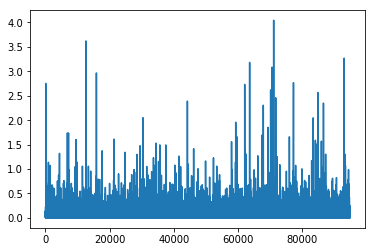

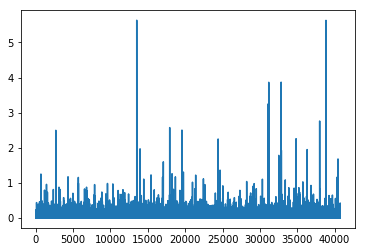

decaying  0.00044264640499999994
EPOCH 4


0.04666640247531892
0.0516201965395707
0.04886942297217017
0.04547941290731606
0.04479981566878911
0.04331297378738832
0.0412848278998112
0.03892629309473251
0.03740333235628356
0.03685750731847901
0.04069782855510106
0.04117206958162689
0.040382048916607474
0.039135322872256295
0.04028921098321947
0.03984209988347724
0.04099202340467525
0.0425876650601821
0.04102813349854486
0.04053227774905156
0.04074705225652677
0.04053476488127583
0.04123788049000818
0.04139964048144951
0.04193792163040856
0.04152376460136391
0.04078570262743697
0.04094368567885688
0.04101057377548549
0.04015912947817482
0.039755013321230534
0.04156806420652885
0.04170483480064185
0.04119441195337834
0.04092078105610178
0.04122249112205944
0.042289345526246136
0.041786824200815365
0.04209703868940409
0.04161038931925029
0.04122902052890419
0.0415433528203153
0.04153554453479669
0.041686963869581865
0.040901727323226986
0.04072760148322656
0.04103183435075769
0.04096779191512448
0.04032928193096837
0.040078729869262

0.03907361647168777
0.03905038742249387
0.03896412676762661
0.03902604851910712
0.03896047787082696
0.03897246884920131
0.03902102753755561
0.03901376023145608
0.03898637331199245
0.038993471245165466
0.039045407234509485
0.039047215588725474
0.03905193138528832
0.03903945165128696
0.039074275476924346
0.0390100704165653
0.03900111587914095
0.03900307554997066
0.03902882592692683
0.03901123729955125
0.03900133682990792
0.03898062020577046
0.03893819220787714
0.038914518302857325
0.03888769484394695
0.03887086659103378
0.038882402552887003
0.03889529851671087
0.03893003174145004
0.038996250857961656
0.03896334034968612
0.038925379685054017
0.03903760396105265
0.03904337824499091
0.039008939696096735
0.0390990241866939
0.03915475106935726
0.03914928222070602
0.039125854670423524
0.03915427285733043
0.039128149805513386
0.03982478797698097
0.039808470837785104
0.03997818533029145
0.039954916489967164
0.04001416825522056
0.03998403444996467
0.03995262780303062
0.03990799417949234
0.0398643

0.04046606074575862
0.04048272594988115
0.04048449269437206
0.04046937411165394
0.04047958655478096
0.04050695493377916
0.04056208863447346
0.040584086233803975
0.04056879161112624
0.040560903668832686
0.04055962072007673
0.04057313355660337
0.04056633032097666
0.04058359608838516
0.04064169198402979
0.040639369119254413
0.040611506678078856
0.04059876275913876
0.0405628115826059
0.040563328760800446
0.04054261429887052
0.040522769447987515
0.04055027037795483
0.0405891172663136
0.04056450379273903
0.040581412671356586
0.04061427862538527
0.040590546619193243
0.04054158233374621
0.04055401864240501
0.04056546621279101
0.04056405963490437
0.04054198368486543
0.04056849905085315
0.04056408883693449
0.040561496739263146
0.04054880667126473
0.04055297247870995
0.040578668127180015
0.04056140554204589
0.04054776561815679
0.040534310516586104
0.04052145896442846
0.040497636499269234
0.040489377187038475
0.04049043028089174
0.040480781500714214
0.04046494273127314
0.04046608711113831
0.040471

0.04048283870406377
0.04048166464503267
0.04049100329485738
0.04048254760826182
0.04046031633252455
0.04047814719535549
0.04046654502585713
0.040494723703770344
0.04048928268149183
0.040475856244627004
0.04046838786823584
0.040470794247723
0.040470509800368176
0.04053556740090042
0.040528497427885425
0.04053580085467303
0.04054796167848428
0.040540288392038215
0.04055302311578586
0.04052543054426817
0.04052178809204668
0.04052634175630807
0.04052962170446951
0.04052613337808752
0.04050113889942539
0.040507021655055424
0.040496714459603116
0.040500932870852546
0.040510170738284355
0.04050874972985686
0.040514048045696395
0.04048594539480045
0.040481100059886074
0.04048919413788327
0.04050071674980304
0.04049836963136856
0.040502298717886284
0.040517727700284105
0.040507094911832124
0.040499855325727134
0.040499930373031845
0.04050028686787571
0.04048369995897363
0.04049653247412151
0.04047266176410291
0.04047178960343575
0.040454877524420854
0.04048242963273463
0.040465929622965364
0.04

0.04071450262004779
0.04070929802745517
0.04071312962128756
0.04070897245448934
0.040695991433306974
0.040681233515123025
0.040672107894827746
0.04068202837567765
0.04068417894253151
0.04066894093001258
0.04066486143559563
0.04065374819614033
0.04067349041298875
0.04066129610940287
0.0406611057955525
0.04066271154800052
0.04066053107107807
0.040653403588472824
0.04064588059247315
0.04067131866795915
0.04067926547837628
0.04068085137740394
0.04069378479150612
0.04068954231554186
0.04068993428635696
0.04068552311583409
0.04067785030511607
0.04069406035549498
0.04068467402559963
0.04069441816418688
0.04068259349484916
0.040669161626459435
0.04067751467920065
0.04067134982446613
0.04066207348113772
0.04065817634905103
0.04064895397995368
0.04064547254555847
0.040644681815803343
0.04063009454109462
0.04062427756881136
0.04061792139622873
0.04060857544412554
0.04060836012789008
0.04060684754834591
0.040604175157450455
0.040587581097316326
0.040594707802210236
0.040583352438733206
0.040597508

0.04140791555252174
0.04141225456467972
0.041420953470741616
0.04140714069455247
0.0414007782460025
0.041404571053662874
0.04140026556799107
0.04141001138786482
0.04141231952653043
0.041409370066243546
0.041408345445117484
0.04142941087771676
0.04143589058465527
0.04142566314755521
0.041413968815424196
0.04140677299021317
0.041410136704976945
0.041416237211600815
0.04141136153453739
0.041404309052073374
0.041390438074918566
0.0413810859676385
0.04138334324852657
0.041384740592736995
0.04139764151600976
0.041385868687952417
0.04137569394408532
0.041367035106026136
0.04137390803040266
0.04136987069765598
0.04135929393330373
0.041358885634429424
0.041346765438182
0.04134408214410939
0.04134889527015033
0.04134100488969762
0.041338289057287286
0.04134429280872735
0.04136635459742452
0.04136513522027713
0.04135418666686409
0.04135383085762325
0.04135562935851231
0.04134480083603775
0.04133813655429485
0.04133655469862223
0.041331483644400854
0.041334487783949485
0.04133399393119773
0.041338

0.041479274624980314
0.041485041837167815
0.04147971124386211
0.041479189830373964
0.04147208650838701
0.04147310648863823
0.041464101074533105
0.04145965229881569
0.04145691970224262
0.0414497778688041
0.04146002983622731
0.04145961117427791
0.04145463657824
0.04145210590597138
0.04146658266200903
0.041465387996928164
0.04144916423400903
0.04144014781689095
0.041446975038305356
0.04145229203158131
0.04144812398454838
0.04144426942114712
0.04144811183871886
0.04146497779834816
0.041461344949984616
0.04145984231886841
0.041460521237936136
0.04146240801347202
0.04145588174558564
0.04145290251770732
0.041454662391035374
0.041449498626816045
0.041437978632118476
0.04143401958744745
0.04143595394897117
0.041423935664357786
0.04142386023747303
0.04142057263198418
0.04143108403349959
0.041431613916293915
0.04144009222658723
0.041439238273243494
0.04143674744464284
0.041437914654239065
0.041439589402101025
0.04146017531314944
0.041455990882709084
0.04145774401811137
0.0414560339185273
0.041460

0.041334864394340906
0.04133105313698854
0.04132915438420154
0.041323571889832
0.04132264318792771
0.041326625607692194
0.04132148835084999
0.041323425571913645
0.041318988727096884
0.0413139664412354
0.04131642536517715
0.041316636213625565
0.041315613490154696
0.04131859910381818
0.04132124479783968
0.04130643758451994
0.0413040395675385
0.04131084141858266
0.04130580445040998
0.04130005474408754
0.04130169172662617
0.04130628593210794
0.04130718207294263
0.041304631252983566
0.04130532451403535
0.04130041333677402
0.041298279922672224
0.04129517303449958
0.04128776558167476
0.04129205860032207
0.04129255622332907
0.04128823630232274
0.041283991742504765
0.041344014383579576
0.041362089009795294
0.041361036846612256
0.04136898757497769
0.041368992964686296
0.041361640360310675
0.04136265953377692
0.04135602825826256
0.04135221237743504
0.04135508040222737
0.04134650708366619
0.04134962907910088
0.04135320360566537
0.04136388881784651
0.041357021827713565
0.04135475122518508
0.0413558

0.04097154467259408
0.04096233717126609
0.0409607693979179
0.040959706072928544
0.04095720029197706
0.040964333028055085
0.04096130745124408
0.04095891224195511
0.04095585244891572
0.04095691986994367
0.04096786429703415
0.04096726829870384
0.040967941721795256
0.04096293143314578
0.040952316750949
0.04094751800081423
0.0409525156660078
0.04095752681961671
0.04095276222006799
0.040949143701489624
0.04094966897938537
0.04095855127144126
0.0409573971876779
0.04096287815618251
0.04095312048649326
0.040954412745370226
0.040951550752857224
0.04094105070730905
0.040938974680249034
0.040939163226728956
0.040936270253687915
0.04093967102617338
0.040990117230165456
0.040989770040993044
0.04098125242083701
0.0409771056445377
0.04097934689985747
0.04097818334732341
0.04097498307980422
0.040969169593126895
0.04098449855275257
0.040980024811586094
0.0409769523696001
0.0409666295554929
0.04095980382110394
0.04096250309852851
0.04096700626662472
0.04096767960040766
0.04096346462399216
0.0409666524876

0.040815689564840045
0.0408110228262921
0.04081135957451421
0.040806148060566934
0.04081567793957548
0.04081499715329603
0.040811745266304864
0.040817819119395145
0.04083141398291766
0.04082777746167206
0.040828840055970074
0.040821877543062185
0.04083416757352944
0.040830274890456375
0.0408348560155121
0.04083804777428454
0.040841579852481456
0.04083755488864737
0.04083419003525478
0.04083618849822697
0.04083158837721958
0.04083012607451289
0.040828590231821074
0.04082525369522869
0.040845680245576055
0.04084679025323947
0.040845068308553945
0.04084232442382935
0.040834156253647766
0.04083908718797446
0.040835128849093114
0.040833577620154105
0.04084505778430099
0.04090424966591149
0.04089929799900713
0.04090162359636795
0.0409054571822059
0.04090569587105671
0.04091379950150374
0.040904309840316434
0.04090344085358589
0.040901950693974856
0.04090639207280896
0.04089735214574104
0.04089645989535294
0.040888857759073485
0.040892116491205464
0.04089859061457921
0.04089431914481844
0.040

0.0411298078343459
0.04112854568844081
0.04112532395021403
0.041122188251797094
0.04112314630998965
0.041122136495926304
0.0411207395322508
0.04111882463449584
0.04112013264435047
0.04112186238524429
0.04111680589206184
0.04110945168243707
0.04112349587689638
0.0411244728109309
0.04112922067858695
0.04113040783758303
0.041134713058322316
0.04114121735782419
0.04114984080665256
0.041152485930545615
0.04114787196210168
0.04115320817563033
0.04114815006715444
0.04115157576113311
0.04116026576086811
0.04115833385397325
0.041157795883370485
0.04115756890950102
0.04116187964637427
0.04116088304819062
0.04115893448830684
0.04115946281120544
0.04115584952799441
0.04115643551578511
0.041157768452306634
0.04115368237959567
0.04115400540932059
0.041147096113257384
0.04114815684267824
0.04114750797390498
0.04114778256377334
0.04114108400022759
0.04114340519524761
0.04114305492480503
0.04114133302616345
0.04114066305620507
0.04114772518739318
0.04114640996366784
0.0411450601063464
0.041141216774105

0.0415802721104919
0.04157789127756099
0.04158261825462227
0.04158614932122524
0.04158703060396503
0.04158543427023376
0.04158544903618
0.04159126178383539
0.04159092014622192
0.041590366606834614
0.04158741566219126
0.04158993372892116
0.04159133189626522
0.041590399824488374
0.0415908857839161
0.04159171813862805
0.04159665480247823
0.04159344181800766
0.04159582688283368
0.04159419573943816
0.04158869977165333
0.041584218077423345
0.041583671094564414
0.04158685315329638
0.041580340650368496
0.041576540185875775
0.04157479882062408
0.04157140166829108
0.041569069544480856
0.041571160691045876
0.041566071092126844
0.04157520082006846
0.041574807205475114
0.04157203112955874
0.04157463211490619
0.04157394094133313
0.041565863043662485
0.04156761174894967
0.041567562997443123
0.04156583511263946
0.04156210420474691
0.04155996058295686
0.041571165769367015
0.04157812304404118
0.04157914685625837
0.041587633432333425
0.041589414378738844
0.04158876295379378
0.041582546479856555
0.0415794

0.04176676813859513
0.04176355290043106
0.041761209954502373
0.04175988609759432
0.041759576472657815
0.04175466246607569
0.04175653924154794
0.041754013642469834
0.041747849448360484
0.04174867770234042
0.041748875669866396
0.04174654291455281
0.04174148255562239
0.04173995590332382
0.04174676569082642
0.04174786848483959
0.04174846679426476
0.04174757530241214
0.04174707804258436
0.04174316446017376
0.04174671773120947
0.04174250307559483
0.04174138673707498
0.041748440469530274
0.04174817647288605
0.041747616851180204
0.04174852501602886
0.041753396417681034
0.04174921541881735
0.041745754247921915
0.04174233294763021
0.04173687764039753
0.04173017847730709
0.04172538690446772
0.04172363343213028
0.04171991739406424
0.04172061769867957
0.041719886422344726
0.0417170941481397
0.041718750261277346
0.04172138170349828
0.04171844208360293
0.04171875904628579
0.041724321016170095
0.04172176263823952
0.041718298397804665
0.041715124175936286
0.04171542501467499
0.041722441100302425
0.0417

Accuracy =  0.9970420847686087
BEST:  0.0419560070524956
TRAINING:  0.04170309692281234
EVAL:  0.0419560070524956


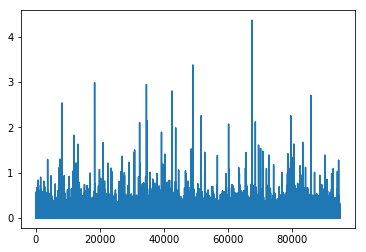

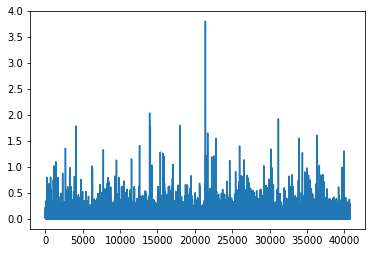

decaying  0.0004293670128499999
EPOCH 5


0.036554369847103564
0.04708329939469626
0.041171583306686875
0.038607236217973885
0.037520295294903756
0.039933375040270835
0.04428693389249123
0.04564833487171501
0.044536998578761
0.04289532762869924
0.044322426158155966
0.04469499670122018
0.0455449720836128
0.0451720987035146
0.04424338343622773
0.04303446698405457
0.04258061681453354
0.04220291219468548
0.042380695134513036
0.043600604021661424
0.043179394882286996
0.04197818662163549
0.04252866064371432
0.042621022319225536
0.04204915802784294
0.04227993677588336
0.04222887479281611
0.042145237400916684
0.04178164191452455
0.0422753144279229
0.041902982957512054
0.041213492295943156
0.0411887933968109
0.04096119219358419
0.04042782352231228
0.040706436522543195
0.04072347550989044
0.04021452607955187
0.04043946379216681
0.044108619567164206
0.04379497418456372
0.04413038834715663
0.04344729059405503
0.042877868921753035
0.042421164323291
0.04267992635798947
0.04235348250148755
0.042571461995000684
0.04263762557187961
0.042287338

0.04072135043177786
0.04069150577423015
0.040642417386872964
0.04061934303829582
0.040604482669445226
0.04083533283038565
0.04077639901646028
0.04077972545391166
0.04077186623476472
0.04071908736290666
0.04071517280859112
0.04081993524462769
0.04082304647923363
0.04073958392971231
0.04072373085859878
0.04064164331365829
0.040615177894390536
0.04065588894903096
0.04061543968279703
0.04058668724929358
0.04072558157208763
0.040704615157042115
0.04071478845465297
0.04066531250900162
0.04067576457152465
0.04067316428243247
0.04065489299371997
0.04068563991537374
0.040686925266569446
0.04070741468082628
0.0407199536695953
0.040750737471687976
0.04070979673270095
0.04066462824207946
0.04066573993254185
0.04067296838975044
0.040792148192033625
0.04086130285118335
0.040890878117745236
0.04085105190354982
0.04080733060210975
0.040788139137969824
0.040771553581614814
0.040776064868588965
0.040804371891924464
0.040782289733347826
0.04078394015732986
0.04083950941273234
0.04081690844474402
0.040824

0.041263057205692226
0.041253482167932065
0.04124581325887541
0.04121802070454032
0.04128327809982186
0.04126835506920075
0.0412672168646741
0.04126663461488267
0.04125876591206598
0.041239470568420436
0.041247117910621287
0.04126543379000982
0.04124541421564728
0.04122876481696784
0.041219996135962465
0.04122064594603152
0.04120241260075518
0.04120181463777105
0.041260302926616414
0.04124939891405092
0.04124290012631106
0.041232258481777535
0.04121465138518756
0.041218395032722344
0.041277759729066436
0.04127824977983396
0.04128130844148968
0.04127521759763489
0.041276017801612205
0.04121957127552392
0.041201763275851316
0.04124979592215216
0.04123816190057766
0.04122973605867589
0.04124362440772814
0.04125001069671468
0.041232849788153496
0.04124401350216666
0.0412953504829248
0.04129084121277751
0.041316051884918735
0.041303692945145555
0.04129809928004013
0.04131116221974718
0.04132373976279141
0.041309675857865394
0.04130361946083396
0.041319664386664935
0.04132255045767529
0.0413

0.0415098630585808
0.04148422452946992
0.04145729843548038
0.04144788961054076
0.04146993135545315
0.041448932503906966
0.04143070970729513
0.04142843873826673
0.041407387044307443
0.0413989177131629
0.04138774350992015
0.0413612880879864
0.041346831428339
0.0413341973028516
0.04131612791028753
0.0413325197615088
0.04133476637573819
0.04131412441652994
0.041289963320111166
0.04128958327720774
0.0412970603609019
0.04129613975832453
0.04129914996368321
0.04126769620959403
0.04127974666730267
0.041293486160534784
0.04129044391166443
0.041291742643709106
0.0413088297817641
0.04130452172712549
0.04129671808226218
0.04130903037734469
0.041319889882948456
0.04131481563214815
0.04133305731969099
0.04132110877274385
0.04135431718420767
0.041341686359095756
0.04134461705952016
0.04132218295887062
0.04130630591761276
0.041298659937673066
0.041311957935815144
0.041303715558325724
0.041306816019599256
0.04133943324941889
0.04131886549492985
0.041329081387159704
0.04135831819861171
0.041365146160119

0.041489488146405615
0.04148990261661073
0.0414856299096544
0.041471086628853716
0.0414598145012142
0.0414427706057161
0.04145457806937998
0.04143944808478687
0.04143943478373448
0.04143322576561484
0.041444396091029054
0.04144698736310133
0.041450959166097985
0.04146619195708766
0.0414561945047666
0.041478070674436186
0.04146491903219914
0.04148082439845118
0.04149975150818945
0.04149894435478392
0.041494550150796936
0.04148288982095011
0.04149922687988988
0.041509686684604516
0.0415122958032994
0.04149915309456534
0.04149595736018512
0.04149024413475054
0.04155214700700711
0.041551359099226276
0.04155627928358034
0.04156593153716947
0.04156098949720034
0.04156208289653925
0.04155943978920806
0.04156688360092902
0.041555959152897455
0.04155948071767184
0.04155330655252341
0.041555253245259174
0.041548544161561125
0.04154594064898563
0.041550618063099946
0.0415324067073195
0.04151120999928953
0.041534321604353
0.04152346663558437
0.04151239615318331
0.04153211575043306
0.04153439452064

0.041663366746151745
0.04165353533224191
0.041655481557835494
0.04164416944974543
0.041625811744246066
0.041620218119907175
0.04160351141117293
0.04161208639035912
0.04160306390363084
0.04161000004201696
0.04160676913311458
0.04160559575580708
0.04159947333382771
0.04159762664453168
0.04159201184488755
0.04159232036022879
0.04159264641457832
0.04159290903676465
0.041593746098657104
0.0415807073397535
0.04158471119410342
0.04158729103407585
0.04158491084921632
0.04158485005778258
0.0415956565766616
0.04159658690243429
0.04158628835616636
0.04158468355824645
0.041582205255232804
0.04157198069048742
0.041576032197484354
0.04156952212432325
0.04157772683627483
0.04158231312993313
0.04158370886632147
0.04157663656653804
0.04157088803725086
0.04155995702645377
0.04156142590147553
0.041565029405706055
0.04155361854610571
0.041545440407882425
0.041548061250371374
0.04155354921862486
0.04155337026396969
0.04156036157966292
0.04156333894255719
0.041618736143225206
0.0416028180213452
0.0416045694

0.04163974475655641
0.0416373025186831
0.041650588587150386
0.04165020433543812
0.04164788014457529
0.04164860011382453
0.04164871844410149
0.04164736973046899
0.041641464062052345
0.04163721254857498
0.04162946275466005
0.0416280717450283
0.04163967361413044
0.041651655225719744
0.04164819109634592
0.041660620639390585
0.041654714741687776
0.041664950365608085
0.041666616787451746
0.04165882604864376
0.04164770718971446
0.041650126283800215
0.041643516035135275
0.04163630582784235
0.0416307902395897
0.041633606691662876
0.04162644595162557
0.04164708439293536
0.041651126706310666
0.041652241371503994
0.04164675113222791
0.04164548685561566
0.041654039705186705
0.041652528549344925
0.04165195574042597
0.04166060981089476
0.0416633115499478
0.04166623394314373
0.04166247491321505
0.041654331644809736
0.04165653889060964
0.041662174490065
0.041657088947505146
0.04164763129984115
0.0416511614883749
0.04164752151208957
0.04164439515507884
0.04164444575311422
0.0416408477805205
0.0416357449

0.04183514367317901
0.041846351134598773
0.04184608912639754
0.04185307418337692
0.04185141372463288
0.04184750970754915
0.04184934298990132
0.041843199993960085
0.04184167444692277
0.04183702537041336
0.041856083886527055
0.04185411089581504
0.04184918406709405
0.041849973879944866
0.04185183445437117
0.04184715324943725
0.04185040455485247
0.04184855485378194
0.041852198696750255
0.041855202189341606
0.04184559402091641
0.04185538449486993
0.04185156663527257
0.0418624685652701
0.04185991548504233
0.041858556089932525
0.041848658593706664
0.041863524881441266
0.04187124603633086
0.04187245812462215
0.04187370713188757
0.04186779376354725
0.041867926967179975
0.0418691666406697
0.041865098641100926
0.041857838142446625
0.041854906008593595
0.041840337811465816
0.04184176902625161
0.041841564636499476
0.04184598024195957
0.04184817328077049
0.04185641411954314
0.041854094121945344
0.04186108313675112
0.041864224305635515
0.04188037575280489
0.041874065867748014
0.041869725633174405
0.0

0.04187429663929291
0.041870582148249826
0.04186538770385573
0.041872998882945996
0.04187010773095168
0.04186530297374364
0.0418659872354132
0.041860688917207074
0.041858991393010324
0.04186916414139645
0.04186847418107624
0.04186797220822399
0.041864863245067274
0.04187331469831647
0.041898353081454016
0.041908948228497854
0.04190645809310778
0.04190787016210788
0.041908839277399426
0.04194435486073891
0.04194043561917166
0.04193697256616945
0.0419570037447869
0.041967455511385636
0.04196739376606028
0.0419661049051933
0.0419724647200016
0.04197214358012706
0.04197073601450334
0.04196734139096802
0.04196070644393855
0.04196318335500314
0.04196021137210494
0.04196272646650399
0.041954805759939054
0.04197025454880667
0.04197259360100902
0.04197012361179721
0.04197757904016873
0.04197435858498233
0.04198429613431627
0.0419944156144186
0.04199893995104641
0.042000111425716316
0.04199911447050753
0.041994389861039046
0.04199273016040415
0.04200089235755785
0.042005682070057594
0.0420039473

0.04214916158021881
0.042155447378699945
0.042155504805534816
0.04215167263165474
0.0421486724974305
0.04215123852994361
0.04215132978620263
0.04214311614882296
0.04213991010338754
0.04213701016594625
0.04213282981810577
0.04213022862251969
0.04213910961487131
0.04214714378701179
0.04217704456012295
0.042169070229769366
0.04216641482381725
0.04216198770116962
0.04216656937724875
0.04217078952320051
0.042172252053610415
0.04216709674040389
0.04216185919655352
0.04216540868358396
0.04216682870338333
0.04216957269309735
0.04220106946090686
0.0421984347921282
0.04219984227664155
0.042199756089345966
0.0421948979832317
0.04219641234919743
0.0422021835042558
0.04221045157623222
0.0422086740424187
0.042206829571990255
0.04220387659206649
0.042207754516289796
0.04221387434735587
0.04221083343385038
0.042216865715506875
0.04221686867904808
0.04221173115033505
0.042212911342051664
0.04221799778470368
0.04221733391639109
0.042212221926902084
0.04221993708971174
0.042229894433156494
0.042231870921

0.04237884714528001
0.04236949364054704
0.04241866570489586
0.042417155024581814
0.0424112404675241
0.04245219595242405
0.042448977079241605
0.04244870709083657
0.042447568677984576
0.042448431345062605
0.042444240701665574
0.04244160645183204
0.04244121949230326
0.04244097777500306
0.04243474350394513
0.042426244916271026
0.04241980987434649
0.04242496781306108
0.04242607084728161
0.0424236488984119
0.042425162335023324
0.04243003615625239
0.04242573845219017
0.04242419491508209
0.042428320701378607
0.04242360121390016
0.04242390650676945
0.04243429343944432
0.04243346979912935
0.042432486157461945
0.04244120143632221
0.042449077365950674
0.04245124450501738
0.042444579038038534
0.042442956266917034
0.04244252129711543
0.04243917758720934
0.0424377276712937
0.04243699843228748
0.04244185463716915
0.04243994356669557
0.04243554855657958
0.04243196491188431
0.04243093829989158
0.04244382536984693
0.04244888968008209
0.042443516183760015
0.04243981887234149
0.04244049289731672
0.04243966

0.04230926530743141
0.04229987385707216
0.04229887299025553
0.04229567947761639
0.04228898671901543
0.042289473307994666
0.04228307663699597
0.04228116588689946
0.04228216214047641
0.04227650984811838
0.042275415146184964
0.042271341887186974
0.042276014103924
0.04227823287743184
0.04227724774660036
0.04227369897354001
0.04226961840869588
0.04227011282534558
0.04227124995428165
0.04226836578304888
0.042269368866746655
0.04227287349027783
0.04227753733415402
0.04227208525924361
0.042267789037166964
0.04226827779814447
0.04226271374448487
0.04225771129739686
0.042267082726569316
0.0422724364771846
0.04227402940176967
0.04227016823473086
0.04226559199360407
0.04226426837526099
0.04225823455110822
0.042253790073437276
0.042254421075751246
0.042249943856148726
0.04224854193425586
0.042246148858131244
0.04223823991021779
0.042239620324802656
0.042241060554714195
0.042234893970176005
0.04223766246014115
0.04223571855234901
0.04225459237360243
0.042249195594769716
0.042245917819633785
0.042243

0.042450152772235586
0.04245304059559463
0.042457257224864015
0.042453611415462784
0.04245519447492405
0.042453199026505996
0.04247446245082713
0.04247331010307797
0.04247578527555537
0.04248619907688513
0.04248970951685135
0.04248981912483434
0.04249013868021966
0.042490836185227865
0.04249054364105166
0.04249317885527402
0.042491730897732186
0.042488700396291955
0.042483148072291164
0.04247935133313623
0.042475467151991166
0.04247639956558069
0.042482455574741125
0.04247844080404045
0.04247788703925765
0.04248285815641681
0.042482776470016886
0.04248358355284451
0.042496339909417306
0.042501565275149485
0.042502937461974304
0.04249789122968556
0.0424937459883734
0.04248896757056321
0.04248718781667446
0.04248488643836173
0.04248195323393904
0.04247979725104292
0.042476373036435866
0.04246934563110043
0.04247599008580776
0.04249269942455781
0.04249161553333614
0.04249577711913527
0.04249391072436331
0.042492226867132256
0.042492163727563474
0.042494195706298254
0.042502999093246695
0.

Accuracy =  0.9933353302381309
BEST:  0.04558936786591809
TRAINING:  0.04265634749032754
EVAL:  0.04558936786591809


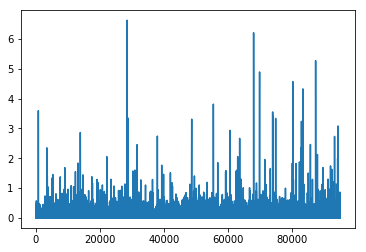

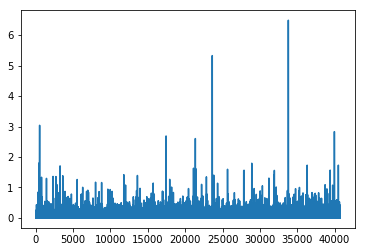

decaying  0.00041648600246449994
EPOCH 6


0.03679476920542823
0.03025699700212913
0.04523325797070989
0.04446723360104852
0.04411069070425349
0.044902481220808005
0.04773542595776471
0.04760577739938039
0.04695329963394266
0.047802003519615346
0.04501523568759406
0.04507268669399369
0.044710442985134206
0.04418749565397815
0.0449672268646845
0.044391295716652616
0.044833313655855925
0.044473198829940684
0.04768108326543806
0.046096808462490084
0.04636119259845486
0.04602483553054212
0.04518341430663012
0.04493592431706285
0.04403464354701316
0.04362900562160289
0.04461516236784268
0.04419549427348052
0.042942574171332376
0.04241867440434594
0.04219941680980086
0.04157864532815708
0.04323236850646746
0.04324727777334532
0.04379046932233605
0.0439721350260391
0.0436706676334535
0.04333578568830742
0.04369312422674705
0.042977550890905124
0.042999019970705946
0.04268584868829387
0.04291700909950956
0.04233900573748984
0.0419556980702088
0.041481613732785826
0.04124083896533235
0.04147503333710304
0.041755815334891574
0.0416244173

0.044879227907494317
0.04491363012252179
0.04490260773282883
0.04493496064270816
0.0449924587633307
0.04501092812768442
0.04498712243495023
0.044925022096747425
0.04490890522145632
0.04496029098699118
0.04499398078726948
0.04504034375208031
0.04498781241834648
0.044956153018373135
0.04493182660302673
0.04493203467136456
0.044959371442957266
0.0449671984897378
0.044971250020263615
0.044972037900554256
0.04498909749088938
0.045001858442660185
0.045000913206710985
0.04498565894566458
0.044953072089057536
0.04497438190073354
0.045019031602984844
0.044965440426772474
0.044907258817205656
0.04488811652649238
0.04483681794463709
0.04476239761929115
0.04474389828869459
0.044715630677742944
0.04472264520545867
0.04484945293862605
0.04481334632999272
0.04477423594265482
0.04475802319739629
0.04479189231309178
0.04476429302632924
0.04472421261299384
0.04471143180778337
0.04478364866141637
0.04473872429123824
0.04471345854772893
0.04472713529395834
0.04477470985309405
0.044800090987206484
0.044817

0.044173083842208166
0.044199346720821944
0.04416921039162669
0.04416218739777781
0.04418570369900303
0.04417664927840501
0.04415696219394918
0.044163729612476346
0.04414728753914056
0.04417816838801881
0.04417263842925961
0.044174853925053555
0.04416371309487536
0.04414238527654819
0.04411432846406758
0.04416376234330619
0.04414497446606019
0.044137990073183656
0.04415046970634965
0.044156271901818554
0.04413459343743123
0.044138912121073355
0.04413478172745602
0.044133652994966785
0.04412593014125818
0.044139492057812396
0.044146684683212534
0.04416128057864406
0.04414865625199715
0.04417247261878646
0.04420470549260334
0.04419416792365293
0.04421343997769224
0.04441616265064983
0.044421729514712974
0.044415241309733657
0.04440946205650213
0.044435045506301035
0.044452139558272756
0.04443854406658533
0.04442064655001656
0.044405370626165855
0.04440969724630565
0.04439206262146309
0.04439035103576111
0.04435854560976724
0.04433902479051633
0.04434538327812025
0.044303101865739505
0.04

0.04382788181674323
0.04380639018831246
0.04377787491732039
0.04380839378305036
0.04384660600721983
0.04383760840980585
0.043807852298287535
0.04382223746397093
0.04383884398260575
0.04382214813369
0.04381295114021952
0.04381705880864334
0.04380286513466412
0.04378812578844301
0.043800720075633834
0.04381798874100516
0.04382970606537016
0.04382710918965869
0.04381550857626987
0.0438049282720679
0.04378584338559244
0.04378461883512521
0.0437755254427977
0.04375260526297469
0.04377431306863319
0.043781045479417434
0.043793533833895656
0.04384373229142349
0.04383899569708451
0.04386573186143671
0.0438859074864525
0.04387121748137292
0.04386452916507859
0.043860997502060246
0.04384763153346166
0.043829539950821346
0.043844856873991506
0.04382382240278519
0.043824444736231254
0.043809511804310496
0.04379817536445919
0.04378711349642154
0.043765518426662174
0.043780272500621366
0.043769816312135064
0.04376597743883633
0.0437706465091108
0.043764665616502905
0.043759650364220956
0.04375222908

0.04352007854339537
0.043517700991616524
0.043501513872293666
0.04349615074376243
0.04351189914697331
0.04348901869805281
0.04350322781848494
0.04350604910444395
0.0434991903791477
0.043492927617141595
0.0435211921038129
0.04351745284746744
0.0435054272236577
0.04350133690876491
0.04350590737833839
0.04355310977557227
0.04362021715951087
0.04360890196400125
0.04359706362372493
0.04359364041452414
0.04359956625167544
0.04358965336193785
0.04359273493815663
0.043576966673750245
0.043574171261379205
0.04357432739105637
0.04357329892965584
0.043573737467198295
0.043560998743122005
0.0435603046691075
0.043555904856078936
0.043549687867379595
0.043541971078451716
0.04353841720541405
0.04353846509068303
0.04351210236776082
0.04351172590042296
0.04347929059492617
0.04347566903974092
0.04349660775628666
0.043497399092071794
0.04350494069887984
0.04349295059055327
0.04350031612152981
0.04349919048187316
0.04349643706981361
0.043503521869063186
0.04349714141507873
0.043511076230496326
0.043494874

0.04367588713162438
0.043674622628563774
0.04366731378718263
0.0436771548551058
0.043689439438348465
0.0436891745295104
0.043681315475990266
0.043672285419878866
0.04366479176089866
0.04365859348801403
0.04365677444479043
0.0436730075460092
0.04367276960577248
0.04366867040155717
0.043691315154665976
0.0436951222932259
0.04367481345811167
0.0436756984959009
0.043668972514737996
0.0436634185191137
0.04365865884450381
0.04364695203374464
0.043640034635175184
0.04363706110365481
0.04363728092460565
0.04363228146346919
0.04363085312670049
0.04366697552371394
0.043660319843973644
0.04365910377719993
0.04370847120911917
0.043704151799626716
0.04369706429400933
0.04370123923868103
0.043699662149544106
0.04369544448747428
0.04369495917713276
0.043679939771766645
0.04368550130475539
0.04368641057591181
0.043697300781842446
0.04369311250837151
0.0436855628418113
0.04369263753931346
0.04368532582858941
0.04369417007206526
0.04368162067804027
0.0437479536157535
0.04375424953507719
0.04381817737280

0.04426937705931675
0.04426843737952451
0.04430982694465884
0.044315101719534324
0.04431864261769021
0.04430754300774711
0.044343837883279995
0.044337786766092645
0.04432991435123561
0.044318398884173035
0.04433840129161052
0.044350835058727216
0.04434694754429457
0.04434915163659788
0.0443332517971979
0.044329761923123115
0.044339736364426126
0.04433645201469107
0.04433869736716778
0.044334050211825925
0.04432699538484769
0.044343519636682836
0.04434284324493465
0.04437188557828508
0.0443684145787325
0.044364459336036596
0.044364315742055994
0.04436921650329196
0.044367043229544496
0.0443780237898362
0.04438611832478076
0.044390769681151215
0.04438481045573576
0.04438058226182879
0.04440379455019993
0.04440620078699298
0.04439680304287131
0.04439906891450618
0.04438972025671246
0.044392938185592895
0.04439645067856845
0.04438864843376888
0.044394270949804186
0.04440162814583911
0.044396051955402076
0.044386688440615316
0.04439075772877489
0.04439873287779402
0.044398116301213854
0.044

0.0443060650286522
0.04429479863566338
0.044297732491163554
0.044323274594327236
0.044333896080279434
0.044329041944701525
0.044324701974051695
0.044325053283921674
0.04432020013061389
0.044313344313940274
0.04431485628618792
0.04431073070044707
0.04431114790150264
0.04432231865082974
0.044317404728799005
0.0443127884515743
0.04432693482755704
0.04432733111496823
0.04433642674884157
0.044338903476490096
0.04433417932229622
0.044333243932498316
0.04432438815944903
0.04431951394958396
0.044308588401795766
0.04430761401850064
0.04429860479034896
0.04430063281598891
0.04432974548275253
0.0443318388019911
0.044332322333491284
0.04432899147236681
0.04435285758284354
0.04435237932700716
0.04435643523129043
0.04440941807814579
0.04441506793926324
0.04441188934937624
0.044412166230210846
0.04440747757932587
0.04440782556379407
0.044416497815031875
0.044413530901392814
0.04440973557728847
0.044405076214735675
0.044404033271916
0.044399856118442535
0.04440559518777728
0.044394865851758405
0.04439

0.04488597956727247
0.04488560957392471
0.0448746643167849
0.044874861144427396
0.044885194200573186
0.04488346590309364
0.0448906093104891
0.04489095698584307
0.0448929417913121
0.044890664734565135
0.04489481172273568
0.04490749483144504
0.044903664739166474
0.044929941495938285
0.044927378760581435
0.04495288039610224
0.04495717441304754
0.0449747294816491
0.044971178077295504
0.044969853906026765
0.044986991386687325
0.044999854068422
0.04498776614035033
0.04498884256789013
0.04497665571189143
0.044968815216637426
0.04496166756611472
0.04496637574709744
0.044974708320613385
0.04497301958856781
0.044969475869455294
0.044968826485169255
0.04497738757787476
0.04497513324659705
0.04497413319572818
0.0449734181887424
0.04497487508867085
0.044970090188455755
0.04496238335982968
0.04496557976889767
0.04496638309968941
0.044965878863884604
0.0449717190373859
0.0449685184005203
0.04496915336648822
0.044961984989073764
0.04495780965263752
0.044950627178388734
0.04494739142967292
0.0449489654

0.04544811795992055
0.04544635073603477
0.04544039683687013
0.04545084340508288
0.045448582525733916
0.045450441116205186
0.04545334854115548
0.04545341280505268
0.045444963644030244
0.04544252401410913
0.045443766943350845
0.04543539824841281
0.045431379102560454
0.04543152355412939
0.04543520145280106
0.045433801661773396
0.045425112953895605
0.045432612837485634
0.04542996707605005
0.045441027906803294
0.045433534810763225
0.04543530344163096
0.04543452079660873
0.04543717399755536
0.045437361343724295
0.04544434291220352
0.045444403233043586
0.04544204565043925
0.04543631725453836
0.045436852243651696
0.04544765747656878
0.04544972380152357
0.04545259794627674
0.04545485096805477
0.045453396873145084
0.04545970464022958
0.04546746524435795
0.045464948452520255
0.04547021647299908
0.045470825705698076
0.045472588071959086
0.045470550188832747
0.04546605654808509
0.045464397189155105
0.04546247775192054
0.045457289636765624
0.045457450124962606
0.04545526383260453
0.04544947191791945

0.045603244524236516
0.04560199455029081
0.045597603440820686
0.04559482907343857
0.04558705183208997
0.04558881129416191
0.04558331193201087
0.045578697180791224
0.04557192821851401
0.04556783641033219
0.04556643773804909
0.04556768249003487
0.045569087040712365
0.045567954023607596
0.04556883307207842
0.04556833118786669
0.04556390504452532
0.045566887132887236
0.04556560863954118
0.045556603026302316
0.04555778030760257
0.045553123831474716
0.04555317126998478
0.045553091148078324
0.045545349250978966
0.04554871004038333
0.045542236786781126
0.04553935677439351
0.04553501044492936
0.045540459956916836
0.045537159532905595
0.04553252392609826
0.04553082616176355
0.04552773825624587
0.04552501455168834
0.04551976091620302
0.045523714291425016
0.04552424235660265
0.045527028382833366
0.04553044691216781
0.045535128355841524
0.04553481659772807
0.045534988819506475
0.045530848129820216
0.0455330995651432
0.045541023104629624
0.04554530504833087
0.04554304579683268
0.04553372474516405
0.

0.04544150482327255
0.045441447812296434
0.04543937022756294
0.045441303020804784
0.045454779249532035
0.0454549126024692
0.045450565454278655
0.045445045586237895
0.04544185805392782
0.04543856044586291
0.04543618682609934
0.045432972322082696
0.045427064244057506
0.0454244846724116
0.04541733755321377
0.04541973196314052
0.04541945878828516
0.04541531770849109
0.04541426158277227
0.04541603974855736
0.04541269257744718
0.04541284374147143
0.045415685782952964
0.045414146996624646
0.045416589422371006
0.04541441726779148
0.04541047824995902
0.04541677775843668
0.045414998742681185
0.04541271127321171
0.045412230610792755
0.0454119806566145
0.045432630193995266
0.04543748866617802
0.045441516559063116
0.04544167866189356
0.04544545309901538
0.04544596015208791
0.04544947300807004
0.045447465697862614
0.045445170081184
0.04544083719154401
0.04544233765528707
0.04543973755359269
0.045447132428897016
0.04543875771556057
0.045437637488616865
0.04543642694640084
0.045435766802175676
0.04543

0.045421797664415425
0.04542675565538656
0.045425468619233196
0.045425057112025644
0.045430855430499094
0.04543069825504554
0.04542365939349273
0.04542566706733646
0.04542505039768936
0.045424316826281314
0.045428416972906324
0.04542578024503114
0.045426296589217235
0.04543353222798677
0.0454278865424302
0.045434363625300275
0.045426381075106215
0.045422702843888337
0.04541869366741864
0.045416541562498206
0.04542018380525118
0.045415597566599616
0.04541766078222098
0.045417570603373286
0.045416494341647344
0.045420465822151895
0.0454168128983544
0.04542240763940877
0.045419083275843354
0.04541428267694571
0.04541039259392113
0.04540866692695862
0.04540368085509704
0.045408332870825345
0.045410320470970406
0.04540458959740892
0.04541962134597111
0.04541882249188234
0.04542153441722351
0.045430898311764355
0.04543313148907639
0.045435058979581076
0.045434232832825966
0.04543018577928091
0.045435052569775286
0.045441413618782824
0.04543731732694203
0.045436956889193074
0.0454405721735919

Accuracy =  0.9939718436423544
BEST:  0.05002504857544062
TRAINING:  0.04548530714009997
EVAL:  0.05002504857544062


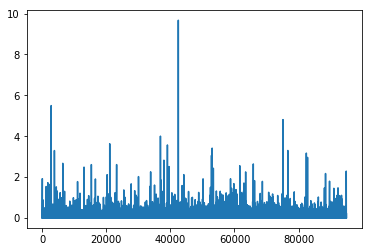

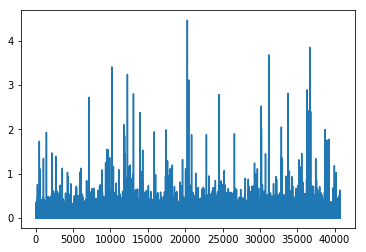

decaying  0.00040399142239056494
EPOCH 7


0.14565576382066944
0.11479086502278939
0.11295682102728417
0.11141740213632616
0.10617226551103329
0.09786891354825389
0.0925938311856436
0.08264789827237473
0.07874330809060891
0.07689238760927983
0.07628751690236339
0.07483133336807093
0.07295470530462654
0.07196788870661448
0.06913373471310107
0.06901795069098567
0.06683899325697537
0.06471478262426097
0.06251559671195735
0.061607297117279976
0.060104792971389036
0.06089098076270478
0.060472880673512225
0.06054027708379305
0.05978408652054882
0.05940577571287065
0.05910574087769478
0.058166679601649306
0.05839587921009753
0.05916790787541995
0.058922183759743146
0.05847523550788909
0.06133037829845901
0.05993776257921308
0.058705045778564384
0.058002975573514824
0.05798132534259205
0.05704274086156367
0.05713598335582171
0.05733262915962168
0.057493674508182865
0.05748544526028261
0.05747508281774906
0.05627884824959372
0.05593378874274157
0.055353402588407805
0.05477104826987811
0.054877291142083395
0.054524434344858465
0.05370838

0.04723669113326634
0.04716355209758778
0.04711949671199279
0.04710206074027979
0.04709869818012255
0.047047193008533786
0.047052389206020256
0.04709783504056309
0.047065049278889735
0.04705848166914495
0.04698499694190184
0.04692512536314049
0.0469368149112214
0.04702945381586605
0.04700444857881572
0.04696953996028158
0.04698206527930842
0.046958420084776256
0.046949450057566476
0.04694652206339585
0.04692791695850753
0.04702915376998818
0.047075847259459784
0.04705457085005502
0.047029801865348525
0.04698200164213758
0.04703506173780506
0.04708021905458023
0.04705903084332936
0.04703705934734875
0.046915857729252615
0.04683380683786084
0.04684260754424806
0.04682288960168345
0.04679467443015444
0.04715655840811379
0.04709779038443973
0.047126570941246664
0.04710314793883112
0.04712305777758069
0.047062021780259825
0.047004391955849864
0.04699919038400717
0.04699213642287803
0.04693620258936672
0.04694548139311448
0.04692640154907631
0.04695893264853778
0.0469695191647579
0.047002878

0.047384209785587585
0.047363347734354584
0.04736347511935365
0.04735289910514268
0.04734248490434809
0.047412541386246676
0.04739564841636917
0.047391956537463004
0.047395998875174414
0.0474141504830412
0.04741201523731106
0.047408708257374844
0.04741932907835142
0.047377477270283276
0.04736410939395368
0.047365036715758306
0.04733939470351296
0.04731193889178939
0.04727837367919471
0.04727513155394538
0.047285314056739365
0.047280788796424056
0.04723841971824719
0.047330424511568846
0.04732525885152796
0.04733060077156453
0.04737346271567374
0.047381820371901785
0.047411380022544664
0.04760138593727649
0.04757249791451696
0.047570434480054435
0.04759711051950388
0.04756667702207862
0.047565422720507386
0.047564201435299575
0.04753717802691839
0.04753821877091029
0.047527167350139926
0.04752266833649371
0.04752434039422026
0.04755217746346272
0.04756514288842377
0.04755300442742167
0.04754161181983001
0.047535782575696434
0.04752745235367272
0.047551381060707394
0.04756716062999825
0.

0.046938865895924345
0.04695801766138472
0.04697019382576591
0.046981248249577716
0.04698860431852706
0.046963396746594735
0.04694376289828418
0.046984630024831796
0.04699327202857711
0.04698722711677065
0.04698133504903561
0.04698374375756216
0.047013947430438616
0.047031576959457554
0.04706904780994151
0.04705898864349289
0.0470639268252904
0.04709434476195195
0.04708872443688794
0.04709282264712519
0.04709961800798815
0.04708951583746447
0.04706852773283338
0.0470709363840428
0.047057129350360445
0.04704577211011208
0.04702614754133999
0.04698996348077022
0.047010378981786075
0.04699054652758024
0.04697905000825896
0.04698664137109846
0.04696835319774298
0.04693275125068311
0.046944898773666255
0.04691905838144688
0.046948341186006326
0.04694672465096511
0.046939599461812954
0.0469920521370943
0.046981207826903085
0.04698942944408303
0.04701008625378077
0.04698275602522392
0.04701672668486249
0.0470011834428218
0.04700238174128213
0.04699921168087541
0.047014090782679756
0.047022157

0.04770452256432776
0.0477028492905871
0.04770833184483271
0.04770163109994975
0.04771872998955167
0.04772004504982429
0.04770868264032417
0.04770391974573986
0.04771214552221261
0.04770072310571885
0.047693899650231575
0.04771929309294533
0.04771012169871707
0.047716545999767206
0.04769627388649308
0.04769107868244332
0.04768007652872076
0.04776896366834789
0.047757432178166935
0.04779119223992484
0.04778875155588971
0.04778731180697927
0.04783000928617111
0.04783059122051656
0.047833924070745194
0.047837510262969896
0.047844385604690245
0.04784587761610223
0.04784747190091209
0.047866509578316965
0.04787592899944552
0.047872184572525914
0.04786009843188799
0.04787217837934623
0.047862601669575025
0.04786048522807549
0.04785828445639265
0.047868259728754844
0.04785709730471186
0.04787399544405954
0.0478529668743813
0.047844873082022475
0.04787160344057178
0.04785453304799208
0.04784565964417876
0.047853989531098234
0.04788688698587553
0.04787589055661165
0.04786592939307345
0.04784491

0.04895542185711622
0.048957917617458574
0.048954543660903245
0.04897593427920528
0.04897580926603668
0.04898523870189427
0.048987089717124996
0.048997063271076564
0.048999874652569116
0.04898511462984319
0.04898226041666908
0.04897694174284282
0.04897622426440086
0.04896174864889432
0.048962856935939034
0.04895799126560723
0.04894776479642641
0.048939362253877135
0.048927327604016926
0.048925421896255074
0.048917915461920994
0.04893127808977808
0.04893455085070676
0.04895543398000568
0.048957289080402415
0.048964002580369016
0.04896833025982695
0.04897805308163724
0.04898085242719815
0.04897544344571183
0.04896569772840124
0.04898951430973524
0.04898831903923752
0.04898310012982874
0.04897320922685337
0.04895680954149198
0.04896186767993958
0.04896259978663489
0.04896356810699502
0.04895230360474992
0.04895526022717321
0.04893397968460574
0.04893051970279675
0.048919481742519644
0.04892027193625553
0.04891878928749705
0.048936757190622536
0.04893958383830918
0.04896007809934572
0.0489

0.04973780402324927
0.04974732153254457
0.04975199539662505
0.049766321787610396
0.04976664583947669
0.04977206631242728
0.04980484360453553
0.04980388867371685
0.049834340737496666
0.04983741938990911
0.049864190714001756
0.049881325414131435
0.04989667491815547
0.049911997195989224
0.04991687021642168
0.04993219176096797
0.04994637415342008
0.04994085021032947
0.049954756171046416
0.049950481812457904
0.04995183191510674
0.0499444063069579
0.04997722431283562
0.04997252133333525
0.04995946944444618
0.04996389863274373
0.0499914460153505
0.05002213586379567
0.05001529940572343
0.05001884279529097
0.05002308595777678
0.050043053089743494
0.050050985812709635
0.050045436474501395
0.05005001952581434
0.05005670603449881
0.05004563573138903
0.05006851464466384
0.05006654316182178
0.050079102166867916
0.05007753453187147
0.05007890026034233
0.05007640142968538
0.05011267403545469
0.05011035746275944
0.05011535689449714
0.05011752279790349
0.050118927573026814
0.0501112987109389
0.050102378

0.05118301216635812
0.051209172214009196
0.051204968292608254
0.05122274000460222
0.051226389619883496
0.05124136418139091
0.05125337847903872
0.051252768869165063
0.051247938516967254
0.05124925145230148
0.051242804053558376
0.0512470893614923
0.051246949589697596
0.05124265982017705
0.05123819012668136
0.05123497166386005
0.05124004676892557
0.05124018065000021
0.0512325752988669
0.05122410962421414
0.05121004471467702
0.05121836769832687
0.05122014798407898
0.05122659968059511
0.0512146866869156
0.051237994329209766
0.051235484445046164
0.051245104544113754
0.051255092569176104
0.051247337068788555
0.05123739452806948
0.0512335730232429
0.05128387911492614
0.05129293674724131
0.05129198633788389
0.05128535770343019
0.0512903689485073
0.051283365353575396
0.05128641823474049
0.051286619658049815
0.05128155773727212
0.05128770686183011
0.05128001167609865
0.051281877333343606
0.051287650019100677
0.0512778743325838
0.051273182460271065
0.05127536025633622
0.051277655947080863
0.051271

0.05187544389607794
0.05187477565156245
0.05186649504655308
0.05187397019014412
0.051867912114881544
0.051865692293941716
0.051861385415729294
0.05187092486369408
0.051859544391629736
0.051854341242532895
0.05185413219838536
0.051870023709714067
0.05185707408061715
0.05185117240847737
0.051873041676660105
0.05186934102028412
0.051868313832579435
0.051868970648345294
0.05186415259200505
0.05188795432717423
0.05188303110879208
0.05189348150568309
0.051893773708393265
0.051916966767917426
0.05192344591475694
0.051919562151672566
0.05192844245276344
0.051927230488889246
0.05192134077580629
0.05192241736493774
0.05192656868089481
0.05192159408892095
0.051912460399770675
0.05190568126593431
0.051897562414741166
0.05193547452128366
0.051937253806007354
0.05193919186637477
0.05193948698637857
0.05193294390943864
0.0519327250370841
0.051934797564657735
0.05192665424270857
0.05191854652637422
0.051921782597512504
0.05193088169916767
0.051933636248284745
0.05193585927161805
0.05193331934905178
0.

0.05194572385497348
0.051941987438107746
0.05193424078858796
0.05192495704946871
0.05191717250877351
0.05191233625857634
0.05191387256295199
0.05190772928317742
0.05190211237987534
0.05189855547656987
0.051913326470640064
0.051907153593534774
0.05190707519971583
0.051903269782594734
0.05190619810056664
0.051904966763897956
0.051915545165282684
0.051931718922799804
0.05193725161982794
0.05193811863127146
0.05194776470942552
0.05194531752828999
0.05194663408340942
0.05194782890914833
0.051949386499911175
0.051958278327961516
0.05195235752741711
0.05196262330203356
0.051968239355919606
0.05196303054457742
0.05195118841577717
0.051963726952575756
0.05195920556827164
0.051953346322163405
0.05195199293888158
0.05194847385124221
0.05194871659159737
0.05194397539686557
0.05193582447736717
0.05193257403448464
0.05192560354949442
0.051924633247556945
0.05192317821677337
0.05191934837409516
0.05191393578234367
0.052040891851917584
0.052043534890559066
0.05204513047251619
0.052049160541958565
0.05

0.05212137747099547
0.052114818766790715
0.05212663081591843
0.05212628557870796
0.05212815202330808
0.05213635971376028
0.05213569719514136
0.052131664745228325
0.05213314267232071
0.05213240819939993
0.05213258717260656
0.05213637945363861
0.05213373302590272
0.05213456865297501
0.052128268191635456
0.05212547956263686
0.052123697505426746
0.052119872511830964
0.05212470918257879
0.05212095607199133
0.05212507615566525
0.05213288482266204
0.05213124705419619
0.05212849190212304
0.05212852919450643
0.052129310234052165
0.052138731308756125
0.05214096394671635
0.05213739235857627
0.05213799155506811
0.052137232264566666
0.052206301870591935
0.05219799810004003
0.05219963296132464
0.05220671418319466
0.05219944475962505
0.05219799747593445
0.05219519612869351
0.052197146928014755
0.052198878773026744
0.05220285502570195
0.05221257300054751
0.05220559234405034
0.05221287459997643
0.05221415206887121
0.052205244244675444
0.05219412168604697
0.05218696870703603
0.052183193037007816
0.05217

0.05184921258940275
0.05185938757415353
0.051858089351505966
0.05185650794421661
0.0518590586132324
0.05186394901463476
0.05186841237672055
0.05186674491322624
0.05186081553830717
0.0518572944651873
0.05185450651869628
0.05185423285367035
0.0518507958089301
0.051846097162081696
0.051845944883103436
0.051844901486641275
0.05184876221673805
0.05185154319020303
0.051851807341667756
0.051848507457619854
0.05184973728976492
0.051843350665009225
0.05184257866179485
0.051844289942752676
0.05185095708170313
0.051853309818152976
0.051875147707797165
0.051872793903513674
0.051874176627765174
0.05187164534682479
0.05187079581679511
0.05187375259914786
0.051871357511869595
0.051869032988319075
0.05186683943067111
0.05186353919364228
0.051867458757832656
0.05186571493510293
0.051866898554716004
0.05187147106925865
0.051865665671450116
0.05186402028658843
0.05186493467444343
0.051866800724079384
0.051871492995068345
0.05186387311506404
0.05186653541420959
0.05187515942245339
0.05187418747947092
0.05

0.051979347683609844
0.05197880758049348
0.05197940636696773
0.05197759225841848
0.051972605783118526
0.05197203289971402
0.05196861756074868
0.05196756640611034
0.051966096393444926
0.051964169245534875
0.05196210426459068
0.051964739081496056
0.05196472681952218
0.05196568391971851
0.05196734865159101
0.0519589159592389
0.05196190066333785
0.05195825076023043
0.05195907047042177
0.05196223940187629
0.05196224664663291
0.05196592812763787
0.051960213605311244
0.05196312316815838
0.051967411481739445
0.05196577178617858
0.05195706059861668
0.05195217246517113
0.051952364178404806
0.05194582142577569
0.05194263850306587
0.05194062105798702
0.05193790710269173
0.05193784027779315
0.05194483254681426
0.051946400677952004
0.051946653821811274
0.05194143433967956
0.05193578852591612
0.0519402633471104
0.05194013796487394
0.05194165509069761
0.05195012381554827
0.051946228008816535
0.051944268050177364
0.051948078449976384
0.05194267507744337
0.051939598763414384
0.051934095628612474
0.05194

Accuracy =  0.9934476561329939
BEST:  0.05399771713024827
TRAINING:  0.05199511722114777
EVAL:  0.05399771713024827


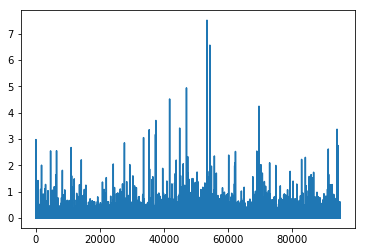

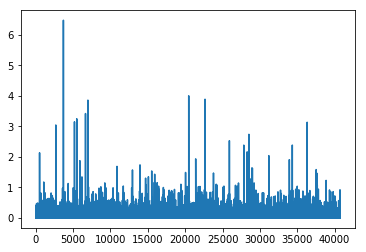

decaying  0.00039187167971884795
EPOCH 8


0.045053696301042126
0.043930647980252
0.043842236983966644
0.05315666783370679
0.054439770497413234
0.055716853599264114
0.0495045705853064
0.048071325990560625
0.049553567784507875
0.049210414868012226
0.049484544665294436
0.04709259178923492
0.05074812733256441
0.05086139048804494
0.050175899493289704
0.049584374980903345
0.049576563021175094
0.05035114720647826
0.049458696276485276
0.048187496472838445
0.047083927822121126
0.04735174796824119
0.046920396109163306
0.04708621883145728
0.047186118345717586
0.04699313850971699
0.047074486604038034
0.046997603438738655
0.04708197681629918
0.046905372328729024
0.04632384813156648
0.04718296212418716
0.047188302467039776
0.047358912863475364
0.048090392761124916
0.04943851288440948
0.048932205396288495
0.049003386104898794
0.04842426390379181
0.048474322381840566
0.04864875430994841
0.04866563391911327
0.04757492758035624
0.04834548775593462
0.04734240605291863
0.048198929085031005
0.048100884320119365
0.04841083277578576
0.04852234023379

0.050563136900795114
0.050549004637881784
0.050567161746269615
0.050495092933812165
0.050506505799884575
0.05041511162400938
0.05039537196034508
0.05045750568595746
0.050520968212589626
0.05048863598277169
0.05043672105978853
0.05045494044379113
0.05046736636923688
0.05053514917605963
0.05056993192992344
0.05056630275195537
0.050551101786297514
0.050535780060199285
0.05051749254332558
0.05043691658900158
0.05043341834630958
0.05036936906468894
0.050336621029504765
0.050304086249963624
0.05028216380620597
0.05033339719468986
0.050313094339393016
0.050336421696230906
0.05035854375305852
0.05039083408554061
0.05045135129626344
0.05064741432200477
0.0506273720836716
0.05062055289169166
0.05076613758231199
0.05073162272753072
0.05073270413504964
0.05068595540054479
0.05063351913970978
0.050549842719903766
0.050538961974209
0.05054745786592284
0.05054189425490004
0.05055664269060219
0.050614966702764566
0.05059214877159411
0.05061688675307237
0.050633439474663366
0.05073497031366065
0.050799

0.05094802278016184
0.050952851410316594
0.05092948828442611
0.05092169428555185
0.05089567544240087
0.050862551007138365
0.05088627134231203
0.05088151573788715
0.05087695609029876
0.05086661808851314
0.05085189270575237
0.05092006145888914
0.05091352483152053
0.0508996401504776
0.050883366097043324
0.050842542600057355
0.05090434620808153
0.05091738140345173
0.05092810719328115
0.05095076183081109
0.05095699474153124
0.05103360482779247
0.051018395099088475
0.05102005726381851
0.05105609266710026
0.051024440293212105
0.051015042644946086
0.05098471779731027
0.05100027466379005
0.051011511812492374
0.051116279112158644
0.05108946784333647
0.05108559710728697
0.05107703512104364
0.05104475073601912
0.05103726781988221
0.051030897154157
0.05102603426381708
0.051014707087136436
0.051018791911884916
0.05097939067412952
0.05102772839430446
0.05102339090797863
0.05104164826465993
0.05113961588671723
0.05109172819372071
0.051129417942190655
0.05110572717668969
0.05116847382796635
0.051188460

0.050967162570972176
0.050966665200614616
0.05095599147815882
0.050961686354075025
0.05095919004967244
0.05096632028338497
0.05097278263775464
0.05098312918074667
0.05102106472410745
0.05099855310986024
0.05099733050891875
0.05098053610168909
0.051001599373375235
0.05101400467893141
0.05103676469948456
0.0510628945508123
0.0511433787666644
0.05114809056226083
0.05113027512605049
0.05118647018064894
0.05116919794378798
0.05117491639611658
0.05115471147114194
0.05114684361142487
0.05113923980253724
0.0511676030676547
0.05117311753090915
0.05117085884414331
0.05118203405805751
0.051188487015918216
0.0511793170004908
0.051276400303609186
0.051256486642141226
0.0512725937255611
0.05128189990835234
0.05126777813616976
0.051299037551799924
0.05129621157357208
0.05128978981868648
0.05127301319345479
0.05123767637272239
0.05130146220575077
0.0512947001051464
0.05134109781397255
0.05133513330553576
0.05136154394034456
0.05134694884180963
0.05134573906679726
0.0513283960708832
0.05130025731181735

0.05103616650254755
0.05101935811614047
0.05101685072971779
0.05101994922908026
0.051008860632907785
0.05099391933299028
0.05099331177128874
0.050979066321199064
0.050985269638557366
0.05099067139871917
0.05097005278598794
0.05094888995585453
0.050973371667448884
0.05097449753985884
0.050977578739173954
0.050965688702075254
0.05097762317581462
0.050968796797407956
0.05095018819044489
0.050953834467094485
0.05096508138828634
0.05097648736177367
0.05096080083608273
0.05096992075173977
0.050964289656465336
0.050959501841453723
0.050966553084968926
0.05095788909137644
0.05095328070870049
0.050949070249308885
0.05095277802959824
0.050972879846843476
0.05108220225726795
0.05107003442755371
0.05106809798268852
0.05103886971125986
0.05103219144943678
0.05103239054599773
0.05102113675069167
0.05101688306706026
0.05103374333005729
0.051042772283113644
0.051035411420301366
0.05103743021959806
0.05103699949544268
0.05107373618744925
0.051061612183889674
0.051053880982949315
0.051062328916388
0.051

0.05159631326414001
0.05165050606071488
0.05164673092137356
0.051637030434782384
0.05163297350912282
0.05162375106057812
0.05161326914587213
0.051623277285605625
0.051647241595466936
0.05165560951367674
0.051647699735970894
0.05165058320500958
0.05163722517018231
0.05166143085970807
0.051658876097805756
0.05167096307478623
0.05167602324165086
0.05166335439686377
0.05166571221745955
0.05166712046770303
0.05167185948745624
0.05167817137001217
0.051680015855479135
0.05166880357824543
0.05166373019121257
0.05165690382734887
0.05166959836995421
0.05167297294462093
0.051668806086947794
0.051659222491408884
0.05165667209644564
0.051664539520820466
0.051649402655543755
0.051638359984156355
0.05165144530133361
0.05165413833913649
0.051649617896237066
0.05164659592769961
0.05166878526107132
0.0516504659006586
0.05165832537004062
0.05166847916042882
0.05165653188021861
0.051672431830665326
0.0516729461343355
0.05168558059718997
0.051669870985035
0.05166854379282483
0.05165827474232964
0.051662439

0.05136104800381261
0.05134408451187327
0.051344377158272225
0.05134143983117377
0.05134123253633303
0.051371628684880724
0.05137451138186927
0.051383402988532265
0.051370621228448946
0.051367165822725255
0.05136830559065504
0.05135276295763413
0.05135140613209101
0.05135276444339393
0.051348434098574466
0.05133961882241442
0.05134587863809241
0.05134036225138313
0.051340388677775274
0.05134117603340983
0.0513365663832502
0.05133542068585799
0.05134293386232138
0.05133987540848946
0.05142876455568741
0.05141625745763807
0.05141984087058697
0.051422565908733446
0.05143098921478113
0.05143324675694332
0.05142754700210104
0.051472088097140295
0.051459171611692084
0.05146680359048217
0.051472003993777694
0.05147465354816891
0.05148230086532087
0.051486210958807406
0.051492395135281525
0.05149113958821313
0.05148954442155285
0.05149065068639689
0.05150661379210013
0.05149756551257068
0.051506228575640564
0.05150733906813521
0.051509612650639046
0.05173186519059892
0.05171508938799893
0.0517

0.05165914883375384
0.05164954500603985
0.051649033221376796
0.05165296033244394
0.051654302624512316
0.05166733903748427
0.05166171311408676
0.05166088710766612
0.051673300728660165
0.05166206321350693
0.05165020126335607
0.05163842061450683
0.05164117634921662
0.051629404828583754
0.051625853874037626
0.051626275745446024
0.05162409203889722
0.05161418086263148
0.0516233547024796
0.05163015364227508
0.051629852237351385
0.05164434220272969
0.05164073725536318
0.05163736839592828
0.05164441822363649
0.05163759150615149
0.051640751281939366
0.0516517152913406
0.051644858168009795
0.05164555877983615
0.05165323391515488
0.05164909141370511
0.05164560459508913
0.05163368884948575
0.05161889207529203
0.051619356025438205
0.051624890338021846
0.05162916339225546
0.05162459582309184
0.05163076261586048
0.051623747165933154
0.05161081563491708
0.05160830628570659
0.051611111810123435
0.051600318889262545
0.051592268803016844
0.05158774010783924
0.05159553169037722
0.051587796905429355
0.0515

0.05186408635388649
0.051875120774932094
0.05187418067934371
0.05187175670269447
0.0518814290453599
0.05188526149483696
0.051891088512584
0.051891211692161036
0.05188490624615583
0.05189042878551228
0.051889320337772826
0.05187573127141674
0.05187611192988242
0.05187441190205078
0.05212837617014028
0.052119513328714874
0.05212102024948663
0.05210886387266451
0.05210419786044172
0.05209812538426855
0.05209504468673681
0.05208945531751388
0.052091992611874076
0.05208886908709411
0.052093253024807065
0.05208754500154896
0.05209150536938552
0.05208073702984665
0.052077650271071134
0.052073090258997874
0.052079087438419956
0.05209089614114453
0.05208592898219012
0.052081908636365803
0.0520868671700641
0.05209520540760816
0.05208232716216849
0.052091121526388715
0.05211091655704917
0.052101283317728043
0.05209986923094748
0.052100413534325346
0.05209764655700068
0.05209510310419144
0.052114942189541734
0.05211147256840503
0.052110978330007024
0.05211185205364424
0.052126289455574716
0.052119

0.05197487253771443
0.05196972551949172
0.051963503937999735
0.05195647571399734
0.0519560926526007
0.05195464532578811
0.05195110974810214
0.051950985021136195
0.05196809087700115
0.05197389518119105
0.05196950118934826
0.05198563927506741
0.0519818360867342
0.05197975814132147
0.051983534176771116
0.05199233057238104
0.05200351943256868
0.051995092324431565
0.0519985818322079
0.05199320278920297
0.052000754676427084
0.051995723059657474
0.051994851933389596
0.051983075992733295
0.05198112999802436
0.05197677157337647
0.05196897006121954
0.051970957289991355
0.0519672352992299
0.05196980784359144
0.05197228479932325
0.0519713034721871
0.051974368739105374
0.05197362716578352
0.051968733832276924
0.05195634068113787
0.05195153083799901
0.05195338965762077
0.051950669311542436
0.0519641510378027
0.05195175426648858
0.051944061141389435
0.05194114142818098
0.05193327881132523
0.051928603934341275
0.051920631064705895
0.0519206722533082
0.05191988290737647
0.05192960335752675
0.0519334285

0.052122843734125936
0.05212623286387415
0.05212136965852027
0.05212181149254457
0.05212728070104421
0.05213186508627714
0.052139148361799025
0.05214308577349149
0.05214716046921241
0.052137600781956846
0.052135997612967847
0.052172982836877414
0.052164793493420174
0.05216996841291198
0.0521677380770087
0.05217522513792623
0.05219575554725572
0.05218919720833481
0.05218369706524683
0.05218523131819516
0.052183721811478706
0.05218053716721012
0.05217238471868611
0.052168150219083616
0.05217190047741473
0.05217740207237656
0.05217101534993552
0.05218441579573091
0.05218477896249794
0.052185350990106676
0.052183290027213426
0.05218243980737026
0.052186410209437546
0.052189243097344046
0.05219126085839704
0.052186273859157695
0.05217622434433725
0.05216902780938633
0.05217423064352546
0.05217242569193229
0.05217332118612602
0.05217099869608651
0.05216961550145725
0.05216565206804258
0.0521691524102719
0.052170858979445234
0.052173141759771044
0.052170454512463514
0.05216548750613965
0.0521

0.0526243448448613
0.05261983660015026
0.05262016603069489
0.052618795818520074
0.052613431566618726
0.05261199275240845
0.05260580252369408
0.0526010623930707
0.05259707749290668
0.05259828249858814
0.05259870985969152
0.05261339897858815
0.052599376445555485
0.05258889813364016
0.05259689660322022
0.05259639092319631
0.052592099794125984
0.05260298338007812
0.052609286729793155
0.052605265045656546
0.05260362948722514
0.05260191960004804
0.05260969633772037
0.05261861235659492
0.05261755398549914
0.05261123842556999
0.05260768523404042
0.05261268199727489
0.05260825972621325
0.052599322123496405
0.05259914913549036
0.052599623849188155
0.05262453455437888
0.052632980746168456
0.05264467188650243
0.052640443110994556
0.052641013916147
0.052644518312694476
0.052639617459358204
0.05263510014824992
0.05263490108150174
0.05263668624660159
0.052639668005147605
0.05263275275689965
0.052633868977248206
0.052630092871042346
0.05262692739927974
0.052685636784401975
0.05268176247919404
0.052675

0.052846448562313915
0.052853205122016474
0.052848508033007224
0.052849678045744086
0.052854474902792555
0.05285228323041075
0.05285609416998007
0.052862040133359635
0.05285770076847328
0.052854901048979185
0.05284955071734335
0.05284564153484424
0.05284313765102232
0.0528383200355565
0.052840167606000334
0.05284420682346325
0.05283704491548673
0.05283977151275143
0.052837639391401105
0.05283542279245565
0.052844846469305914
0.052845288226839315
0.05284602488648369
0.05284983971177204
0.05284286856607571
0.05284115820959315
0.052834972880404146
0.05283408848770026
0.05283784829200429
0.05283918050875338
0.05285733445160042
0.052859353402789445
0.05285474192228381
0.05284598297757614
0.052836296556546626
0.0528287812852784
0.05281880669743656
0.052824282549447335
0.052821100668492764
0.05282067530164784
0.052822938957569274
0.05281956914298199
0.05281761454870243
0.05280967591201128
0.052808665556713125
0.05281196549014146
0.0528116345263192
0.05281014805709094
0.05280712560615729
0.052

Accuracy =  0.9940092856073087
BEST:  0.051477694661627466
TRAINING:  0.052814467885217445
EVAL:  0.051477694661627466


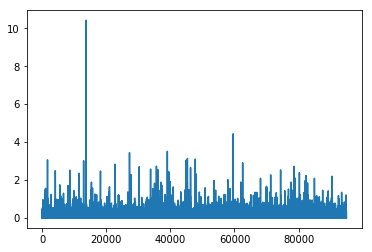

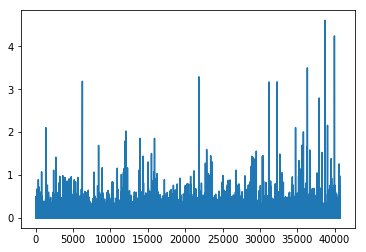

decaying  0.0003801155293272825
EPOCH 9


0.03750609701631455
0.037309534024777845
0.03676102228290314
0.03930141921251061
0.03963221377889255
0.03987193187198067
0.040113848130167634
0.04012613345161412
0.040400808291081586
0.04000706078248907
0.04219049168001385
0.0424361625356985
0.043609624998696646
0.06038175419044902
0.059162615557119526
0.05705068810260092
0.05685268613100702
0.055810936777339414
0.055008051899656844
0.05289446064588293
0.05144419046028182
0.050275383686670005
0.05055147974084858
0.05317203707507996
0.05250342614216175
0.05264659080667969
0.05281146573506299
0.05267338436686433
0.05209763672363105
0.05092048688643291
0.05129963362723652
0.050911983063521696
0.050117084900081654
0.04883814984518821
0.04868668138240802
0.04868165335451853
0.0479537729339422
0.04827705838766821
0.04820571402856792
0.04802524558874342
0.04753305826758453
0.04793612824973848
0.04768909432793026
0.047514334922180074
0.04717925423666503
0.04876976088985065
0.048737176080736064
0.04801290332908015
0.04791012833408841
0.04785287

0.05637480901619926
0.0564369682644453
0.05639546268001793
0.05632567463115257
0.056224136260858495
0.05615746888917735
0.05611654368979636
0.05610920091352058
0.056057378955224384
0.05607765795175375
0.05610981035177337
0.05604834322831222
0.05601099050994428
0.055984884104744906
0.055965288035245135
0.05589828050879318
0.055922756416271015
0.05584975355255478
0.05585976214925049
0.0559032281610169
0.05586986638572817
0.055820605543375715
0.05580246704339868
0.055843430819778765
0.0558563775563971
0.055826796069046815
0.05580791298999682
0.0558479479937916
0.05579768803649417
0.055853564503760146
0.05583354716275827
0.05577657260537182
0.05583235049005089
0.055819819465909075
0.05576725156206904
0.05577220925096577
0.05583125905830205
0.05583489069164878
0.055935029555760934
0.05594601727507745
0.056010679243236466
0.0561494686177536
0.056113760994829155
0.056165021059276864
0.056129009577745755
0.0560537854037871
0.05607447535067413
0.05611252186897098
0.05615931656187409
0.056209160

0.05511994197132464
0.05515875088846055
0.0551167229528171
0.055067776065702206
0.05505889654702024
0.05508336662888822
0.05514268968905326
0.0551531915058286
0.0551233083532698
0.055176044467805455
0.05512545065943512
0.055120474265481494
0.05511534328346224
0.055178389391507675
0.055144694017034396
0.05511311323815407
0.055086254544909945
0.055053677484130446
0.05506024962753404
0.055020439842461605
0.05505266807889274
0.055029952584449884
0.05501920239295706
0.05502868128873344
0.0550094705439563
0.05498999970861452
0.05502472363203335
0.05501263582132707
0.05502203708191085
0.054998357620922526
0.05500066971435162
0.0550118452743704
0.05500532314932194
0.054989974920096205
0.05497302995550701
0.054983836100071015
0.05496809138970713
0.05499041347727409
0.05499360870591128
0.054948561596595134
0.05498042233767095
0.05499375367435854
0.05495600485868938
0.054950364080807286
0.054970382351841755
0.054951283943525046
0.054945232595261746
0.05495891772944323
0.05493383469150102
0.054912

0.0556072483741722
0.055576584066985735
0.05556199611039868
0.055532494377073964
0.05554132478055035
0.055638164219389545
0.05563012469869823
0.05565719673563603
0.05562549038409187
0.055620726077592
0.055669587931953236
0.05565540144120311
0.05561744097842656
0.055638749631719865
0.05565683478972474
0.05567891547080927
0.055684691920671124
0.05568537966094778
0.055661754758300666
0.055649378860426986
0.055640994166409496
0.05563686026589993
0.05566885044293771
0.05564847794795292
0.055636652321947075
0.055637059891402316
0.05563491066907299
0.05563061580095905
0.05566129259721772
0.05563449559069714
0.05561873044996821
0.05560365217800178
0.055591650626192264
0.05558263354504393
0.05556907133014401
0.05559222916593472
0.05558695729681646
0.05558386136276996
0.05556152064323071
0.055576191812401615
0.0555417426098088
0.05553133832627617
0.055610506563634504
0.05558445490196862
0.05558383009399851
0.05561094202249801
0.055585005918495425
0.05558060383890182
0.055608649198510884
0.055617

0.055169145627382066
0.0551598054939238
0.055164018676913396
0.0551739386489412
0.05515560418975127
0.05516459920609585
0.055162039408477435
0.055171668350654166
0.05516293326992424
0.05516634787650629
0.05520036459086478
0.055189615135692635
0.055162365199853
0.055174805615260857
0.05515828610382084
0.055163332040412176
0.0551734832643333
0.055185360214507255
0.05518911563184078
0.05519444128554005
0.05518924622841112
0.05516977618815333
0.05516538356827931
0.055156127200843036
0.05515574965583712
0.05518240086734533
0.05519537493036677
0.0552083773178819
0.05522367807186527
0.055228488888293056
0.055224197992891286
0.055204997870834875
0.05519734532335256
0.05517948671784101
0.0551614623035764
0.055180250886945975
0.05518268029438754
0.05517444735951944
0.055163659746380274
0.05514734502224114
0.055127470512285656
0.0551300712329172
0.05510879009038841
0.055094259953692916
0.05508287546563585
0.05507687800261338
0.055093715970901645
0.055076794301825945
0.055081909151071314
0.0550845

0.055198696320680175
0.05519371861398205
0.055217386319245956
0.05521195010275671
0.055202724330047505
0.055194301481131726
0.05519837791948153
0.05520796568511572
0.055217676621266316
0.05521171401566693
0.05522706174156187
0.055220589791645645
0.05522314594512682
0.05525570462428265
0.05525114674160532
0.0552731681338219
0.05526672512704716
0.05526528293865568
0.05525140492638475
0.055257122722433716
0.05524582027821387
0.05524779904755248
0.05526535435802948
0.05526958552543354
0.055367805901926
0.055368345894038946
0.05534484791802867
0.0553511593798784
0.05534962403079456
0.05534856543076005
0.055345474781346285
0.055344466547655416
0.05535639035996579
0.055354255239525176
0.05537683977970647
0.0553695971592604
0.05539399072664066
0.055402250910215806
0.055395177815991674
0.05538707864720389
0.0553835005064039
0.0553778310008097
0.055366912885083525
0.055368578669556856
0.05536607463197353
0.05536489665333219
0.055369856970744646
0.05535829518085898
0.05534472878608335
0.055363451

0.05593559300288525
0.055926791304134325
0.05593692801418964
0.05593311669250892
0.05594074269945196
0.05593090702733895
0.055928560289885576
0.05590983638444889
0.05591837134490963
0.055913088697309876
0.055918413816783946
0.05592628110338547
0.055920487227887776
0.05591768392700525
0.05590480598975328
0.05588759945655105
0.05588331511094258
0.05587371615121181
0.055868560285039164
0.05585528884571098
0.05585243808248155
0.05584737752040858
0.05584775067322428
0.055839686016029365
0.05583746802087059
0.05584303465209868
0.05583733773479496
0.05583302995503234
0.05582657722358458
0.05582466104060516
0.05583400059017331
0.05582697587387149
0.055838288985501236
0.055834160300198755
0.05585781469115628
0.05585294533771007
0.055874189160231826
0.055878669372620815
0.05589151384296498
0.05589539336789652
0.05589115101157873
0.05589873204782211
0.05587850359095196
0.055878976964363045
0.05588290314190126
0.05589463542676947
0.05588837632971662
0.05588478998287997
0.055884288740827695
0.05587

0.05634973084359835
0.056346282413689226
0.056352186328211915
0.05634736613490342
0.05634813711434592
0.05634681748626964
0.056342051896912944
0.056356889668223636
0.05635556404143407
0.056353103077460734
0.05637579939154244
0.05640068774228554
0.05640080242176204
0.056405628063257565
0.056402501091579016
0.05640321423888149
0.05640090802459982
0.05642027679217947
0.05644569725470195
0.0564474463014901
0.05644853747725535
0.05644029771608128
0.056441611511136434
0.05643879972412374
0.056449330729144945
0.05645212807412032
0.05646274503479014
0.05646681155566834
0.05646382192232056
0.05647820300210974
0.05647193119761451
0.056491020569221485
0.05648716958721699
0.05649406953712419
0.056519170784219315
0.05651822096409282
0.05651775775377418
0.056508242629772616
0.056508088952372366
0.05650571221055004
0.056512789307083394
0.05652898774624267
0.05652420382973333
0.056543526348516046
0.05653600694691716
0.05655295247713405
0.05656133302948974
0.05655978739714319
0.05656514163337773
0.0565

0.056863520221779894
0.056868471545162357
0.05687492440379935
0.056871915675738696
0.056876284768038576
0.056869452395118855
0.056865231223534846
0.05685955454750671
0.056849538905129116
0.05685044987425553
0.05684526632932403
0.056843556032302955
0.05683603806496156
0.05683341460563115
0.05683642613921877
0.056842553650763177
0.056833058139477505
0.05683005609311081
0.05684461228338311
0.05684432977763104
0.05684223166776804
0.05685139537771489
0.056852204923057
0.05684927666650584
0.05684589596362188
0.05683967931207742
0.05682557543524888
0.05683601383674277
0.056866285369395794
0.0568678280046434
0.05686506397555034
0.056863427196006185
0.056845814467335234
0.05684832351008935
0.056843742151363806
0.05686282356605945
0.05685631517350107
0.05684161044044524
0.05685002362241436
0.05685395355119572
0.05686088875370543
0.056863183051407154
0.05685628319910324
0.056853743823091114
0.05685036255871414
0.056859054229020385
0.056851374500779116
0.0568392199079071
0.05683123287638955
0.0568

0.05654636483346356
0.05654627890055879
0.05655204027552147
0.05655154839047946
0.056542596510947965
0.05653318259927403
0.05653884661538795
0.05654302709473758
0.05653713570789088
0.05653299878103104
0.056540490378248924
0.05654334632394478
0.05654114725788717
0.056539541880795394
0.05653485512381538
0.05652491273504264
0.05652199380594866
0.05652615474477326
0.05653321872514104
0.05656530093048731
0.05655671689541284
0.056550790266844314
0.056545100992490584
0.0565415669740306
0.056542340057277374
0.05653381282256913
0.05653406094362401
0.05653858840093515
0.056547353078394015
0.056542939251398236
0.056546253566035404
0.05656431025049601
0.056568806912449976
0.056560189436609086
0.0565748077501579
0.05658498559166102
0.05658309126727085
0.05658476087820144
0.05657491048759065
0.05658416890383808
0.05658526870110412
0.05657857230013699
0.05658134414128216
0.05657869223667129
0.05658203273111808
0.05662373052532551
0.05663621301497883
0.056635712251711386
0.05663262032628074
0.05663352

0.057016691699862496
0.05702028247769282
0.057017349216219
0.057016554099520556
0.05701306179424578
0.05701934631166162
0.05702200147135287
0.057023305326923304
0.05702322546737349
0.057027014531690255
0.05703029548542243
0.05702717682287786
0.05701829210261439
0.05701746866221364
0.05700689012817323
0.05700662352705466
0.057006030523652634
0.05701334256718061
0.057014315155861556
0.0570071817493491
0.057003777587409155
0.057011527298543876
0.057004974087146235
0.05701058087710394
0.05701828321311846
0.05701971892548777
0.05701370450389942
0.057016743210994765
0.05701198248366262
0.057020237469913464
0.057013771370140263
0.05702119955343013
0.05701638242423642
0.05703223036120592
0.057036937603245116
0.05702675345103514
0.05703563556658747
0.05702935559654264
0.05702421049012178
0.057019488245448606
0.05701150373745614
0.05701285947035529
0.0570180203675635
0.05701408296138319
0.05702227257507987
0.05702377017232069
0.05703119270632922
0.05703807633978255
0.057040856865097134
0.0570400

0.05675589606045289
0.05675245913286644
0.05674966749579428
0.05674400210982441
0.05673848590347805
0.05674277538851997
0.056749163912417154
0.05674402899385024
0.05674678061010817
0.056745672620036276
0.056785748061155
0.05678479234459744
0.056774829036093384
0.056777030421112915
0.05677572443147544
0.05676890895915325
0.05676741635116565
0.05678098324085151
0.05677470181669733
0.056783269050144136
0.05677533369635591
0.056770293136323334
0.05675814401692786
0.05675624860972457
0.056744752183593684
0.05674184424311997
0.05674242719069632
0.056743922207722924
0.056752523851401476
0.056746536504751054
0.05674192164209225
0.05674293630563758
0.056747189873542804
0.05674471737325013
0.05675707676951701
0.0567568935795479
0.05675933639329057
0.05675600806647606
0.056757503904047685
0.05675603122324076
0.05675038091147155
0.056750704235616484
0.05676734097907346
0.056755805782755554
0.05675971549950665
0.05677365704425657
0.05677110293534356
0.05676386264322967
0.0567636126986251
0.05675687

0.05687779911672732
0.05687733411423855
0.056879502002387616
0.056876664996766
0.056872946823454444
0.056867820261412586
0.05687246587169387
0.05686516353202357
0.056869219308772645
0.056878505594645926
0.05689241993900269
0.056893495194457674
0.0569534139404135
0.05695663716522644
0.0569522525686482
0.056953631533117326
0.05695155186137902
0.056956075828247556
0.056965488514329
0.05696198701005283
0.05696114562927557
0.05695648556045492
0.05695805592157569
0.056960460221049135
0.05696292942404018
0.056969563283579
0.0569680632640738
0.05696466961729557
0.05696584840733722
0.056958512880314324
0.05697352919518985
0.05696456743250678
0.05696573298846738
0.05696444539688992
0.05696778159506653
0.05697484748131381
0.05697071701254198
0.05696856500028626
0.056970485475930095
0.05697868284502798
0.056987149037370094
0.05699200506339042
0.05699137182488012
0.05699510083267097
0.05698925258706163
0.05699285126960437
0.056994698101616455
0.056998802369064655
0.05700079376962037
0.0569930100680

Accuracy =  0.9847236782986372
BEST:  0.07887550443144072
TRAINING:  0.05782408113514917
EVAL:  0.07887550443144072


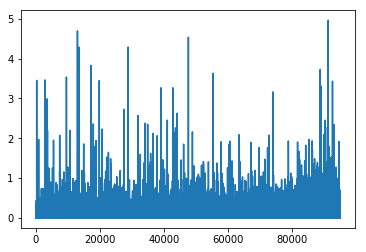

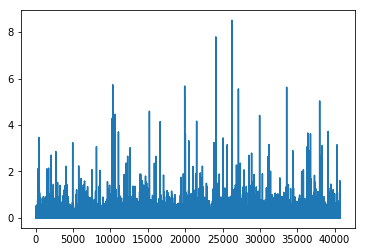

decaying  0.000368712063447464
EPOCH 10


0.06586609277620448
0.06816305454557549
0.07393518824674049
0.07031479283694138
0.07298550604666841
0.0724265437064256
0.07072060945037682
0.06934707556414092
0.06717823347576417
0.06501792031402336
0.06334563966520505
0.07112173448224178
0.07040770084379924
0.07011874682750688
0.06843000055008015
0.06772573166080634
0.06841550364789646
0.06927814182833307
0.06957823963509517
0.06797446835898181
0.06823501106088489
0.06997104557654595
0.06808723466252391
0.06829478677019726
0.06801025519331637
0.06749630271544611
0.06842618827175198
0.06830134684970898
0.06852892312715195
0.06844259946596892
0.06886549226001072
0.06875843971142545
0.06832695001449736
0.06827783941662165
0.06888320914974363
0.06849939143238895
0.06823769902956732
0.06874319355597126
0.06843696520071456
0.06957952123061902
0.07118965232936986
0.07036658052695324
0.06990742471290216
0.0699880634833203
0.06933451759312033
0.06883720146330854
0.07046414620560548
0.06992944619026087
0.07005902445191836
0.069678030081099
0.06

0.06992692909592804
0.06999205863403835
0.06994226311960239
0.06991167429147783
0.06983526233420852
0.06974664955743486
0.06971943841394804
0.06966082720472214
0.06954724864207928
0.0694274843706664
0.0695099053935913
0.06948366417645137
0.06941811108863649
0.06948611469384786
0.06948498382072915
0.0697184579994467
0.07001296111105726
0.07002741798191697
0.07001902984836728
0.07002609289308002
0.07023681561330423
0.0701462836104543
0.0701217911586429
0.07012418141813101
0.07004160528875274
0.07002552083653886
0.0699781598275493
0.06991228078872659
0.06992330161539394
0.06988238344292279
0.06980226388631824
0.06976414520405733
0.06993777637284582
0.06984641560973397
0.069794723575641
0.06974523922490747
0.07023246570194643
0.07025474277762682
0.07021357384122372
0.07018082379936472
0.07017719669680848
0.07020013868428858
0.07016506957017313
0.07012604172635041
0.07006638232482115
0.07012246692078347
0.07015485004098414
0.07015280198959165
0.07015580457218573
0.07008195319699251
0.069996

0.06748397633625829
0.06747120778103718
0.06746669609456316
0.06745148512480191
0.06747347028258
0.06760838802189048
0.06762436272206569
0.06758377304359768
0.06756427745908881
0.06760946644257931
0.06756530849098079
0.06760745635615685
0.06766426953371826
0.06759579937211874
0.06765358064975925
0.0676379825095678
0.06762317214065869
0.06763616806622678
0.06757986557971506
0.06758795207772655
0.06750993872097773
0.06749685553608575
0.06744223341346212
0.06741878413721666
0.06740075409616954
0.06736838366206992
0.06736214248849962
0.06731349546375899
0.06731976952294662
0.06734577753822141
0.06737026902872154
0.06741949358521229
0.06744462574691922
0.06741994240518179
0.06738072341036071
0.0673824361119767
0.0673758826949365
0.06737172385026888
0.06739311911735443
0.06738365015627525
0.06739760587395731
0.0673890668046619
0.06736957487093066
0.06739739978687646
0.06736328603857057
0.06738860183088365
0.0673594931950594
0.06743932784747897
0.0674313621904827
0.0674316681819202
0.06744098

0.07048924097347609
0.07047500000861474
0.07042198299494906
0.07052888778867952
0.07054225345817845
0.0705334187289862
0.070533935555717
0.07052734671975346
0.07054440882506602
0.07053229811770437
0.07057805053207038
0.07059734994957617
0.07059737180850621
0.07066990007045419
0.07066451146377443
0.07065449158655096
0.07064738140760962
0.07065336370116768
0.07068436105741911
0.07067876138718823
0.07081008795495154
0.07079560142993108
0.07078689019246905
0.07081173811926293
0.07082648869373696
0.07084004324199696
0.07087102655116642
0.07098128375405857
0.0710051553244973
0.07098786517832863
0.07098682531737403
0.07098229268650025
0.07102229149423854
0.07103745674217682
0.07107290279404886
0.07105971322124924
0.07105482349879536
0.07106201542879079
0.0710523535165091
0.07114374168114315
0.07114511063974678
0.07120829043247223
0.07124955577874281
0.07125269301950166
0.07128372735909957
0.07127159046592019
0.0713005031147073
0.07136761639920465
0.07145158559526489
0.07146878981452075
0.0714

0.07331181140437304
0.07329426247557674
0.07330549652985704
0.07327407915031005
0.0732740347986565
0.07328782372725863
0.07325796670671347
0.07323554970824868
0.07325832451552933
0.07324297736681719
0.07325174591323082
0.07324518357064103
0.07324466810911183
0.07330247537214435
0.07330076886089465
0.07329711794804392
0.07329427549726943
0.07328692605839054
0.07329255284137559
0.07330746895171182
0.07330403159412915
0.0733088291296532
0.07329327450058712
0.0732715351966806
0.0732587810291439
0.07323230696425033
0.07323895485018973
0.07323766948902816
0.07323591415896054
0.07319709064176708
0.07318167510257971
0.07315604809613727
0.07313015282059818
0.07311053987886704
0.07313029544759322
0.07313428867760537
0.07311653726816289
0.07310332005445018
0.07308889343894412
0.07307276800554532
0.07308000316976158
0.0730521728495891
0.07307238655870953
0.0730615373080568
0.07300977261361125
0.07298015833681755
0.07295100918115549
0.07293359296939639
0.07290358808933067
0.07293788388296103
0.0729

0.0738528124037339
0.07386863074554184
0.07386746091621976
0.0738616047862935
0.07385497907514445
0.07385019812585682
0.07384417896016442
0.07383635564626491
0.07382504792747648
0.07379628132499887
0.07377413869258953
0.07375322458225633
0.07372501676037689
0.07369813356082948
0.07367840837370673
0.07365882931967485
0.0736496244828685
0.07364348725518526
0.07362315736789729
0.07362163271809098
0.07360200904513677
0.07358973220360011
0.0735829280926597
0.07359471848735684
0.0735973640672418
0.07360090352897916
0.07357717215856117
0.07361707130132691
0.07361443687462818
0.0735832892216814
0.0735765556240027
0.07356927734433916
0.07356221779940797
0.07356319932417865
0.07355123982744877
0.07355058019966823
0.07355782616399063
0.07355255020067994
0.0735494596920996
0.07356249646314318
0.07354436608510263
0.07353766533094325
0.07350835995854554
0.07350050634931625
0.07352102643014324
0.07350764428739515
0.07350290722995118
0.07352705591334172
0.07356538437302507
0.0735670455856496
0.0735760

0.07372218319012012
0.07369824538579567
0.07368163050907241
0.07369726241050512
0.07369181657477997
0.07369060038007234
0.07367349529845063
0.07366192879448842
0.0736553324868778
0.07367911033178799
0.07367987939681432
0.07366250652062739
0.07364432133205866
0.07363900638015794
0.07362269134771328
0.07361233132371463
0.07360902857348922
0.07360162234264843
0.07358958938572524
0.0735921762014584
0.0735754730544006
0.07360473279063984
0.07361242693216215
0.07359987734362179
0.07360751568974527
0.073612230815903
0.07361456452744523
0.07361003559782091
0.07364310299666264
0.0736531171610201
0.07367111580386941
0.07374791651546916
0.07381802580201068
0.0738057953593362
0.07383579856253783
0.07393995919638617
0.07393377238947521
0.07394354939095191
0.0739468235842538
0.07396676858016643
0.07396354428748857
0.07396450833739356
0.0739507623013243
0.07393940508083087
0.07394502102686766
0.07394198148992569
0.07394120894522573
0.0739476030564652
0.07393202346586795
0.07394495098490707
0.07394439

0.07317823226579456
0.07317728165784079
0.07317310814191168
0.07315519912524045
0.07314708417047551
0.07313846642461774
0.07313275964253087
0.07312689914878448
0.07312643969391193
0.07313021163811918
0.07313520977511616
0.07313571834976076
0.073121403363305
0.07312354555586767
0.07325933229256186
0.07325052685951196
0.07325766696314458
0.07323992361278008
0.07323744401056952
0.07323194466805778
0.07324411934296121
0.07323059076200227
0.0732408712179258
0.0732268939463932
0.0732207888941454
0.0732118993558968
0.07320873655197255
0.07319944925851189
0.07319850023892327
0.0732045137457275
0.07318953757766154
0.073190079341412
0.0732021022864415
0.07321739647862711
0.07321546141918019
0.07319821107964457
0.07320008892690157
0.07319853982489818
0.07319477719151585
0.07317506808147341
0.07316509992817319
0.0731584057376786
0.073183330938396
0.07318333514967267
0.07315994184478536
0.07315221954011826
0.07313444048854074
0.07312663538554771
0.07311765942517877
0.07311370600555438
0.07310526710

0.07284861600739749
0.07283968735715722
0.07282662707939275
0.0728245796643039
0.07281492683427301
0.07280991395404626
0.0728084281368676
0.07280714277160776
0.07279624560104221
0.07278648030022065
0.07277174126946545
0.07276410364291526
0.07275895355976958
0.07275398729675989
0.07274674504842041
0.0727452841568005
0.07272460081509316
0.07271013722148986
0.072728817434397
0.07273025724140311
0.07272556569568245
0.07270866328544458
0.07270139699294555
0.07269861095089014
0.07269658048103356
0.07268728111884301
0.07267520415600003
0.07267299368275665
0.07268855078370406
0.07268246282216692
0.07267892638788082
0.07267904769639849
0.07269081206805368
0.07268826627777168
0.07267744817060738
0.07267488592764851
0.0726845679794187
0.07267280123759236
0.0726704542116129
0.07266796653092808
0.0726690837137496
0.07265589929023249
0.07265827637207942
0.07264932502496259
0.07264633512905212
0.07263937453956024
0.0726720803800962
0.07266599781653582
0.07264924512699815
0.07264307215347163
0.0726498

0.07266768989902833
0.07266155564064578
0.07265827526636867
0.07267603240986467
0.07267485487921804
0.07268383353906738
0.07268582395006361
0.07270323361336437
0.072703605408437
0.0726932582534746
0.07269170483607688
0.07269978196295965
0.07270943096368855
0.07271535783522316
0.0727158868943294
0.07274067428789155
0.07273966534231202
0.07272918538531771
0.07272111140708255
0.07272142819102903
0.07271292256317045
0.07270747777100714
0.07270665672652492
0.07269937388712805
0.07269602969578677
0.07270368750311643
0.07269834366742078
0.07269771645816157
0.0727199507904558
0.07271932242196176
0.0727153587317625
0.07271171550498372
0.07271725642149633
0.07271760372244983
0.07270850684555899
0.07270464438879375
0.07271010088961469
0.07270202293300759
0.0727115280469251
0.07271189909648569
0.07271979143869035
0.07271882616574656
0.072725174672484
0.07272511344350305
0.07273756296048038
0.07273907719245452
0.07273876661071747
0.07275023254075598
0.07274177115995883
0.07274437856858851
0.0727431

0.07304477565035349
0.07304701722451995
0.07304698241301152
0.0730489853862193
0.0730464396971877
0.07305276618777715
0.0730519304052723
0.07305609144354731
0.07306277490649239
0.07306258087714948
0.07304983059518987
0.07305031574329719
0.07305316974762145
0.07304304020710961
0.07304916047447142
0.07304694849071468
0.0730467919566631
0.07303579758645738
0.07302320992557362
0.07301600067965487
0.07303656265676686
0.07303654666291778
0.07303685728779778
0.07303229628791746
0.07302600645446534
0.0730167921122933
0.07300587575253287
0.07301333169796256
0.07301916982896513
0.07302216205023765
0.07301531778347174
0.07302594830515452
0.07302511578076057
0.07302632217564771
0.07302305932311157
0.07302345280837154
0.07302283070100134
0.07302429579649689
0.07301229462534162
0.07302748211363494
0.07302869895920001
0.07302649573364642
0.07301597105164875
0.0730137377045978
0.07302688702015482
0.07302969095805824
0.0730258987605314
0.073020842082083
0.07302934627913472
0.07302018732098402
0.0730198

0.07414320723916967
0.07414666583304849
0.07415630769294378
0.07416778089555966
0.07418170384297426
0.07420503304947705
0.07419765720899317
0.07421443816884067
0.07421599012708725
0.07421070914831893
0.0742177835677049
0.07421983271780949
0.07423031835092295
0.0742358751508258
0.07423930877416816
0.07424942017656444
0.0742834583008835
0.07428625590266663
0.07429045471314853
0.07427984035729265
0.07428670649629415
0.07428154016652418
0.07427650274748486
0.07427874313862837
0.0742725288103998
0.07429976394930954
0.07429569803248638
0.07430589201960829
0.07430529781902868
0.07430430035491471
0.07429650765519748
0.07429712388992761
0.07429782949468387
0.07429954060199392
0.07430030708617058
0.07428705931729356
0.07428096051486752
0.07427827566752626
0.07428858091832582
0.07429052527283425
0.07428513496687168
0.074287161093895
0.07428947973440532
0.07429019501188047
0.07429785748896073
0.07431238014304592
0.07430981264232517
0.07432072506896616
0.07431869584990432
0.07431040735196012
0.0743

0.07468009776979019
0.07468370777002349
0.07468445464281008
0.07468125486044193
0.07468200839446015
0.07468600225192175
0.07468603135764139
0.07469235954544917
0.07471553995409976
0.07471612241821628
0.07472868392942542
0.07473022649348303
0.07472574069264769
0.07473302751096832
0.07473107325269525
0.07473512802296968
0.07473946059347884
0.07474159172620422
0.07474006963442825
0.07473368441235277
0.07473368616212037
0.07472673680366233
0.07472714394477906
0.07472696248322827
0.07473787249232737
0.0747450705959878
0.07476254961207429
0.07477778413988226
0.07477531689572524
0.07478375361698388
0.0747888360299187
0.07478873354677099
0.07479470991165887
0.0748036931938933
0.0748160428248017
0.0748261722926181
0.07482050073838971
0.07482616091094525
0.07482189972869814
0.07483967799471633
0.0748314074449825
0.07483108252235798
0.07483071992831009
0.07482251706003218
0.07482179620777148
0.07482120652490128
0.07482743523458096
0.07482322650466804
0.0748155147014144
0.07482317528616866
0.07482

Accuracy =  0.9866706604762618
BEST:  0.07574266814350022
TRAINING:  0.07512549485356707
EVAL:  0.07574266814350022


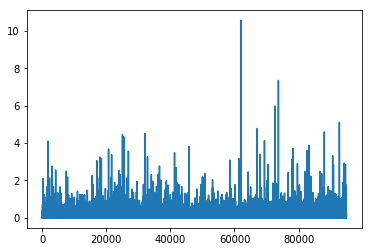

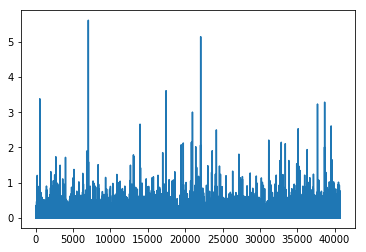

decaying  0.0003576507015440401
EPOCH 11


0.13429376026075518
0.15150651311130667
0.13213345883589536
0.12040818769941462
0.11718026835665893
0.11560645931289969
0.11900740121800085
0.11556073282236413
0.11268953072357049
0.11320535063619336
0.10820410688099437
0.10641718754281347
0.10502150074627854
0.10819842518073411
0.1059154925342855
0.10201559969774214
0.1025969146164765
0.09871701486801181
0.10139115599963579
0.10105227328648339
0.09868559099092841
0.09983301529880491
0.09836284261114821
0.09630842004136755
0.09593005387063663
0.09463342283232017
0.093841467778177
0.09199993988600723
0.09050202172999078
0.09092635557510352
0.09060860204573652
0.09121646627696355
0.09081522050893771
0.08980669929531619
0.09026102832101152
0.09012998760935267
0.09020798072851331
0.09122819498806294
0.0899478283391025
0.08967742978196887
0.08929381715344238
0.09075316402534839
0.09086237097329937
0.0894145183593671
0.08911767123144101
0.08875668569581854
0.08786576244685891
0.08823376294712981
0.08839051134056965
0.08857121955297706
0.0881

0.08414220740389579
0.08414466891791668
0.08419615752922328
0.08416825976865042
0.08412605653252556
0.08413930904485624
0.0840963181429697
0.08400136916138354
0.08394867001190928
0.08391493547855404
0.08379849000863654
0.08373431941189302
0.08388233921974837
0.08395743593401968
0.08383007565631508
0.08387979441638405
0.08392059424102856
0.08391935355413067
0.08395852384739486
0.0838953190602473
0.0838224448956097
0.0838499909691635
0.08401524397684232
0.08410385285710995
0.08409939206351856
0.0843091108932238
0.08431604364535714
0.08429337332072569
0.08433066004430236
0.08440789225587364
0.08435405372692426
0.08453511048398354
0.08446621522675894
0.08454738619290521
0.08455328524144917
0.08453983516298448
0.08453953973536019
0.08468682243071754
0.08480044413665112
0.08472950386584557
0.08469038977009224
0.08466816120844115
0.08461414949340082
0.08449749581515108
0.0844776957144556
0.08444760785212292
0.08433397392525997
0.08427692033613354
0.08419363628932801
0.08423537372904533
0.0841

0.08214091783175202
0.08212083515462755
0.08209851804325531
0.08204202611733848
0.08209021651818656
0.08208459548287185
0.08204757816926708
0.08204013318906969
0.0820532337400646
0.08195938056711208
0.08195707152195367
0.081919872091615
0.08189329853017933
0.08183442318314775
0.08178066606898168
0.08177589080466578
0.08174239125986281
0.08169616456839741
0.08168997089767162
0.08165472791210272
0.08161967407447765
0.0816410324963643
0.08167570224383007
0.0816885951525507
0.08165120284472088
0.08166220665580916
0.08166639018272054
0.0816153290569519
0.08167882796418337
0.08168109743253249
0.08171962537888915
0.08166964930274778
0.0816902070147838
0.08162711271440747
0.08161672271448604
0.08162716366445119
0.08164061895301315
0.08163175367776733
0.08162238736341869
0.081574086058005
0.08160909818068204
0.08157021534469326
0.08161676593889915
0.08160763749111788
0.08159218879966522
0.08158540999039433
0.0817094658123679
0.08167857918580979
0.08170590908962785
0.0816719469694321
0.081615837

KeyboardInterrupt: 

In [9]:
from tqdm import tqdm_notebook
lr = 0.0005
verbose = False
trainer.learning_rate = lr
i = 0
best_eval = np.inf
history_length = 2

def run_thread(thread,update):
    
    history = []
    all_loss = []
    for message in thread:
        dy.renew_cg()
        history.append(message)
        
        I,type_string, output_string, embedded_string,gen,gOrC, cop = message
        inputs = []
        types = []
        embeddings = []
        histories = []

        for h,m in enumerate(reversed(history[-history_length:])):
            input_string,type_string, _, embedded_string,_,_,_ = m
            inputs += input_string
            types += [t for t,_ in zip(type_string,input_string)]
            embeddings.append(embedded_string[2])
            histories += [h]*len(input_string)

        embeddings = np.vstack(embeddings)
        for e in embeddings:
            break
        loss,correct,total = copy_network.get_loss(histories,inputs,types,embeddings, gOrC,gen,cop,
                                     dropout=0.1+random.random()*0.4,
                                    teacher_forcing_=lambda : random.random()<0.15,copy_loss_modifier=1.0)
        loss = dy.esum(loss)
        if update:
            loss.backward()
            trainer.update()
        all_loss.append(loss.value()/(2.0*len(gOrC)))
        
    return all_loss,correct,total

for epoch in tqdm_notebook(range(500)):
    print(f'EPOCH {epoch}')
    random.shuffle(all_data_training)
    average_training = []
    i = 0
    for thread in tqdm_notebook(all_data_training):        
        average_training += run_thread(thread,True)[0]
        i += len(average_training)
        
        if i > 100:
            i -= 100
            print(np.mean(average_training[:]),)
            sys.stdout.flush()
       
    average_eval = []     
    correct = 0
    total = 0
    for thread in tqdm_notebook(all_data_eval):
        loss,c,t = run_thread(thread,False)
        average_eval += loss
        correct += c
        total += t
    print('Accuracy = ',float(correct)/float(total))
    if np.mean(average_eval) < best_eval:
        print('BEST: ',np.mean(average_eval[:]))
        copy_network.model.save(f'ConversationalistAllSoftmax_3_3_1024_512_1024_{history_length}_{data_file.split(".")[0]}.model')
        
    print('TRAINING: ',np.mean(average_training[:]))
    print('EVAL: ',np.mean(average_eval[:]))
    import matplotlib.pyplot as plt
    plt.plot(average_training)
    plt.show()
    plt.plot(average_eval)
    plt.show()    
    if epoch % 1 == 0:
        lr = lr *0.97
        print('decaying ', lr)
        trainer.learning_rate = lr


99.2% predict_mode = True,mode_softmax = False, multiply_mode = True, joint_loss = True,hard_mode=True

98.77% accuracy from predict_mode = True,mode_softmax = False, multiply_mode = True, joint_loss = False after 1 epoch

99.3% accuracy from predict_mode = True,mode_softmax = False, multiply_mode = False, joint_loss = False,hard_mode =True after 1 epoch

90.94%   accuracy from predict_mode = True,mode_softmax = True, multiply_mode = True, joint_loss = False after 1 epoch

In [ ]:
from tqdm import tqdm_notebook
lr = 0.00005



trainer.learning_rate = lr
i = 0
best_eval = np.inf
history_length = 3

def run_thread(thread,update):
    
    history = []
    all_loss = []
    for message in thread:
        dy.renew_cg()
        history.append(message)
        
        I,type_string, output_string, embedded_string,gen,gOrC, cop = message
        inputs = []
        types = []
        embeddings = []
        histories = []

        for h,m in enumerate(reversed(history[-history_length:])):
            input_string,type_string, _, embedded_string,_,_,_ = m
            inputs += input_string
            types += [t for t,_ in zip(type_string,input_string)]
            embeddings.append(embedded_string[2])
            histories += [h]*len(input_string)

        embeddings = np.vstack(embeddings)
        for e in embeddings:
            break
        loss = copy_network.get_loss(histories,inputs,types,embeddings, gOrC,gen,cop,
                                     dropout=0.3+random.random()*0.7,
                                    teacher_forcing_=lambda : random.random()<0.15,copy_loss_modifier=1.0)
        loss = dy.esum(loss)
        if update:
            loss.backward()
            trainer.update()
        all_loss.append(loss.value()/(2.0*len(gOrC)))
    return all_loss
for epoch in  tqdm_notebook(range(500)):
    print(f'EPOCH {epoch}')
    
    random.shuffle(all_data_training)
    average_training = []
    for thread in tqdm_notebook(all_data_training):
        
        history = []
        print(len(thread))
        for message in thread:
            dy.renew_cg()
            history.append(message)
            i += 1
            #list(zip([m[0] for m in thread[0]],[m[1] for m in thread[0]], thread[1],thread_gen,thread_gc,thread_cop)))
            
            I,type_string, output_string, embedded_string,gen,gOrC, cop = message
            inputs = []
            types = []
            embeddings = []
            histories = []
            
            for h,m in enumerate(reversed(history[-history_length:])):
                input_string,type_string, _, embedded_string,_,_,_ = m
                inputs += input_string
                types += [t for t,_ in zip(type_string,input_string)]
                embeddings.append(embedded_string[2])
                histories += [h]*len(input_string)
                
            embeddings = np.vstack(embeddings)
            for e in embeddings:
                break
            loss = copy_network.get_loss(histories,inputs,types,embeddings, gOrC,gen,cop,
                                         dropout=0.3+random.random()*0.7,
                                        teacher_rcing_=lambda : random.random()<0.15,copy_loss_modifier=1.0)
            loss = dy.esum(loss)
            loss.backward()
            trainer.update()
            average_training.append(loss.value()/(2.0*len(gOrC)))
            if i % 100 == 0:

                print(np.mean(average_training[:]),)
                sys.stdout.flush()
    average_eval = []
    for thread in tqdm_notebook(all_data_eval):
        history = []
        for message in thread:
            dy.renew_cg()
            history.insert(0,message)
            i += 1
             
            I,T,_,E,gen,gOrC, cop = message
            inputs = []
            types = []
            embeddings = []
            histories = []
            
            
            for h,m in enumerate(reversed(history[-history_length:])):
                input_string,type_string, _, embedded_string,_,_,_ = m
                inputs += input_string
                types += [t for t,_ in zip(type_string,input_string)]
                embeddings.append(embedded_string[2])
                histories += [h]*len(input_string)
                
                
            embeddings = np.vstack(embeddings)
            loss = copy_network.get_loss(histories,inputs,types,embeddings, gOrC,gen,cop,
                                         dropout=0.3+random.random()*0.7,
                                        teacher_forcing_=lambda : random.random()<0.15,copy_loss_modifier=1.0)
            loss = dy.esum(loss)
            average_eval.append(loss.value()/(2.0*len(gOrC)))
    if np.mean(average_eval) < best_eval:
        print('BEST: ',np.mean(average_eval[:]))
        copy_network.model.save(f'Conversationalist_3_3_1024_512_1024_{history_length}_{data_file.split(".")[0]}.model')
    print('TRAINING: ',np.mean(average_training[:]))
    print('EVAL: ',np.mean(average_eval[:]))
    import matplotlib.pyplot as plt
    plt.plot(average_training)
    plt.show()
    plt.plot(average_eval)
    plt.show()    
    if epoch % 1 == 0:
        lr = lr *0.97
        print('decaying ', lr)
        trainer.learning_rate = lr


In [ ]:
print(histories,inputs,types,embeddings, gOrC,gen,cop)
print(output_string)
print(len(inputs))
print(len(types))
print(len(embeddings))


In [ ]:
copy_network.model.save(f'Conversationalist_3_3_1024_1024_1024_1_{data_file.split(".")[0]}.model')

In [ ]:
pickle.dump((i2o,o2i,type_o2i,type_i2o),open('vocab.pkl','wb'))

In [ ]:

from allennlp.commands.elmo import ElmoEmbedder
elmo = ElmoEmbedder(options_file='~/DownloadedModels/Elmo/elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json',
                    weight_file='~/DownloadedModels/Elmo/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5',
                    cuda_device=1)

In [ ]:
import random
import numpy
i2o = {i:o for o,i in o2i.items()}


def translate(model,input_string,type_string,embedded_string,max_len=30,eos='[[CLS]]'):
        dy.renew_cg()
        numbered = [is_number(s) for s in input_string]
        embedded_string = embedded_string[2]
        #embedded_string = [dy.inputTensor(e) for e in embedded_string]
        embedded_string = [dy.inputTensor(e) for e in embedded_string]
        
        
        embedded_string = [dy.concatenate([dy.inputTensor(np.array([n])),
                                           e,
                                           model.type_embeddings[type_o2i[t]]]) for n,e,t in zip(numbered,
                                                                                                embedded_string,
                                                                                                type_string)]
        encoded_string_f = model._encode_string(embedded_string,model.ENC_RNN_F)
        encoded_string_b = model._encode_string(list(reversed(embedded_string)),model.ENC_RNN_B)
        encoded_string = [dy.concatenate([f,b]) for f,b in zip(encoded_string_f,reversed(encoded_string_b))]

        mode_probs = []
        gen_probs = []
        copy_probs = []
        
        losses = []
        generate = random.random() < 0.01
        output = []
        prev_mode = 0
        prev_tok = o2i['<START>']
        rnn_state = model.DEC_RNN.initial_state().add_input(
                dy.vecInput(model.enc_state_size+model.output_embedding_size+2)
            )
        for _ in range(max_len):
            attended_encoding,_ = model._attend(encoded_string, rnn_state, 
                                                       model.attention_w1, model.attention_w2,model.attention_v)
            _,p_copy = model._attend(encoded_string, rnn_state, 
                                                       model.copy_w1, model.copy_w2,model.copy_v)
            
            mode_vec = np.zeros(2)
            mode_vec[prev_mode] = 1
            rnn_input = dy.concatenate([attended_encoding,
                                        model.output_embeddings[prev_tok],
                                        dy.inputTensor(mode_vec)
                                       ])  
            
            rnn_state = rnn_state.add_input(rnn_input)
            
            p_mode = model.get_probs(model.mode_w,model.mode_b,rnn_state.output())
            
            p_gen = model.get_probs(model.output_w,model.output_b,rnn_state.output())
            
            p_mode = p_mode.value()
            p_copy = p_copy.value()
            p_gen = p_gen.value()            
            
            if p_mode[0] > p_mode[1]:
                prev_mode = 0
                prev_tok = p_gen.index(max(p_gen))
                output.append(i2o[p_gen.index(max(p_gen))])
            else:
                prev_mode = 1
                prev_tok = 0
                output.append(input_string[p_copy.index(max(p_copy))])
            if output[-1] == eos:
                break
        return output

In [ ]:
import random
def set_dropout(model,dropout):
    model.DEC_RNN.set_dropout(dropout)
    model.ENC_RNN_F.set_dropout(dropout)
    model.ENC_RNN_B.set_dropout(dropout)
    
    
set_dropout(copy_network,0)

def translate_sample(model,input_string,type_string,embedded_string,mode_temp=1.0,gen_temp=1.0,copy_temp=1.0,max_len=30,eos='[[CLS]]'):
        dy.renew_cg()
        numbered = [is_number(s) for s in input_string]
        embedded_string = embedded_string[2]
        embedded_string = [dy.inputTensor(e) for e in embedded_string]
        
        
        embedded_string = [dy.concatenate([dy.inputTensor(np.array([n])),
                                           e,
                                           model.type_embeddings[type_o2i[t]]]) for n,e,t in zip(numbered,
                                                                                                embedded_string,
                                                                                                type_string)]
        encoded_string_f = model._encode_string(embedded_string,model.ENC_RNN_F)
        encoded_string_b = model._encode_string(list(reversed(embedded_string)),model.ENC_RNN_B)
        encoded_string = [dy.concatenate([f,b]) for f,b in zip(encoded_string_f,reversed(encoded_string_b))]

        mode_probs = []
        gen_probs = []
        copy_probs = []
        
        losses = []
        generate = random.random() < 0.01
        output = []
        prev_mode = 0
        prev_tok = o2i['<START>']
        rnn_state = model.DEC_RNN.initial_state().add_input(
                dy.vecInput(model.enc_state_size+model.output_embedding_size+2)
            )
        probs = []
        for _ in range(max_len):
            attended_encoding,_ = model._attend(encoded_string, rnn_state, 
                                                       model.attention_w1, model.attention_w2,model.attention_v)
            _,p_copy = model._attend(encoded_string, rnn_state, 
                                                       model.copy_w1, model.copy_w2,model.copy_v)
            
            mode_vec = np.zeros(2)
            mode_vec[prev_mode] = 1
            rnn_input = dy.concatenate([attended_encoding,
                                        model.output_embeddings[prev_tok],
                                        dy.inputTensor(mode_vec)
                                       ])
            
            rnn_state = rnn_state.add_input(rnn_input)
            
            p_mode = model.get_probs(model.mode_w,model.mode_b,rnn_state.output())
            if mode_temp != 0:
                mode_prob = dy.softmax(p_mode/mode_temp).value()
                prev_mode = np.argmax(np.random.multinomial(1,mode_prob))
            else:
                mode_prob = dy.softmax(p_mode).value()
                prev_mode = np.argmax(mode_prob)
            
            if prev_mode == 0:
                
                p_gen = model.get_probs(model.output_w,model.output_b,rnn_state.output())
                orig_prob = dy.softmax(p_gen).value()
                if gen_temp != 0:
                    gen_prob = dy.softmax(p_gen/gen_temp).value()
                
                    gen_prob = gen_prob/np.sum(gen_prob)
                    prev_tok = np.argmax(np.random.multinomial(1,gen_prob))
                else:
                    prev_tok = np.argmax(orig_prob)
                orig_prob =orig_prob/np.sum(orig_prob)
                output.append(i2o[prev_tok])
                gen_prob = orig_prob[prev_tok]
            else:
                
                orig_prob = dy.softmax(p_copy).value()             
                orig_prob = orig_prob/np.sum(orig_prob)
                if gen_temp != 0:
                    gen_prob = dy.softmax(p_copy/copy_temp).value()                
                    gen_prob = gen_prob/np.sum(gen_prob)
                    copy_tok = np.argmax(np.random.multinomial(1,gen_prob))
                else:
                    copy_tok = np.argmax(orig_prob)          
                               
                prev_tok = 0
                output.append(input_string[copy_tok])
                gen_prob= orig_prob[copy_tok]
            if output[-1] == eos:
                break
            probs.append(mode_prob[prev_mode])
            probs.append(gen_prob)
        return output,probs
type_string = ['$FROM_FNAME', '$FROM_LNAME', '$FROM_EMAIL', '$TO_FNAME', '$TO_LNAME', '$TO_EMAIL', '$YEAR', '$MONTH', '$DAY', '$HOUR', '$MINUTE', '$GAP']
sentence = ['John', 'Davin', 'LWmow@SMAqB.com', 'Steven', 'Smalley', 'oFDvG@kIrPz.com', '2019', '10', '9', '7', '43', '$N/A',
            'I', 'hope', 'you', "'re", 'available', 'at', 'the', 'moment', 'for', 'a', 'task', '(', 'urgent', ')', '?',
            '\n\n', 'Let', 'me', 'know', 'either', 'way', 'as', 'soon', 'as', 'possible', '.',
            'I', 'urgently', 'need', 'you', 'to', 'buy', 'some', 'gift', 'cards', 'for', 'me', 'ASAP', '.', 
            'Please', 'confirm', 'that', 'you', "'re", 'on', 'this', '.', '\n\n', '-', 'John', '\n\n', 'Sent', 'from', 'my', 'iPhone']
sentence =['James', 'Ancelet', 'MjIDf@tCoTs.com', 'Patricia', 'Tikalsky', 'zleDT@PBRam.com', 
           '2019', '8', '10', '8', '1', '$N/A', 
          # 'Do', 'you', 'happen', 'to', 'be', 'available', 'immediately', 'to', 'do', 'something', 'for', 'me',
          # '(', 'it', "'s", 'urgent', ')', '?', 
          # 'I', "'m", 'on', 'jury', 'duty', 'and', 'ca', "n't", 'talk', 'on', 'the', 'phone', ',', 
          # 'so', 'I', 'can', 'only', 'be', 'reached', 'via', 'email', '.',
           'Go',
           'buy', '15', '$', '50', 'iTunes', 'gift', 'cards', 'for', 'me', 'ASAP', '.',
           'I','need','you','to', 'do','this'
           '\n', '-', 'James', ]

  
def prepare_sentence(sentence):
    type_string = ['$FROM_FNAME', '$FROM_LNAME', '$FROM_EMAIL', '$TO_FNAME', '$TO_LNAME', '$TO_EMAIL', 
                   '$YEAR', '$MONTH', '$DAY', '$HOUR', '$MINUTE', '$GAP']

    type_string = type_string + ['$BODY']*(len(sentence)-len(type_string))
    embedded = elmo.embed_sentence(sentence)
    return type_string,embedded




type_string, embedded = prepare_sentence(sentence)
best_score = -np.inf
best = None
for _ in range(20):
    output,probs = translate_sample(copy_network,  sentence,type_string,
                                    embedded,
                                    gen_temp=0.1,
                                    mode_temp=0.1,
                                    copy_temp=0.1,max_len=200)
    score = np.sum(np.log(probs))/len(output)
    if score > best_score:
        best_score = score
        best = output
print(output)
print(best_score)
output,probs = translate_sample(copy_network,  sentence,type_string,
                                embedded,
                                gen_temp=0,
                                mode_temp=0,
                                copy_temp=0,max_len=200)
score = np.sum(np.log(probs))/len(output)
print(output)
print(score)

In [ ]:
import random
import numpy
i2o = {i:o for o,i in o2i.items()}


def translate_beam_search(model,input_string,type_string,embedded_string,beam_width=3,max_len=30,eos='[[CLS]]'):
        dy.renew_cg()
        numbered = [is_number(s) for s in input_string]
        embedded_string = embedded_string[2]
        embedded_string = [dy.inputTensor(e) for e in embedded_string]
        
        
        embedded_string = [dy.concatenate([dy.inputTensor(np.array([n])),
                                           e,
                                           model.type_embeddings[type_o2i[t]]]) for n,e,t in zip(numbered,
                                                                                                embedded_string,
                                                                                                type_string)]
        encoded_string_f = model._encode_string(embedded_string,model.ENC_RNN_F)
        encoded_string_b = model._encode_string(list(reversed(embedded_string)),model.ENC_RNN_B)
        encoded_string = [dy.concatenate([f,b]) for f,b in zip(encoded_string_f,reversed(encoded_string_b))]

        mode_probs = []
        gen_probs = []
        copy_probs = []
        
        losses = []
        generate = random.random() < 0.01
        output = []
        prev_mode = 0
        prev_tok = o2i['<START>']
        rnn_state = model.DEC_RNN.initial_state().add_input(
                dy.vecInput(model.enc_state_size+model.output_embedding_size+2)
            )
        
        beams = [(0,0,[],rnn_state,prev_mode,prev_tok)]
        for _ in range(max_len):
            potentials = []
            for score,sum_score,output, rnn_state, prev_mode,prev_tok in beams:
                
                if prev_tok == o2i[eos]:
                    potentials.append((score,sum_score,
                                    output,rnn_state,prev_mode,prev_tok))
                    continue
                    
                attended_encoding,_ = model._attend(encoded_string, rnn_state, 
                                                           model.attention_w1, model.attention_w2,model.attention_v)
                _,p_copy = model._attend(encoded_string, rnn_state, 
                                                           model.copy_w1, model.copy_w2,model.copy_v)

                mode_vec = np.zeros(2)
                mode_vec[prev_mode] = 1
                rnn_input = dy.concatenate([attended_encoding,
                                            model.output_embeddings[prev_tok],
                                            dy.inputTensor(mode_vec)
                                           ])



                rnn_state = rnn_state.add_input(rnn_input)

                p_mode = model.get_probs(model.mode_w,model.mode_b,rnn_state.output())

                p_gen = model.get_probs(model.output_w,model.output_b,rnn_state.output())

                p_mode = dy.softmax(p_mode).value()
                p_copy = p_copy.value()
                p_gen = dy.softmax(p_gen).value()
                options = []
                
                
                probs = [(p,i) for i,p in enumerate(p_gen)]
                probs = sorted(probs,reverse=True)[:beam_width]
                
                for p,i in probs:
                    sum_score_ = sum_score+np.log(p_mode[0])+np.log(p)
                    score = sum_score_/(len(output)+1)
                    options.append((score,sum_score_,
                                    output + [i2o[i]],rnn_state,0,i))

                probs = [(p,i) for i,p in enumerate(p_copy)]
                probs = sorted(probs,reverse=True)[:beam_width]

                for p,i in probs:
                    sum_score_ = sum_score+np.log(p_mode[1])+np.log(p)
                    score = sum_score_/(len(output)+1)
                    options.append((score,sum_score_,
                                    output + [input_string[i]],rnn_state,1,0))
                
                
                options = sorted(options,reverse=True)
                options = options[:beam_width]
                potentials += options
                
            beams = sorted(potentials,reverse=True)[:beam_width]
            
                    
        return beams
    
def prepare_sentence(sentence):
    type_string = ['$FROM_FNAME', '$FROM_LNAME', '$FROM_EMAIL', '$TO_FNAME', '$TO_LNAME', '$TO_EMAIL', 
                   '$YEAR', '$MONTH', '$DAY', '$HOUR', '$MINUTE', '$GAP']

    type_string = type_string + ['$BODY']*(len(sentence)-len(type_string))
    embedded = elmo.embed_sentence(sentence)
    return type_string,embedded



sentence =['James', 'Ancelet', 'MjIDf@tCoTs.com', 'Patricia', 'Tikalsky', 'zleDT@PBRam.com', 
           '2019', '8', '10', '8', '1', '$N/A', 
           'Go',
           'buy', '15', '$', '50', 'iTunes', 'gift', 'cards', 'for', 'me', 'ASAP', '.',
           'I','need','you','to', 'do','this'
           '\n', '-', 'James', ]

type_string, embedded = prepare_sentence(sentence)

beams = translate_beam_search(copy_network,sentence,type_string,embedded,
                      beam_width=5,max_len=200,eos='[[CLS]]')
for b in beams[:]:
    print(b)
    

In [ ]:

def translate_nucleus_sample(model,input_string,type_string,embedded_string,mode_temp=1.0,gen_temp=1.0,copy_temp=1.0,nucleus=0.9,max_len=30,eos='[[CLS]]'):
        dy.renew_cg()
        numbered = [is_number(s) for s in input_string]
        embedded_string = embedded_string[2]
        embedded_string = [dy.inputTensor(e) for e in embedded_string]
        
        
        embedded_string = [dy.concatenate([dy.inputTensor(np.array([n])),
                                           e,
                                           model.type_embeddings[type_o2i[t]]]) for n,e,t in zip(numbered,
                                                                                                embedded_string,
                                                                                                type_string)]
        encoded_string_f = model._encode_string(embedded_string,model.ENC_RNN_F)
        encoded_string_b = model._encode_string(list(reversed(embedded_string)),model.ENC_RNN_B)
        encoded_string = [dy.concatenate([f,b]) for f,b in zip(encoded_string_f,reversed(encoded_string_b))]

        mode_probs = []
        gen_probs = []
        copy_probs = []
        
        losses = []
        generate = random.random() < 0.01
        output = []
        prev_mode = 0
        prev_tok = o2i['<START>']
        rnn_state = model.DEC_RNN.initial_state().add_input(
                dy.vecInput(model.enc_state_size+model.output_embedding_size+2)
            )
        probs = []
        for _ in range(max_len):
            attended_encoding,_ = model._attend(encoded_string, rnn_state, 
                                                       model.attention_w1, model.attention_w2,model.attention_v)
            _,p_copy = model._attend(encoded_string, rnn_state, 
                                                       model.copy_w1, model.copy_w2,model.copy_v)
            
            mode_vec = np.zeros(2)
            mode_vec[prev_mode] = 1
            rnn_input = dy.concatenate([attended_encoding,
                                        model.output_embeddings[prev_tok],
                                        dy.inputTensor(mode_vec)
                                       ])
            
            rnn_state = rnn_state.add_input(rnn_input)
            
            p_mode = model.get_probs(model.mode_w,model.mode_b,rnn_state.output())
            if mode_temp != 0:
                mode_prob = dy.softmax(p_mode/mode_temp).value()
                prev_mode = np.argmax(np.random.multinomial(1,mode_prob))
            else:
                mode_prob = dy.softmax(p_mode).value()
                prev_mode = np.argmax(mode_prob)
            
            if prev_mode == 0:
                
                p_gen = model.get_probs(model.output_w,model.output_b,rnn_state.output())
                orig_prob = dy.softmax(p_gen).value()
                if gen_temp != 0:
                    gen_prob = dy.softmax(p_gen/gen_temp).value()                
                    gen_prob = gen_prob/np.sum(gen_prob)
                    
                    gen_prob = [(p,i) for i,p in enumerate(gen_prob)]

                    gen_prob = sorted(gen_prob,reverse=True)
                    cum_prob = 0
                    gen_prob_ = []
                    indices = []
                    for p,i in gen_prob:
                        if cum_prob > nucleus:
                            break
                        gen_prob_.append(p)
                        indices.append(i)
                        cum_prob += p
                    gen_prob_ = np.array(gen_prob_)/cum_prob
                    if len(gen_prob_) >1:
                        print('Gen', gen_prob_)
                    prev_tok = indices[np.argmax(np.random.multinomial(1,gen_prob_))]
                else:
                    prev_tok = np.argmax(orig_prob)
                    
                
                orig_prob =orig_prob/np.sum(orig_prob)
                output.append(i2o[prev_tok])
                gen_prob = orig_prob[prev_tok]
            else:
                
                orig_prob = p_copy.value()             
                orig_prob = orig_prob/np.sum(orig_prob)
                if gen_temp != 0:
                    gen_prob = p_copy.value()
                    gen_prob = np.exp(np.log(gen_prob)/copy_temp)
                    gen_prob = gen_prob/np.sum(gen_prob)
                    gen_prob = [(p,i) for i,p in enumerate(gen_prob)]

                    gen_prob = sorted(gen_prob,reverse=True)
                    cum_prob = 0
                    gen_prob_ = []
                    indices = []
                    for p,i in gen_prob:
                        if cum_prob > nucleus:
                            break
                        gen_prob_.append(p)
                        indices.append(i)
                        cum_prob += p
                    
                    gen_prob_ = np.array(gen_prob_)/cum_prob
                    if len(gen_prob_) >1:
                        print('Copy', gen_prob_)
                    copy_tok = indices[np.argmax(np.random.multinomial(1,gen_prob_))]
                else:
                    copy_tok = np.argmax(orig_prob)          
                               
                prev_tok = 0
                output.append(input_string[copy_tok])
                gen_prob= orig_prob[copy_tok]
            if output[-1] == eos:
                break
            probs.append(mode_prob[prev_mode])
            probs.append(gen_prob)
        return output,probs
    
def set_dropout(model,dropout):
    model.DEC_RNN.set_dropout(dropout)
    model.ENC_RNN_F.set_dropout(dropout)
    model.ENC_RNN_B.set_dropout(dropout)
    
    
set_dropout(copy_network,0)
    
best_score = -np.inf
best = None
for _ in range(50):
    output, probs = translate_nucleus_sample(copy_network,sentence,type_string,embedded,
                      nucleus=0.9,max_len=200,eos='[[CLS]]')
    score = np.sum(np.log(probs))/len(output)
    if score > best_score:
        best_score = score
        best = output
print(output)
print(best_score)

In [ ]:
#Thoughts on the data:
#It gets Bed Bath & Beyond but not Bed , Bath & Beyond -- make it more robust to spelling differences
#It also doesn't get Outback Steakhouse -- so maybe add more multi word gift card names

#It still seems to be overfitting
#e.g., 
#    'I','need','you','to',
#           'buy', '457', '$', '50', 'Bed','Bath','&','Beyond', 'gift', 'cards', 'for', 'me', 'ASAP', '.',
#           '\n', '-', 'James', '\n\n', 'Sent', 'from', 'my', 'iPhone']
# works but 
# 'Can', 'you', ...
# doesn't


print(all_data[0][0][0])
print(all_data[0][0][2])

In [ ]:
a = [1.3640618446714108e-11, 1.1083164132313719e-06, 1.8857741733250397e-11, 1.3196976318739576e-08, 1.225326221462253e-11, 9.422314555023724e-10, 1.1535195134986747e-07, 0.9999999999563177, 1.2778737349180107e-07, 3.751995254797341e-07, 3.333531359583222e-07, 5.723535090054632e-08, 1.2074775473289648e-08, 4.670662399492747e-09, 1.967804987128595e-10, 1.4175243208498506e-10, 9.109405480614336e-06, 1.8634605090886515e-10, 4.916721603106333e-11, 5.973859828538949e-08, 2.243133992714868e-07, 5.513519188965425e-07, 7.083992813975811e-08, 5.2531029590105224e-08, 2.608313174428328e-08, 7.00641815485009e-08, 2.122040500498444e-08, 3.8131691352691375e-08, 5.6287955942859065e-08, 2.2970600161179208e-07, 5.108544082773639e-08, 3.6798459722839858e-09, 2.0364517935446882e-10, 6.593096613977552e-10, 6.861888500118648e-09, 2.3426219695173565e-11, 1.5258417527711514e-06, 1.0125287163049123e-08, 1.4919654409278586e-07, 7.073738197225914e-10, 7.790397394555158e-09, 9.183113884100136e-09, 2.582737429272353e-09, 1.6410468824877222e-08, 1.5978417986581006e-09, 1.9619556344503147e-09, 1.3803174761553554e-07, 2.628892974755092e-10, 3.0569263001489684e-09, 6.579714757679253e-11, 1.0733344058081496e-08, 2.7581559028193095e-08, 3.1367170418628683e-08, 3.6238681373392987e-08, 2.290931031840497e-08, 5.303551534446905e-08, 5.598832892908799e-09, 1.7237956132790137e-08, 8.645185937551729e-09, 2.8855304021967843e-09, 8.095685031380281e-08, 2.327593806965199e-08, 1.0518557111171977e-08, 1.5701865969952374e-08, 1.4428753368635808e-08, 1.421675942920381e-07, 1.2294342667685022e-08, 1.058213138288223e-07, 1.4286517468852753e-08, 1.2074907280931212e-07, 1.0423292338858633e-08, 1.28734542848808e-08, 1.6960441538455674e-09, 6.553078583853081e-10, 8.345694639465493e-08]
a = np.array(a)
print(np.sum(a))